In [ ]:
# Criteria Meets Expectations
# Completion 
#             ● Every feature is investigated using either histograms, bi-plots, or
#             other visual and numeric means.
#             ● Pearson correlation coefficients and other statistical methods were
#             used to identify statistical relationship strengths.
# Process and understanding
#             ● The submission shows that the student understands how to explore
#             feature relationships in the data.
#             ● The submission demonstrates that the student made
#             data-supported decisions on when to select specific features.
# Presentation 
#             ● Jupyter Notebook is submitted with all the applied code steps in
#             working order and with notation or comments as needed.
#             ● The submission is complete and uploaded in full to the Github repo.

## Contents

* [Introduction](#Introduction)
    * [Imports](#Imports)
    * [About the RAVDESS dataset](#About_the_RAVDESS_dataset)
    * [About the CREMA-D dataset](#About_the_CREMA-D_dataset)
* [Exploring the data](#Exploring_the_data)
    * [Correlation](#Correlation)
    * [Distributions Of Feature Values](#Distributions_Of_Feature_Values)
    * [Investigating relationships with pairplot](#Investigating_relationships_with_pairplot)
        * [Mean pairplots](#Mean_pairplots)
        * [Median pairplots](#Median_pairplots)
        * [Standard deviation pairplots](#Standard_deviation_pairplots)
        * [Skew pairplots](#Skew_pairplots)
        * [Kurtosis pairplots](#Kurtosis_pairplots)
* [Exploring features with models](#Exploring_features_with_models)
    * [Random Forest Classifier](#Random_Forest_Classifier)
        * [Random Forest with CREMA-D](#Random_Forest_with_CREMA-D)
        * [Random Forest with RAVDESS](#Random_Forest_with_RAVDESS)
    * [Gradient Boosting](#Gradient_Boosting)
        * [Gradient Boosting with CREMA-D](#Gradient_Boosting_with_CREMA-D)
        * [Gradient Boosting with RAVDESS](#Gradient_Boosting_with_RAVDESS)
* [Feature importance](#Feature_importance)
* [Conclusion](#Conclusion)

# Introduction

## Imports

In [1]:
# Importing libraries necessary to perform analysis
import librosa
import librosa.display
import soundfile
import pandas as pd
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from dotenv import load_dotenv, find_dotenv

import warnings

# Suppress specific warnings related to certain modules
warnings.filterwarnings('ignore', module='seaborn')
warnings.filterwarnings('ignore', module='pandas')
warnings.filterwarnings('ignore', module='AdaBoostClassifier')

load_dotenv()
sound_path = os.getenv('audio_path')

## About the RAVDESS dataset<a id='About_the_RAVDESS_dataset'></a>

This dataset is pulled from the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). It has 
classifications that are contained in the file names. They are as follows:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

Academic citation

If you use the RAVDESS in an academic publication, please use the following citation: Livingstone SR, Russo FA (2018) 
    The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and 
        vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

All other attributions

If you use the RAVDESS in a form other than an academic publication, such as in a blog post, school project, or 
non-commercial product, please use the following attribution: "The Ryerson Audio-Visual Database of Emotional Speech 
    and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

## About the CREMA-D dataset<a id='About_the_CREMA-D_dataset'></a>

Filename labeling conventions
The Actor id is a 4 digit number at the start of the file. Each subsequent identifier is separated by an underscore (_).


Actors spoke from a selection of 12 sentences 
(in parentheses is the three letter acronym used in the second part of the filename):


    It's eleven o'clock (IEO). 
    That is exactly what happened (TIE). 
    I'm on my way to the meeting (IOM). 
    I wonder what this is about (IWW). 
    The airplane is almost full (TAI). 
    Maybe tomorrow it will be cold (MTI). 
    I would like a new alarm clock (IWL). 
    I think I have a doctor's appointment (ITH). 
    Don't forget a jacket (DFA). 
    I think I've seen this before (ITS). 
    The surface is slick (TSI). 
    We'll stop in a couple of minutes (WSI). 


The sentences were presented using different emotion 
(in parentheses is the three letter code used in the third part of the filename):


    Anger (ANG)
    Disgust (DIS)
    Fear (FEA)
    Happy/Joy (HAP)
    Neutral (NEU)
    Sad (SAD)


and emotion level (in parentheses is the two letter code used in the fourth part of the filename):

Low (LO)
Medium (MD)
High (HI)
Unspecified (XX)
The suffix of the filename is based on the type of file, flv for flash video used for presentation of 
both the video only, and the audio-visual clips. mp3 is used for the audio files used for the audio-only 
presentation of the clips. wav is used for files used for computational audio processing.

This dataset did not have sex classification in the file name so I had to post process the csv file with information 
from the actor sheet on the original github site: https://github.com/CheyneyComputerScience/CREMA-D

# Exploring the data<a id='Exploring_the_data'></a>

In [30]:
data1 = pd.read_csv('voice_data_dw.csv')    # RAVDESS data, dw = data wrangling
# data2 = pd.read_csv('voice_data_dw_c.csv')     # CREMA-D data
df = pd.DataFrame(data1)
# df_c = pd.DataFrame(data2)
pd.set_option('display.max_columns', None)
df.head()

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,-13.750966,208.77170,-651.9564,-5.260116,82.799590,-0.140461,-0.240087,2.491733,33.705196,-17.369028,0.262886,8.115748,1.653565,2.387000,-3.528996,13.174137,-39.414215,-0.135289,10.488796,-2.105011,2.833700,0.395015,0.010886,0.312053,0.300928,0.685030,-0.547113,0.009552,2.615224,4.031165e-18,0.000064,0.065616,3.980199,17.590267,25.992423,75.029004,6.442893,19.913183,16.481322,-0.583810,1.214911,1431.463197,3747.965221,581.068512,1153.185402,752.927915,1.652513,1.915730,2639.395255,5961.914062,999.023438,2325.683594,1357.013887,0.948544,-0.035782,0.005870,0.012585,0.001015,0.005574,0.002752,0.523488,-0.223807,0.071506,0.208984,0.023438,0.046875,0.049214,1.349598,0.792986
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,-14.013200,203.44556,-647.6516,-5.660081,83.142610,-0.055090,-0.332986,2.484158,33.476566,-16.323960,0.169552,8.183585,1.682235,2.384677,-3.587220,12.778202,-41.543182,-0.156874,10.659009,-2.112810,2.841899,0.372111,0.007602,0.275195,0.309303,0.783203,-0.390124,0.010960,2.218609,3.065071e-18,0.000057,0.074393,3.737703,14.996470,26.730421,75.095133,5.744724,21.058785,16.718861,-0.121057,2.233361,1428.133969,3787.006232,598.127794,1266.335723,719.014344,1.745676,2.597192,2754.882812,5918.945312,1020.507812,2578.125000,1289.368157,0.814459,0.048691,0.006225,0.013047,0.001003,0.005672,0.003002,0.472005,-0.447499,0.063912,0.183105,0.019531,0.048340,0.042300,1.347601,0.843776
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,-13.286643,212.63199,-603.8165,-5.457789,80.696570,-0.069167,-0.244607,2.352925,30.742325,-17.451830,0.207793,7.844898,1.603152,2.356841,-3.394885,11.864449,-39.883760,-0.110547,10.175233,-2.084090,2.802068,0.365138,0.006354,0.270417,0.299614,0.818134,-0.119496,0.015128,2.815824,4.134282e-18,0.000086,0.100440,3.830205,16.569090,26.321257,79.730935,4.494108,20.461424,16.544478,-0.328206,1.317845,1573.538319,4867.721737,537.361416,1173.576030,1054.731555,1.894945,2.580431,2852.647569,6262.695312,945.312500,2529.785156,1511.726106,0.877642,-0.247283,0.007237,0.017973,0.001440,0.006281,0.003825,1.126351,0.754771,0.086652,0.424316,0.014648,0.048340,0.091483,2.158822,4.017514
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,-13.380160,214.31924,-625.3130,-5.920652,81.306900,-0.068310,-0.379298,2.378634,32.634373,-17.722158,0.145714,7.996109,1.636472,2.379754,-3.510836,13.831413,-42.689724,-0.203858,10.426331,-2.097874,2.825182,0.399993,0.012884,0.301367,0.299288,0.811549,-0.325152,0.014019,3.281666,4.709254e-18,0.000072,0.097377,3.622848,14.702682,26.110333,78.056904,4.348983,20.056309,16.610803,-0.369971,1.573650,1564.442378,4695.050625,657.966547,1252.034920,1035.142571,1.732141,1.991167,2855.356070,6241.210938,923.828125,2567.382812,1535.589595,0.797591,-0.433007,0.006781,0.018386,0.001300,0.005872,0.004013,1.583204,1.841371,0.088229,0.406250,0.013184,0.047852,0.093873,1.803562,2.245144
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,-14.227764,217.13522,-693.7061,-4.584452,90.910904,-0.134584,-0

## Correlation

In [3]:
df.iloc[:,8:].corr()

,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
mfcc_mean,1.000000,-0.203439,0.616473,0.634499,-0.717556,-0.066686,-0.045803,-0.715621,-0.526043,0.346535,0.078582,-0.674154,-0.669889,-0.497744,0.691854,-0.075491,0.559915,-0.081458,-0.681581,0.651574,-0.313198,0.064429,-0.040509,0.068110,0.087156,-0.071859,-0.060783,0.506138,0.405372,0.439409,0.533491,0.445787,0.021216,0.010821,0.083761,-0.176243,-0.067301,0.101746,0.081161,-0.040202,0.098757,0.127626,-0.245834,0.187513,0.347250,-0.345643,-0.117117,0.048567,0.204418,-0.109809,0.263945,0.268694,-0.380214,-0.036494,0.209057,0.667306,0.645721,0.635211,0.652866,0.633422,0.011122,-0.079738,-0.063482,-0.250391,0.108381,0.293285,-0.315417,-0.134579,0.001372
mfcc_max,-0.203439,1.000000,-0.467459,-0.236438,0.450106,-0.076393,0.021634,0.046581,0.365796,-0.700188,-0.521435,0.284499,0.300773,0.636425,-0.442839,0.643941,-0.495974,0.156281,0.477616,-0.533697,0.609047,0.475797,0.369406,0.463488,-0.247814,-0.461512,-0.457980,-0.453208,-0.410770,-0.305430,-0.294797,-0.441372,-0.272636,-0.260616,-0.478272,-0.200864,0.010811,-0.435310,-0.342751,0.150960,-0.159779,-0.576238,-0.096486,-0.567448,-0.676790,0.167150,0.119983,-0.007752,-0.602883,-0.275722,-0.520388,-0.586067,0.334312,0.150644,-0.111478,-0.538879,-0.540199,-0.451928,-0.518759,-0.538284,-0.122916,-0.074127,-0.388472,-0.095690,-0.485146,-0.605931,0.011870,0.086481,-0.011128
mfcc_min,0.616473,-0.467459,1.000000,0.077998,-0.891409,0.097216,-0.084669,-0.722032,-0.947331,0.536361,0.526202,-0.886385,-0.783954,-0.781631,0.890536,-0.169153,0.977096,-0.220302,-0.907165,0.782423,-0.634488,-0.417333,-0.289896,-0.410582,0.107396,0.391569,0.275666,0.547861,0.445487,0.536947,0.499652,0.494569,-0.153174,-0.188512,0.501157,-0.039546,0.089465,0.487337,0.125773,-0.164077,-0.023433,0.388516,-0.072982,0.550223,0.540956,-0.268861,0.012803,0.092784,0.398224,0.108698,0.547193,0.393697,-0.403447,0.081105,0.248670,0.735834,0.679969,0.777944,0.733600,0.661209,-0.032103,-0.097223,0.132118,-0.089179,0.516827,0.457551,-0.206348,0.021625,0.116362
mfcc_median,0.634499,-0.236438,0.077998,1.000000,-0.149090,-0.103624,0.003809,-0.017137,0.037783,0.323609,-0.042762,-0.009533,-0.106622,-0.222663,0.152037,-0.091978,0.079178,-0.011446,-0.151885,0.312077,-0.126356,0.193069,-0.014547,0.200089,0.214398,-0.211916,-0.101029,0.274553,0.234343,0.188733,0.261841,0.250581,0.310068,0.324006,-0.249470,-0.139077,-0.167110,-0.190868,0.096717,0.153986,0.165604,0.111042,-0.224886,0.070583,0.285777,-0.281309,-0.273926,-0.061927,0.204574,-0.074644,0.101521,0.286261,-0.228452,-0.245222,0.038928,0.319506,0.338150,0.262232,0.297489,0.339977,0.074899,-0.001354,0.078109,-0.176571,0.001411,0.304982,-0.183036,-0.300641,-0.175687
mfcc_std,-0.717556,0.450106,-0.891409,-0.149090,1.000000,-0.059283,-0.015605,0.849981,0.796457,-0.534967,-0.463323,0.964822,0.896737,0.769792,-0.989123,0.130247,-0.857444,0.164094,0.988920,-0.852915,0.611534,0.260061,0.263692,0.255065,-0.123740,-0.227435,-0.118548,-0.596797,-0.484077,-0.491237,-0.549397,-0.534877,-0.008301,0.016345,-0.432016,0.001875,0.015129,-0.390505,-0.213408,0.041107,-0.034323,-0.487192,0.022045,-0.507

## Distributions Of Feature Values<a id='Distributions_Of_Feature_Values'></a>

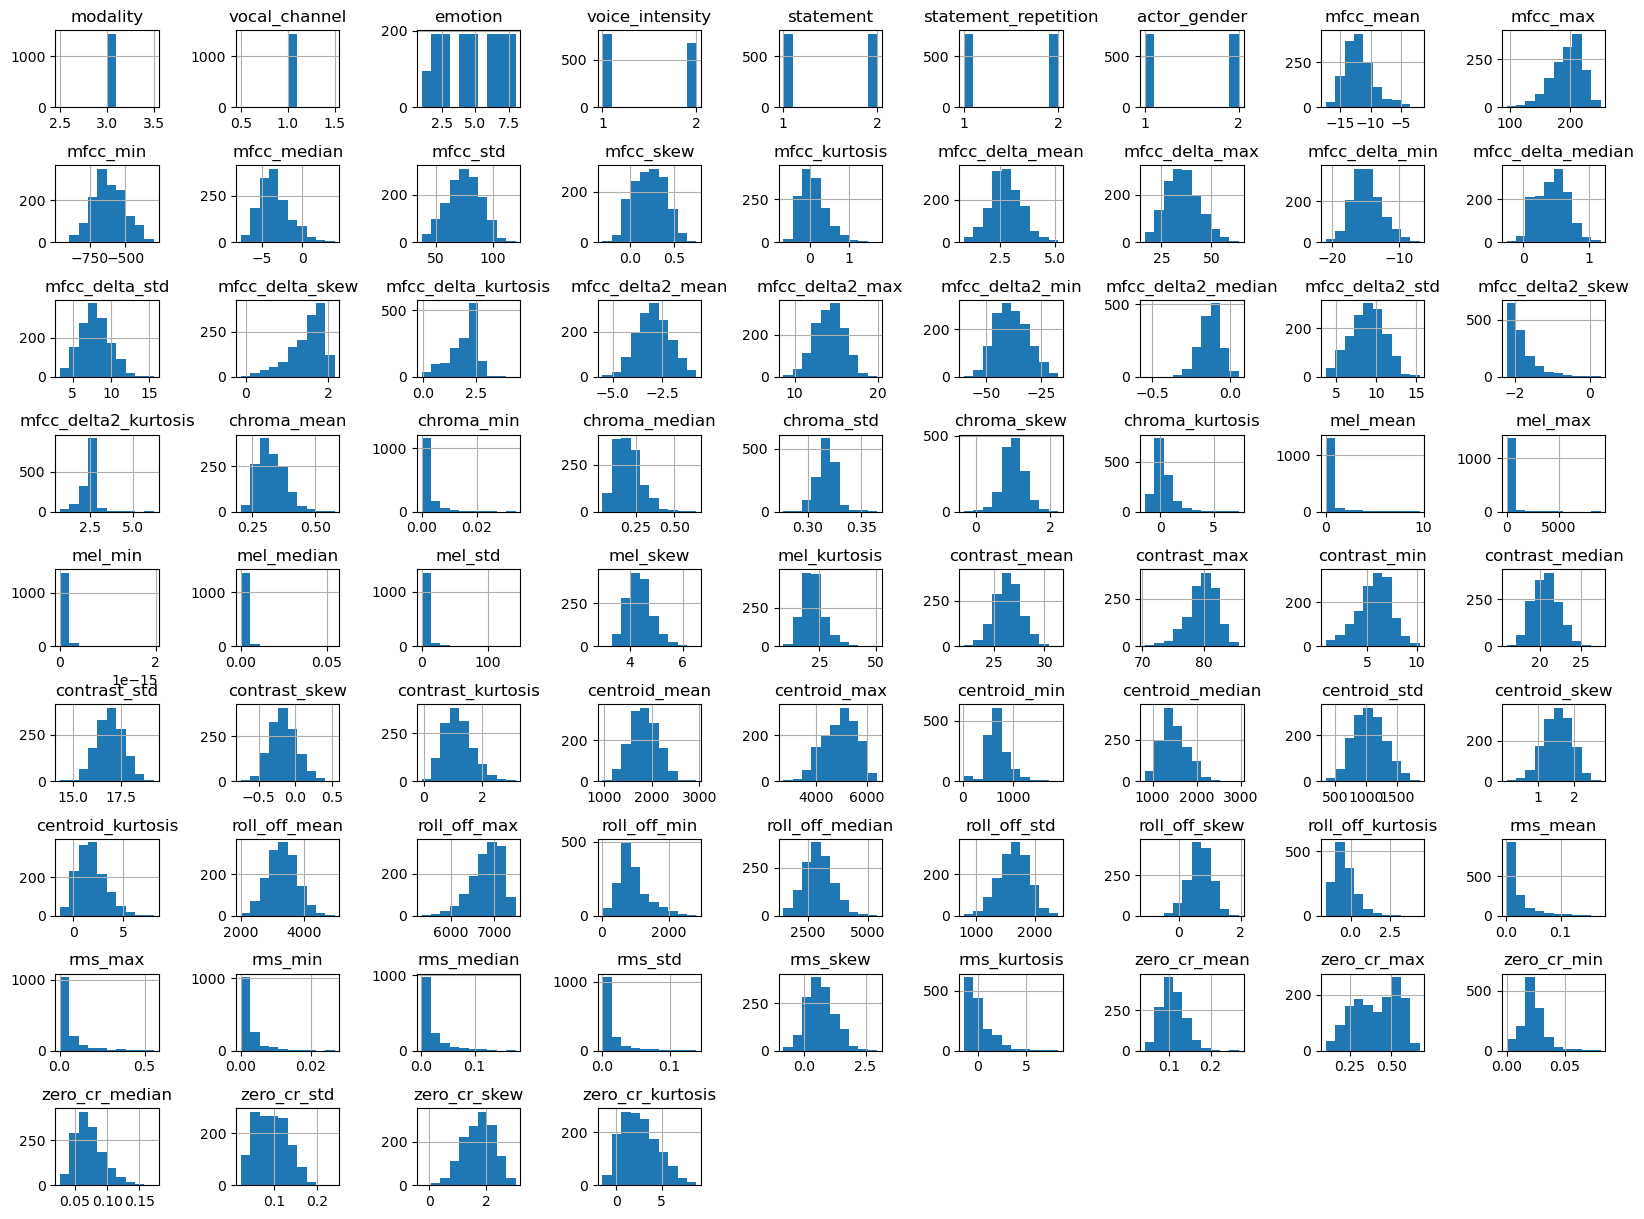

In [4]:
df.hist(figsize=(20,15))
plt.subplots_adjust(hspace=0.75, wspace=0.75);

# Exploring features with models<a id='Exploring_features_with_models'></a>

## Random Forest Classifier<a id='Random_Forest_Classifier'></a>

In [22]:
data1 = pd.read_csv('voice_data_dw.csv')    # RAVDESS data, dw = data wrangling
# data2 = pd.read_csv('voice_data_dw_c.csv')     # CREMA-D data
df = pd.DataFrame(data1)
# df_c = pd.DataFrame(data2)
pd.set_option('display.max_columns', None)
df.head()

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,-13.750966,208.77170,-651.9564,-5.260116,82.799590,-0.140461,-0.240087,2.491733,33.705196,-17.369028,0.262886,8.115748,1.653565,2.387000,-3.528996,13.174137,-39.414215,-0.135289,10.488796,-2.105011,2.833700,0.395015,0.010886,0.312053,0.300928,0.685030,-0.547113,0.009552,2.615224,4.031165e-18,0.000064,0.065616,3.980199,17.590267,25.992423,75.029004,6.442893,19.913183,16.481322,-0.583810,1.214911,1431.463197,3747.965221,581.068512,1153.185402,752.927915,1.652513,1.915730,2639.395255,5961.914062,999.023438,2325.683594,1357.013887,0.948544,-0.035782,0.005870,0.012585,0.001015,0.005574,0.002752,0.523488,-0.223807,0.071506,0.208984,0.023438,0.046875,0.049214,1.349598,0.792986
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,-14.013200,203.44556,-647.6516,-5.660081,83.142610,-0.055090,-0.332986,2.484158,33.476566,-16.323960,0.169552,8.183585,1.682235,2.384677,-3.587220,12.778202,-41.543182,-0.156874,10.659009,-2.112810,2.841899,0.372111,0.007602,0.275195,0.309303,0.783203,-0.390124,0.010960,2.218609,3.065071e-18,0.000057,0.074393,3.737703,14.996470,26.730421,75.095133,5.744724,21.058785,16.718861,-0.121057,2.233361,1428.133969,3787.006232,598.127794,1266.335723,719.014344,1.745676,2.597192,2754.882812,5918.945312,1020.507812,2578.125000,1289.368157,0.814459,0.048691,0.006225,0.013047,0.001003,0.005672,0.003002,0.472005,-0.447499,0.063912,0.183105,0.019531,0.048340,0.042300,1.347601,0.843776
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,-13.286643,212.63199,-603.8165,-5.457789,80.696570,-0.069167,-0.244607,2.352925,30.742325,-17.451830,0.207793,7.844898,1.603152,2.356841,-3.394885,11.864449,-39.883760,-0.110547,10.175233,-2.084090,2.802068,0.365138,0.006354,0.270417,0.299614,0.818134,-0.119496,0.015128,2.815824,4.134282e-18,0.000086,0.100440,3.830205,16.569090,26.321257,79.730935,4.494108,20.461424,16.544478,-0.328206,1.317845,1573.538319,4867.721737,537.361416,1173.576030,1054.731555,1.894945,2.580431,2852.647569,6262.695312,945.312500,2529.785156,1511.726106,0.877642,-0.247283,0.007237,0.017973,0.001440,0.006281,0.003825,1.126351,0.754771,0.086652,0.424316,0.014648,0.048340,0.091483,2.158822,4.017514
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,-13.380160,214.31924,-625.3130,-5.920652,81.306900,-0.068310,-0.379298,2.378634,32.634373,-17.722158,0.145714,7.996109,1.636472,2.379754,-3.510836,13.831413,-42.689724,-0.203858,10.426331,-2.097874,2.825182,0.399993,0.012884,0.301367,0.299288,0.811549,-0.325152,0.014019,3.281666,4.709254e-18,0.000072,0.097377,3.622848,14.702682,26.110333,78.056904,4.348983,20.056309,16.610803,-0.369971,1.573650,1564.442378,4695.050625,657.966547,1252.034920,1035.142571,1.732141,1.991167,2855.356070,6241.210938,923.828125,2567.382812,1535.589595,0.797591,-0.433007,0.006781,0.018386,0.001300,0.005872,0.004013,1.583204,1.841371,0.088229,0.406250,0.013184,0.047852,0.093873,1.803562,2.245144
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,-14.227764,217.13522,-693.7061,-4.584452,90.910904,-0.134584,-0

In [64]:
# Load your data        # Archived for later testing
# X_train, X_test, y_train, y_test = load_data(test_size=0.2, mfcc=True, chroma=True, mel=True, centroid=True, roll_off=True, bandwidth=True, tempo=True, energy=True, rms=True, harmonic=True, percussive=True, tonnetz=True)

### Random Forest with CREMA-D<a id='Random_Forest_with_CREMA-D'></a>

In [31]:
df_c.columns

Index(['filename', 'statement', 'emotion', 'sex', 'voice_intensity',
       'mfcc_mean', 'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std',
       'mfcc_skew', 'mfcc_kurtosis', 'mfcc_delta_mean', 'mfcc_delta_max',
       'mfcc_delta_min', 'mfcc_delta_median', 'mfcc_delta_std',
       'mfcc_delta_skew', 'mfcc_delta_kurtosis', 'mfcc_delta2_mean',
       'mfcc_delta2_max', 'mfcc_delta2_min', 'mfcc_delta2_median',
       'mfcc_delta2_std', 'mfcc_delta2_skew', 'mfcc_delta2_kurtosis',
       'chroma_mean', 'chroma_min', 'chroma_median', 'chroma_std',
       'chroma_skew', 'chroma_kurtosis', 'mel_mean', 'mel_max', 'mel_min',
       'mel_median', 'mel_std', 'mel_skew', 'mel_kurtosis', 'contrast_mean',
       'contrast_max', 'contrast_min', 'contrast_median', 'contrast_std',
       'contrast_skew', 'contrast_kurtosis', 'centroid_mean', 'centroid_max',
       'centroid_min', 'centroid_median', 'centroid_std', 'centroid_skew',
       'centroid_kurtosis', 'roll_off_mean', 'roll_off_max', 'roll_off

In [3]:
# defining feature list
feature_list_c = df_c.columns[5:]

In [4]:
# Dividing dataset into genders
df_male_c = df_c[df_c['sex'] == 'male']
df_female_c = df_c[df_c['sex'] == 'female']

# Features and labels for male dataset
X_cm = df_male_c[feature_list_c].values
y_cm = df_male_c['emotion'].values

# Features and labels for female dataset
X_cf = df_female_c[feature_list_c].values
y_cf = df_female_c['emotion'].values

# Splitting the male dataset
X_train_cm, X_test_cm, y_train_cm, y_test_cm = train_test_split(
    X_cm, y_cm, test_size=0.25, random_state=42, shuffle=True, stratify=y_cm)

# Splitting the female dataset
X_train_cf, X_test_cf, y_train_cf, y_test_cf = train_test_split(
    X_cf, y_cf, test_size=0.25, random_state=42, shuffle=True, stratify=y_cf)

# Initialize scalers for male and female datasets
scaler_cm = StandardScaler()
scaler_cf = StandardScaler()

# Scale the male datasets
X_train_cm_sc = scaler_cm.fit_transform(X_train_cm)
X_test_cm_sc = scaler_cm.transform(X_test_cm)

# Scale the female datasets
X_train_cf_sc = scaler_cf.fit_transform(X_train_cf)
X_test_cf_sc = scaler_cf.transform(X_test_cf)

print("Male Dataset:", X_train_cm_sc.shape, X_test_cm_sc.shape, y_train_cm.shape, y_test_cm.shape)
print("Female Dataset:", X_train_cf_sc.shape, X_test_cf_sc.shape, y_train_cf.shape, y_test_cf.shape)

Male Dataset: (2947, 69) (983, 69) (2947,) (983,)
Female Dataset: (2634, 69) (878, 69) (2634,) (878,)


In [5]:
# Training male dataset
rfc_cm = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_features=69, max_depth=15, 
                                    min_samples_leaf=5, min_weight_fraction_leaf=0.0, min_samples_split=5, 
                                    random_state=42, n_jobs=-1, warm_start=True)

rfc_cm.fit(X_train_cm_sc, y_train_cm)

RandomForestClassifier(max_features=30, min_samples_leaf=25,
                       min_samples_split=30, n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [18]:
# Training female dataset
rfc_cf = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_features=69, max_depth=15, 
                                    min_samples_leaf=5, min_weight_fraction_leaf=0.0, min_samples_split=5, 
                                    random_state=42, n_jobs=-1, warm_start=True)

rfc_cf.fit(X_train_cf_sc, y_train_cf)

RandomForestClassifier(max_features=30, min_samples_leaf=25,
                       min_samples_split=30, n_estimators=1000, n_jobs=-1,
                       random_state=42)

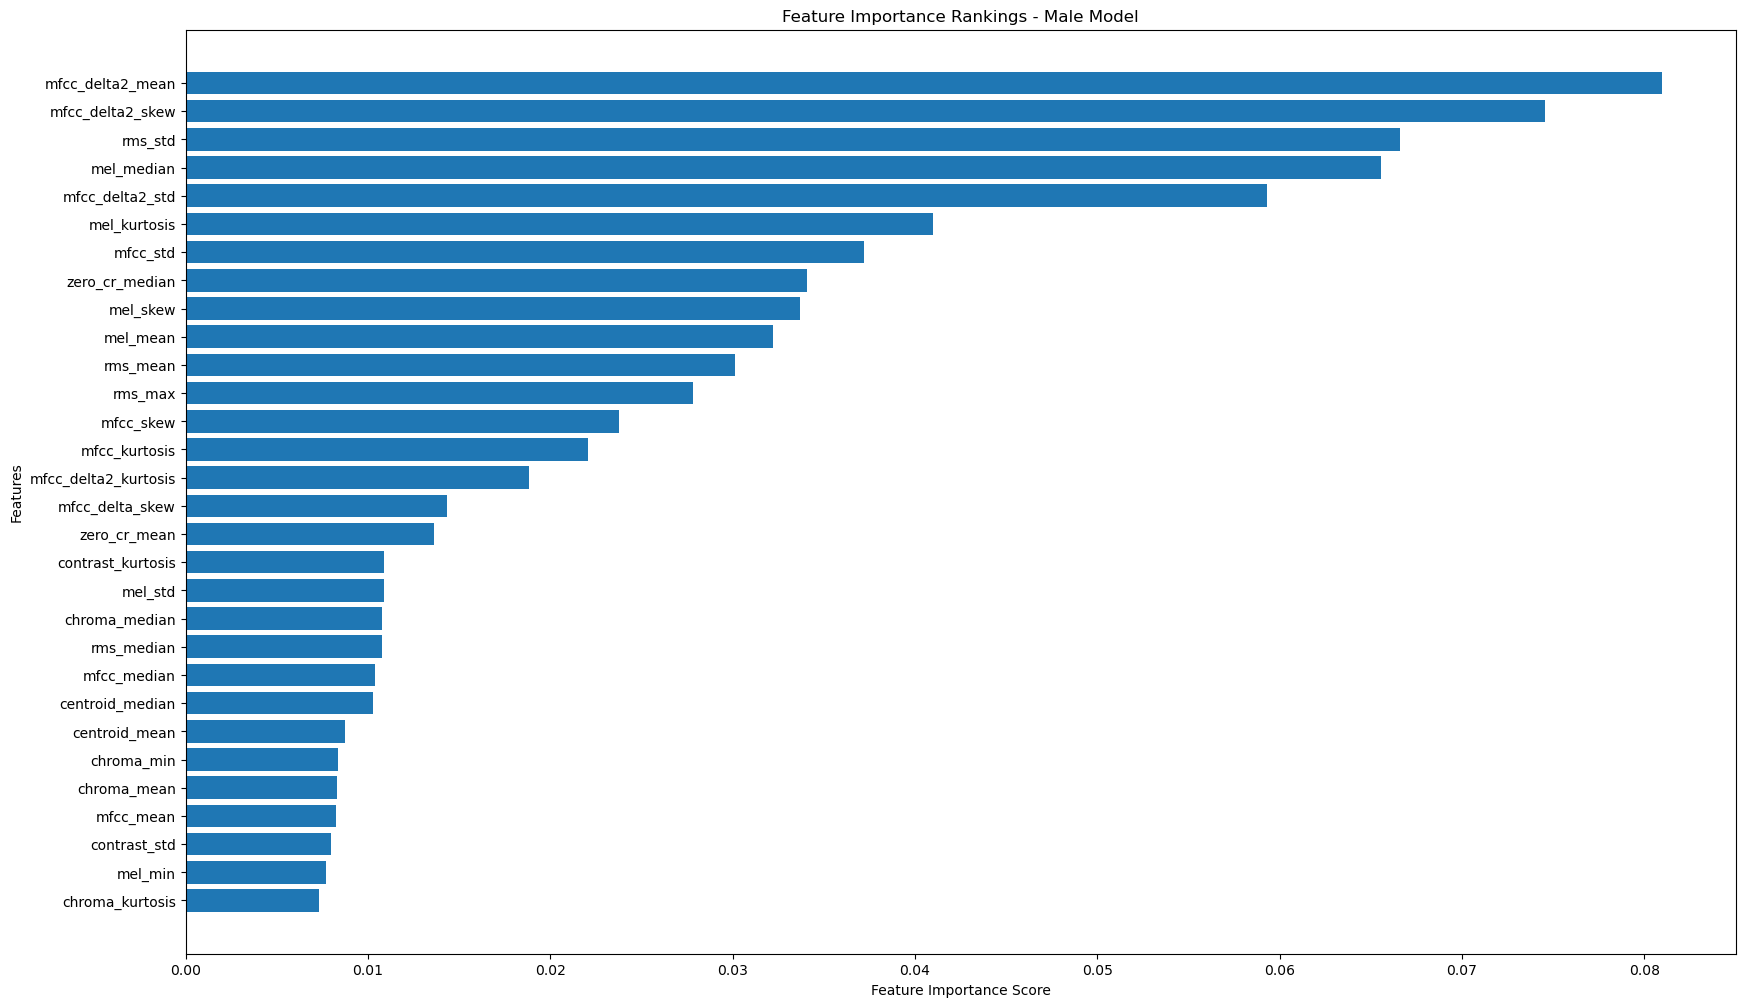

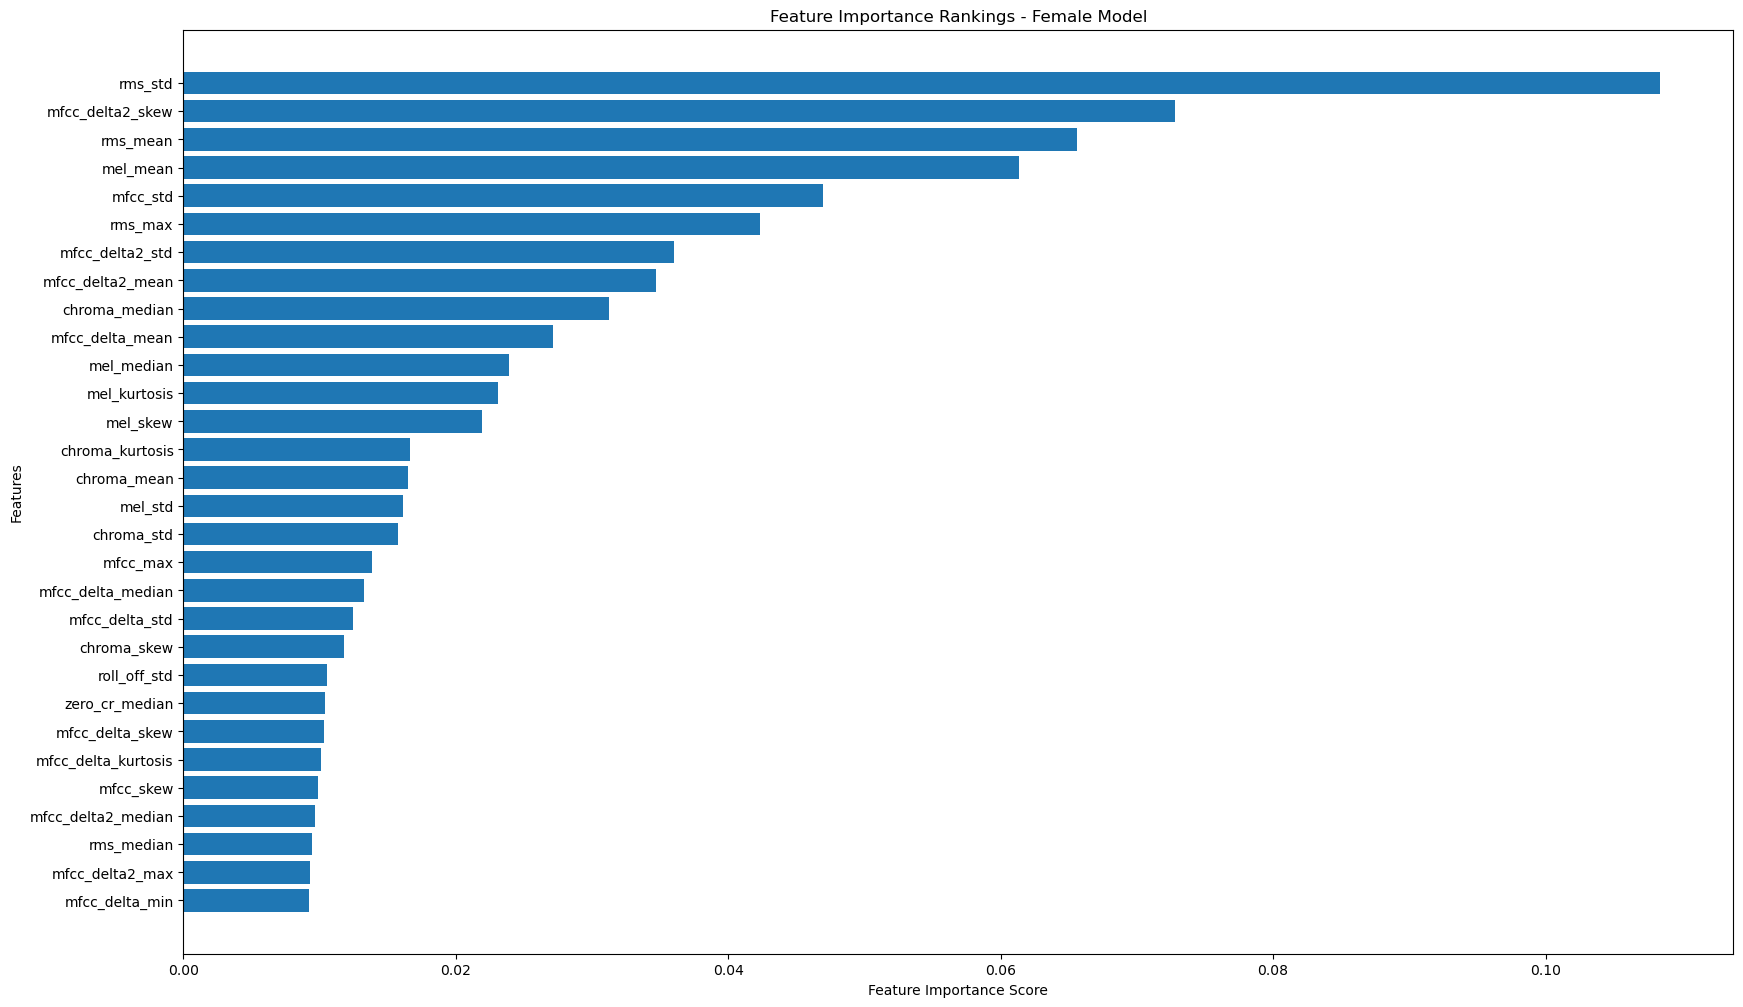

In [19]:
# feature importance for Random Forest model
feature_importances_cm = rfc_cm.feature_importances_
feature_importances_cf = rfc_cf.feature_importances_

# Features used in current model
feature_names_cm = feature_list_c
feature_names_cf = feature_list_c

# Creating dictionaries to map feature names to their importances for each model
importances_cm = dict(zip(feature_names_cm, feature_importances_cm))
importances_cf = dict(zip(feature_names_cf, feature_importances_cf))

# Function to plot feature importances and return top 30 features
def plot_feature_importances_and_get_top_30_c(importances, title):
    # Sort features by importance
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract feature names and scores
    sorted_features = [x[0] for x in sorted_importances]
    sorted_scores = [x[1] for x in sorted_importances]

    # Plot
    plt.figure(figsize=(20, 12))
    plt.barh(sorted_features[:30], sorted_scores[:30])  # Plot only top 30 features
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

    # Return top 30 features
    return sorted_features[:30]

# Get and plot top 30 features for male model
top_30_features_cm = plot_feature_importances_and_get_top_30_c(importances_cm, 'Feature Importance Rankings - Male Model')

# Get and plot top 30 features for male model
top_30_features_cf = plot_feature_importances_and_get_top_30_c(importances_cf, 'Feature Importance Rankings - Female Model')

In [20]:
# Predict on the test set
y_pred_cm = rfc_cm.predict(X_test_cm_sc)
y_pred_cf = rfc_cf.predict(X_test_cf_sc)

In [21]:
# Evaluate the male model
accuracy_cm = accuracy_score(y_test_cm, y_pred_cm)
accuracy_cf = accuracy_score(y_test_cf, y_pred_cf)

print(confusion_matrix(y_test_cm, y_pred_cm))
print(classification_report(y_test_cm, y_pred_cm))
print(f"Accuracy for male RandomForest CREMA model: {accuracy_cm}")
print()
print()
print(confusion_matrix(y_test_cf, y_pred_cf))
print(classification_report(y_test_cf, y_pred_cf))
print(f"Accuracy for female RandomForest CREMA model: {accuracy_cf}")

[[121   6  12   2  23   4]
 [  1  83  14   3  20  22]
 [ 19  26  50   6  28  39]
 [ 18  30  13  21  34  52]
 [ 25  26  13  12  85   7]
 [  1  32  11  10   4 110]]
              precision    recall  f1-score   support

       anger       0.65      0.72      0.69       168
        calm       0.41      0.58      0.48       143
     disgust       0.44      0.30      0.36       168
     fearful       0.39      0.12      0.19       168
       happy       0.44      0.51      0.47       168
         sad       0.47      0.65      0.55       168

    accuracy                           0.48       983
   macro avg       0.47      0.48      0.45       983
weighted avg       0.47      0.48      0.45       983

Accuracy for male RandomForest CREMA model: 0.47812817904374366


[[107   6   6   5  26   0]
 [  0  74  17   4  10  23]
 [ 16  40  40   3  20  31]
 [ 13  24   9  42  32  30]
 [ 35  25   7  11  70   2]
 [  0  34  10   5   3  98]]
              precision    recall  f1-score   support

       ang

### Random Forest with RAVDESS<a id='Random_Forest_with_RAVDESS'></a>

In [23]:
def emotion_to_string(e):
    if e % 8 == 1:
        return 'neutral'
    elif e % 8 == 2:
        return 'calm'
    elif e % 8 == 3:
        return 'happy'
    elif e % 8 == 4:
        return 'sad'
    elif e % 8 == 5:
        return 'angry'
    elif e % 8 == 6:
        return 'fearful'
    elif e % 8 == 7:
        return 'disgust'
    else:
        return 'surprised'

# Applying the function to the 'emotion' column
df['emotion'] = df['emotion'].apply(emotion_to_string)

In [45]:
# feature_male = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta_median', 'mfcc_delta2_mean', 'mfcc_delta2_min', 
#                 'chroma_mean', 'mel_mean', 'mel_median', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 
#                 'rms_mean', 'zero_cr_mean']
# feature_female = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 
#                   'mel_median', 'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
#                   'rms_mean', 'zero_cr_mean']

In [25]:
# defining feature list
feature_list = df.columns[8:]

In [26]:
# Dividing dataset into genders
df_male = df[df['actor_gender'] == 1]
df_female = df[df['actor_gender'] == 2]

# Removing 'neutral' category
df_male = df_male[df_male['emotion'] != 'neutral']
df_female = df_female[df_female['emotion'] != 'neutral']

# Features and labels for male dataset
X_male = df_male[feature_male].values
y_male = df_male['emotion'].values

# Features and labels for female dataset
X_female = df_female[feature_female].values
y_female = df_female['emotion'].values

# Splitting the male dataset
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(
    X_male, y_male, test_size=0.25, random_state=42, shuffle=True, stratify=y_male)

# Splitting the female dataset
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(
    X_female, y_female, test_size=0.25, random_state=42, shuffle=True, stratify=y_female)

# Initialize scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_m_sc = scaler_male.fit_transform(X_train_male)
X_test_m_sc = scaler_male.transform(X_test_male)

# Scale the female datasets
X_train_f_sc = scaler_female.fit_transform(X_train_female)
X_test_f_sc = scaler_female.transform(X_test_female)

print("Male Dataset:", X_train_m_sc.shape, X_test_m_sc.shape, y_train_male.shape, y_test_male.shape)
print("Female Dataset:", X_train_f_sc.shape, X_test_f_sc.shape, y_train_female.shape, y_test_female.shape)

Male Dataset: (504, 69) (168, 69) (504,) (168,)
Female Dataset: (504, 69) (168, 69) (504,) (168,)


In [27]:
# Training male dataset
model_male = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_features=69, max_depth=15, 
                                    min_samples_leaf=5, min_weight_fraction_leaf=0.0, min_samples_split=5, 
                                    random_state=42, n_jobs=-1, warm_start=True)

model_male.fit(X_train_m_sc, y_train_male)

RandomForestClassifier(max_features=20, min_samples_leaf=15, n_estimators=1000,
                       n_jobs=-1, random_state=42)

In [28]:
# Training female dataset
model_female = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_features=69, max_depth=15, 
                                    min_samples_leaf=5, min_weight_fraction_leaf=0.0, min_samples_split=5, 
                                    random_state=42, n_jobs=-1, warm_start=True)

model_female.fit(X_train_f_sc, y_train_female)

RandomForestClassifier(max_features=20, min_samples_leaf=15, n_estimators=1000,
                       n_jobs=-1, random_state=42)

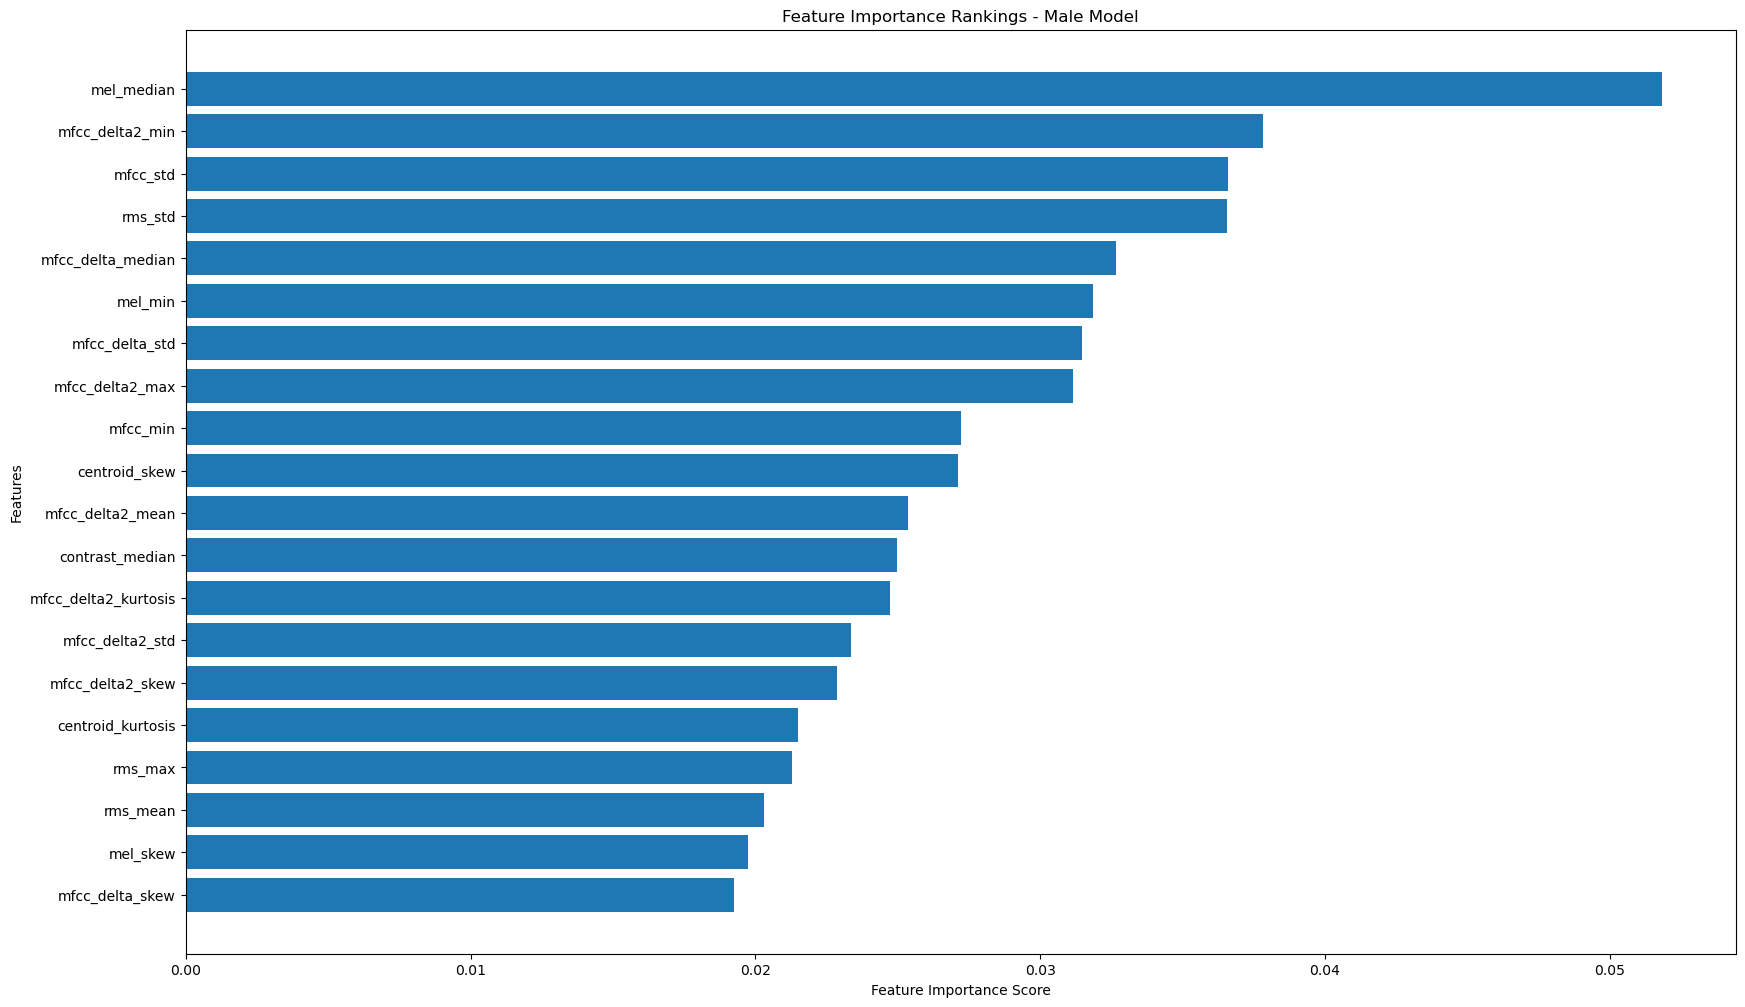

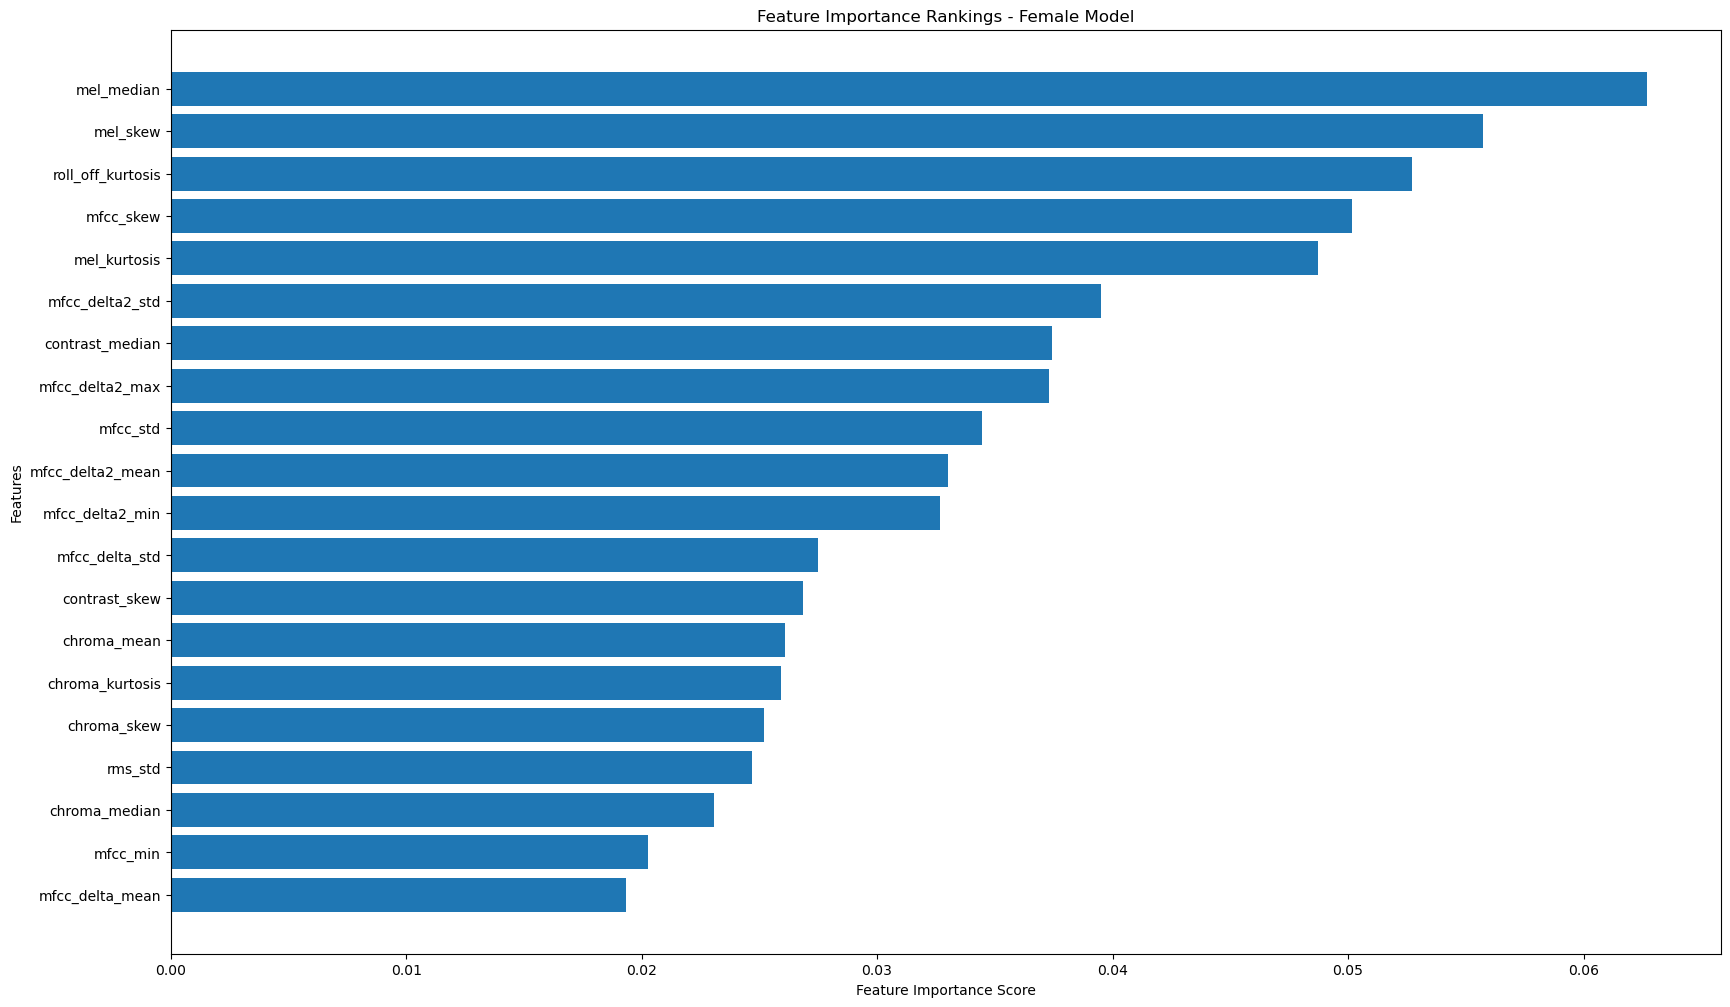

In [29]:
# 'model_male' and 'model_female' are the trained Random Forest models
feature_importances_male = model_male.feature_importances_
feature_importances_female = model_female.feature_importances_

# Update this list to match the features used in your current model
feature_names_m = feature_male
feature_names_f = feature_female

# Creating dictionaries to map feature names to their importances for each model
importances_male = dict(zip(feature_names_m, feature_importances_male))
importances_female = dict(zip(feature_names_f, feature_importances_female))

# Function to plot feature importances and return top 20 features
def plot_feature_importances_and_get_top_20(importances, title):
    # Sort features by importance
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract feature names and scores
    sorted_features = [x[0] for x in sorted_importances]
    sorted_scores = [x[1] for x in sorted_importances]

    # Plot
    plt.figure(figsize=(20, 12))
    plt.barh(sorted_features[:20], sorted_scores[:20])  # Plot only top 20 features
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

    # Return top 20 features
    return sorted_features[:20]

# Get and plot top 20 features for male model
top_20_features_male = plot_feature_importances_and_get_top_20(importances_male, 'Feature Importance Rankings - Male Model')

# Get and plot top 20 features for female model
top_20_features_female = plot_feature_importances_and_get_top_20(importances_female, 'Feature Importance Rankings - Female Model')


In [16]:
# Predict on the test set
y_pred_male = model_male.predict(X_test_m_sc)
y_pred_female = model_female.predict(X_test_f_sc)

In [17]:
# Evaluate the models
accuracy_male = accuracy_score(y_test_male, y_pred_male)
accuracy_female = accuracy_score(y_test_female, y_pred_female)

print(confusion_matrix(y_test_male, y_pred_male))
print(classification_report(y_test_male, y_pred_male))
print(f"Accuracy for Male Model: {accuracy_male}")
print()
print()
print(confusion_matrix(y_test_female, y_pred_female))
print(classification_report(y_test_female, y_pred_female))
print(f"Accuracy for Female Model: {accuracy_female}")

Accuracy for Male Model: 0.5476190476190477
              precision    recall  f1-score   support

       angry       0.67      0.75      0.71        24
        calm       0.56      0.92      0.70        24
     disgust       0.69      0.75      0.72        24
     fearful       0.70      0.29      0.41        24
       happy       0.43      0.38      0.40        24
         sad       0.31      0.21      0.25        24
   surprised       0.45      0.54      0.49        24

    accuracy                           0.55       168
   macro avg       0.54      0.55      0.53       168
weighted avg       0.54      0.55      0.53       168

Accuracy for Female Model: 0.47023809523809523
              precision    recall  f1-score   support

       angry       0.52      0.58      0.55        24
        calm       0.61      0.71      0.65        24
     disgust       0.50      0.33      0.40        24
     fearful       0.36      0.42      0.38        24
       happy       0.32      0.29      0.

## Gradient Boosting<a id='Gradient_Boosting'></a>

In [3]:
data = pd.read_csv('voice_data_dw.csv')    # RAVDESS data, dw = data wrangling
# data = pd.read_csv('voice_data_dw_c.csv')     # CREMA-D data
df = pd.DataFrame(data)
pd.set_option('display.max_columns', None)
df.head()

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,-13.750966,208.77170,-651.9564,-5.260116,82.799590,-0.140461,-0.240087,2.491733,33.705196,-17.369028,0.262886,8.115748,1.653565,2.387000,-3.528996,13.174137,-39.414215,-0.135289,10.488796,-2.105011,2.833700,0.395015,0.010886,0.312053,0.300928,0.685030,-0.547113,0.009552,2.615224,4.031165e-18,0.000064,0.065616,3.980199,17.590267,25.992423,75.029004,6.442893,19.913183,16.481322,-0.583810,1.214911,1431.463197,3747.965221,581.068512,1153.185402,752.927915,1.652513,1.915730,2639.395255,5961.914062,999.023438,2325.683594,1357.013887,0.948544,-0.035782,0.005870,0.012585,0.001015,0.005574,0.002752,0.523488,-0.223807,0.071506,0.208984,0.023438,0.046875,0.049214,1.349598,0.792986
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,-14.013200,203.44556,-647.6516,-5.660081,83.142610,-0.055090,-0.332986,2.484158,33.476566,-16.323960,0.169552,8.183585,1.682235,2.384677,-3.587220,12.778202,-41.543182,-0.156874,10.659009,-2.112810,2.841899,0.372111,0.007602,0.275195,0.309303,0.783203,-0.390124,0.010960,2.218609,3.065071e-18,0.000057,0.074393,3.737703,14.996470,26.730421,75.095133,5.744724,21.058785,16.718861,-0.121057,2.233361,1428.133969,3787.006232,598.127794,1266.335723,719.014344,1.745676,2.597192,2754.882812,5918.945312,1020.507812,2578.125000,1289.368157,0.814459,0.048691,0.006225,0.013047,0.001003,0.005672,0.003002,0.472005,-0.447499,0.063912,0.183105,0.019531,0.048340,0.042300,1.347601,0.843776
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,-13.286643,212.63199,-603.8165,-5.457789,80.696570,-0.069167,-0.244607,2.352925,30.742325,-17.451830,0.207793,7.844898,1.603152,2.356841,-3.394885,11.864449,-39.883760,-0.110547,10.175233,-2.084090,2.802068,0.365138,0.006354,0.270417,0.299614,0.818134,-0.119496,0.015128,2.815824,4.134282e-18,0.000086,0.100440,3.830205,16.569090,26.321257,79.730935,4.494108,20.461424,16.544478,-0.328206,1.317845,1573.538319,4867.721737,537.361416,1173.576030,1054.731555,1.894945,2.580431,2852.647569,6262.695312,945.312500,2529.785156,1511.726106,0.877642,-0.247283,0.007237,0.017973,0.001440,0.006281,0.003825,1.126351,0.754771,0.086652,0.424316,0.014648,0.048340,0.091483,2.158822,4.017514
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,-13.380160,214.31924,-625.3130,-5.920652,81.306900,-0.068310,-0.379298,2.378634,32.634373,-17.722158,0.145714,7.996109,1.636472,2.379754,-3.510836,13.831413,-42.689724,-0.203858,10.426331,-2.097874,2.825182,0.399993,0.012884,0.301367,0.299288,0.811549,-0.325152,0.014019,3.281666,4.709254e-18,0.000072,0.097377,3.622848,14.702682,26.110333,78.056904,4.348983,20.056309,16.610803,-0.369971,1.573650,1564.442378,4695.050625,657.966547,1252.034920,1035.142571,1.732141,1.991167,2855.356070,6241.210938,923.828125,2567.382812,1535.589595,0.797591,-0.433007,0.006781,0.018386,0.001300,0.005872,0.004013,1.583204,1.841371,0.088229,0.406250,0.013184,0.047852,0.093873,1.803562,2.245144
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,-14.227764,217.13522,-693.7061,-4.584452,90.910904,-0.134584,-0

### Gradient Boosting with CREMA-D<a id='Gradient_Boosting_with_CREMA-D'></a>

In [65]:
feature_list = df.columns[4:]

In [66]:
# Features and labels for male dataset
X = df[feature_list].values
y = df['emotion'].values

# Splitting the male dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)

# Initialize scalers for male and female datasets
scaler = StandardScaler()

# Scale the male datasets
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

print("Dataset shape:", X_train_sc.shape, X_test_sc.shape, y_train.shape, y_test.shape)

Dataset shape: (5581, 69) (1861, 69) (5581,) (1861,)


In [67]:
# Initialize the Gradient Boosting Classifier and train the model
# best result: 0.6845238095238095
# n_estimators=500, learning_rate=0.1, max_depth=6, min_samples_split=20, 
#                                          min_samples_leaf=15, max_features=20, random_state=42

gb_clf_c = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, min_samples_split=20, 
                                         min_samples_leaf=15, max_features=20, random_state=42)
gb_clf_c.fit(X_train_sc, y_train)

GradientBoostingClassifier(max_depth=6, max_features=20, min_samples_leaf=15,
                           min_samples_split=20, n_estimators=500,
                           random_state=42)

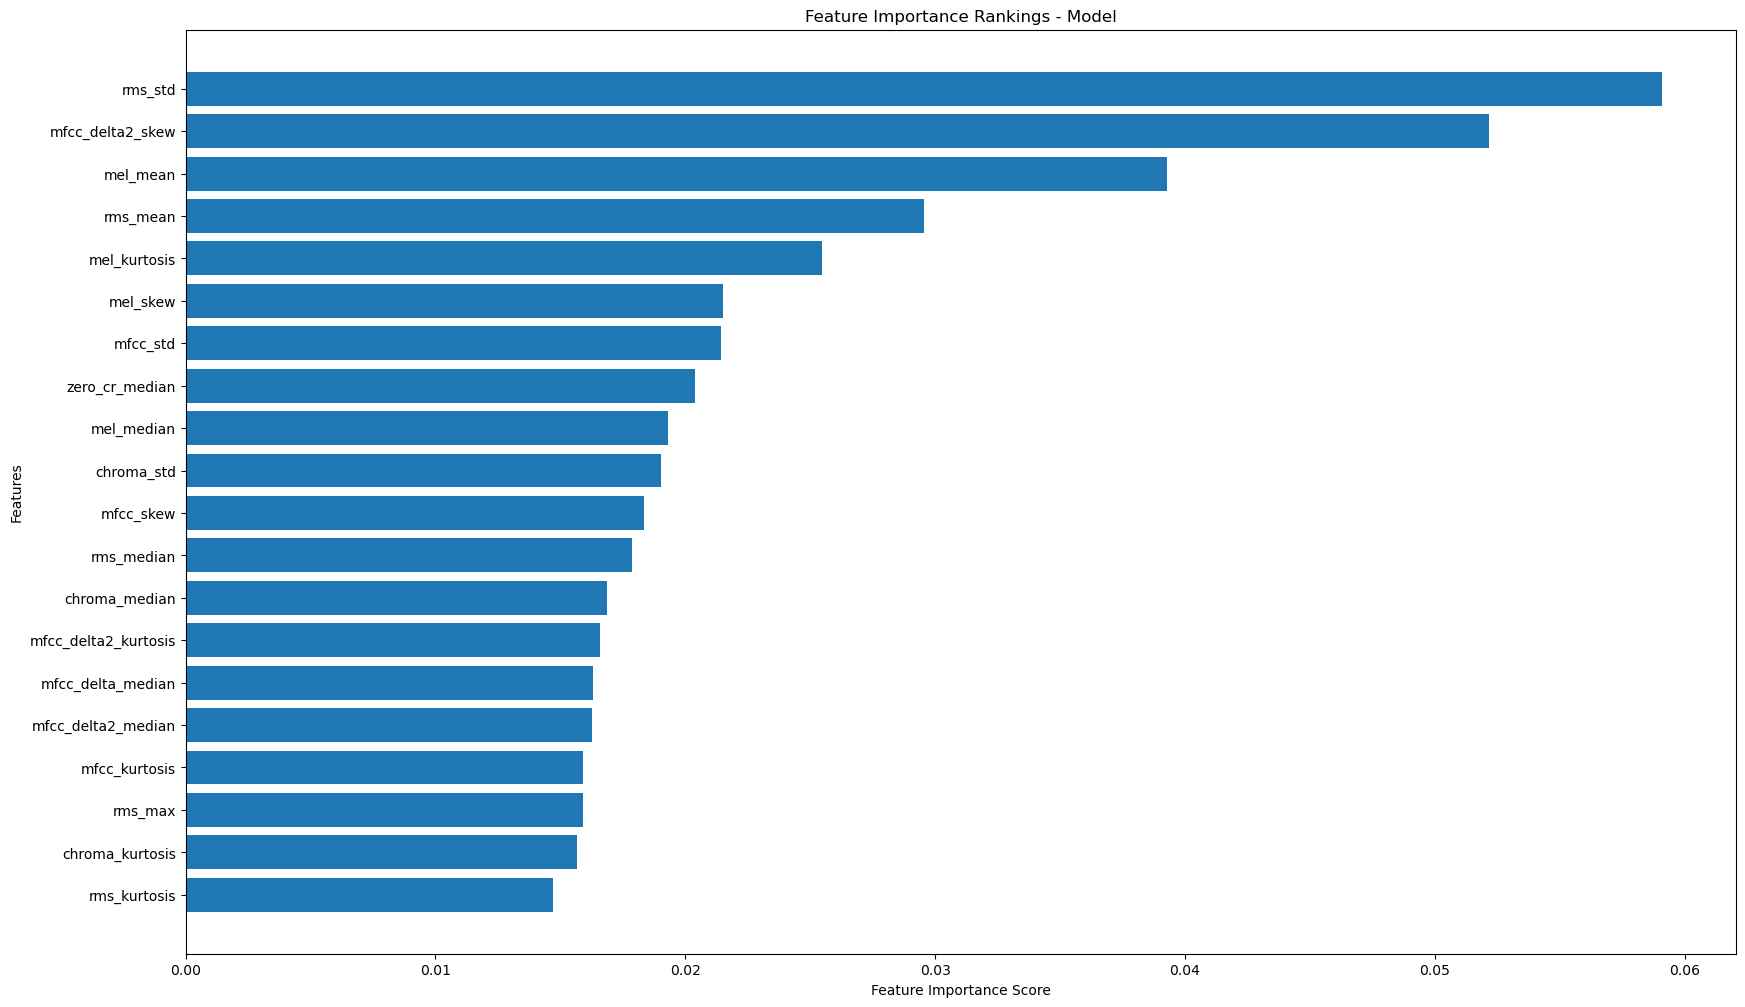

In [70]:
# 'model_male' and 'model_female' are the trained Random Forest models
gb_feature_importances_c = gb_clf_c.feature_importances_

# Update this list to match the features used in your current model
gb_feature_c = feature_list

# Creating dictionaries to map feature names to their importances for each model
gb_importances_c = dict(zip(gb_feature_c, gb_feature_importances_c))

# Function to plot feature importances and return top 20 features
def plot_gb_feature_importances_and_get_top_20(importances, title):
    # Sort features by importance
    gb_sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract feature names and scores
    gb_sorted_features = [x[0] for x in gb_sorted_importances]
    gb_sorted_scores = [x[1] for x in gb_sorted_importances]

    # Plot
    plt.figure(figsize=(20, 12))
    plt.barh(gb_sorted_features[:20], gb_sorted_scores[:20])  # Plot only top 20 features
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

    # Return top 20 features
    return gb_sorted_features[:20]

# Get and plot top 20 features for male model
gb_top_20_features_c = plot_gb_feature_importances_and_get_top_20(gb_importances_c, 'Feature Importance Rankings - Model')


In [71]:
# Predict on the test set
y_pred_c = gb_clf_c.predict(X_test_sc)

In [72]:
# Evaluate the models
accuracy_c = accuracy_score(y_test, y_pred_c)

print("\nConfusion Matrix for Male Model:")
print(confusion_matrix(y_test, gb_clf_c.predict(X_test_sc)))
print(classification_report(y_test, y_pred_c))
print(f"Accuracy for Male Model: {accuracy_c}")


Confusion Matrix for Male Model:
[[219   6  36  18  36   3]
 [  5 137  46  19  22  42]
 [ 35  41 122  24  42  54]
 [ 25  30  29 117  51  66]
 [ 56  30  29  38 156   9]
 [  2  46  33  33   7 197]]
              precision    recall  f1-score   support

       anger       0.64      0.69      0.66       318
        calm       0.47      0.51      0.49       271
     disgust       0.41      0.38      0.40       318
     fearful       0.47      0.37      0.41       318
       happy       0.50      0.49      0.49       318
         sad       0.53      0.62      0.57       318

    accuracy                           0.51      1861
   macro avg       0.50      0.51      0.50      1861
weighted avg       0.50      0.51      0.51      1861

Accuracy for Male Model: 0.5094035464803869


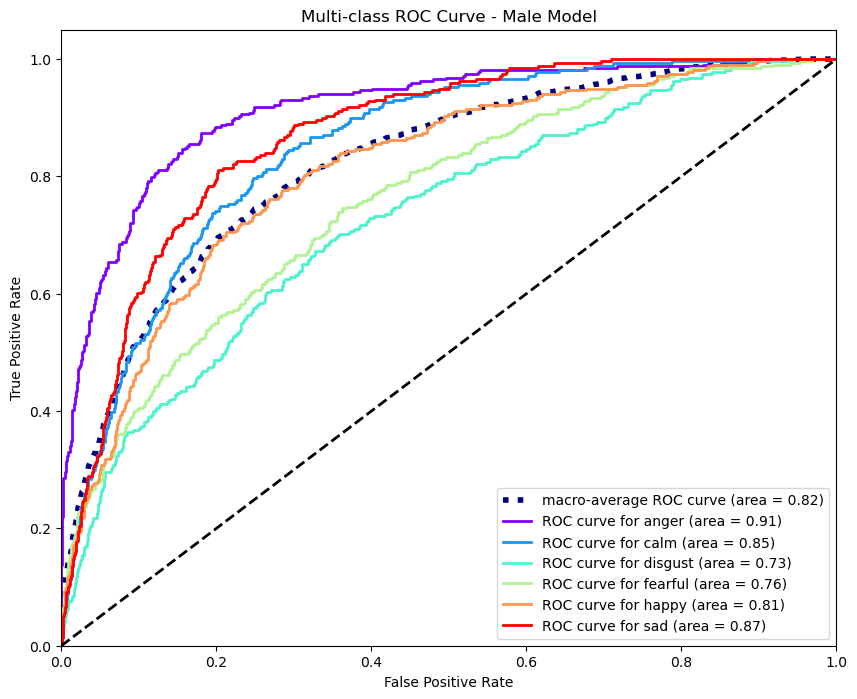

In [76]:
# Define the emotion classes
emotion_classes_c = gb_clf_c.classes_

# Binarize the labels for the male dataset
y_test_c_binarized = label_binarize(y_test, classes=emotion_classes_c)
n_classes_c = y_test_c_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr_c = dict()
tpr_c = dict()
roc_auc_c = dict()

y_prob = gb_clf_c.predict_proba(X_test_sc)

for i in range(n_classes_c):
    fpr_c[i], tpr_c[i], _ = roc_curve(y_test_c_binarized[:, i], y_prob[:, i])
    roc_auc_c[i] = auc(fpr_c[i], tpr_c[i])

# Compute micro-average ROC curve and ROC area
fpr_c["micro"], tpr_c["micro"], _ = roc_curve(y_test_c_binarized.ravel(), y_prob.ravel())
roc_auc_c["micro"] = auc(fpr_c["micro"], tpr_c["micro"])

# Aggregate all false positive rates
all_fpr_c = np.unique(np.concatenate([fpr_c[i] for i in range(n_classes_c)]))

# Interpolate all ROC curves at these points
mean_tpr_c = np.zeros_like(all_fpr_c)
for i in range(n_classes_c):
    mean_tpr_c += np.interp(all_fpr_c, fpr_c[i], tpr_c[i])

# Average it and compute AUC
mean_tpr_c /= n_classes_c

fpr_c["macro"] = all_fpr_c
tpr_c["macro"] = mean_tpr_c
roc_auc_c["macro"] = auc(fpr_c["macro"], tpr_c["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot macro-average ROC curve
plt.plot(fpr_c["macro"], tpr_c["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_c["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes_c)))
for i, color in zip(range(n_classes_c), colors):
    plt.plot(fpr_c[i], tpr_c[i], color=color, lw=2,
             label='ROC curve for {0} (area = {1:0.2f})'.format(emotion_classes_c[i], roc_auc_c[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Male Model')
plt.legend(loc="lower right")
plt.show()

### Gradient Boosting with RAVDESS<a id='Gradient_Boosting_with_RAVDESS'></a>

In [4]:
def emotion_to_string(e):
    if e % 8 == 1:
        return 'neutral'
    elif e % 8 == 2:
        return 'calm'
    elif e % 8 == 3:
        return 'happy'
    elif e % 8 == 4:
        return 'sad'
    elif e % 8 == 5:
        return 'angry'
    elif e % 8 == 6:
        return 'fearful'
    elif e % 8 == 7:
        return 'disgust'
    else:
        return 'surprised'

# Applying the function to the 'emotion' column
df['emotion'] = df['emotion'].apply(emotion_to_string)

In [141]:
df.columns

Index(['filename', 'modality', 'vocal_channel', 'emotion', 'voice_intensity',
       'statement', 'statement_repetition', 'actor_gender', 'mfcc_mean',
       'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std', 'mfcc_skew',
       'mfcc_kurtosis', 'mfcc_delta_mean', 'mfcc_delta_max', 'mfcc_delta_min',
       'mfcc_delta_median', 'mfcc_delta_std', 'mfcc_delta_skew',
       'mfcc_delta_kurtosis', 'mfcc_delta2_mean', 'mfcc_delta2_max',
       'mfcc_delta2_min', 'mfcc_delta2_median', 'mfcc_delta2_std',
       'mfcc_delta2_skew', 'mfcc_delta2_kurtosis', 'chroma_mean', 'chroma_min',
       'chroma_max', 'chroma_median', 'chroma_std', 'chroma_skew',
       'chroma_kurtosis', 'mel_mean', 'mel_max', 'mel_min', 'mel_median',
       'mel_std', 'mel_skew', 'mel_kurtosis', 'contrast_mean', 'contrast_max',
       'contrast_min', 'contrast_median', 'contrast_std', 'contrast_skew',
       'contrast_kurtosis', 'centroid_mean', 'centroid_max', 'centroid_min',
       'centroid_median', 'centroid_std', 'cen

In [5]:
feature_list = df.columns[8:]

In [6]:
# Dividing dataset into genders
df_male = df[df['actor_gender'] == 1]
df_female = df[df['actor_gender'] == 2]

# Removing 'neutral' category
df_male = df_male[df_male['emotion'] != 'neutral']
df_female = df_female[df_female['emotion'] != 'neutral']

# Features and labels for male dataset
X_male = df_male[feature_list].values
y_male = df_male['emotion'].values

# Features and labels for female dataset
X_female = df_female[feature_list].values
y_female = df_female['emotion'].values

# Splitting the male dataset
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(
    X_male, y_male, test_size=0.25, random_state=42, shuffle=True, stratify=y_male)

# Splitting the female dataset
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(
    X_female, y_female, test_size=0.25, random_state=42, shuffle=True, stratify=y_female)

# Initialize scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_m_sc = scaler_male.fit_transform(X_train_male)
X_test_m_sc = scaler_male.transform(X_test_male)

# Scale the female datasets
X_train_f_sc = scaler_female.fit_transform(X_train_female)
X_test_f_sc = scaler_female.transform(X_test_female)

print("Male Dataset:", X_train_m_sc.shape, X_test_m_sc.shape, y_train_male.shape, y_test_male.shape)
print("Female Dataset:", X_train_f_sc.shape, X_test_f_sc.shape, y_train_female.shape, y_test_female.shape)

Male Dataset: (504, 69) (168, 69) (504,) (168,)
Female Dataset: (504, 69) (168, 69) (504,) (168,)


In [7]:
# Initialize the Gradient Boosting Classifier and train the model
# best result: 0.6845238095238095
# n_estimators=500, learning_rate=0.1, max_depth=6, min_samples_split=20, 
#                                          min_samples_leaf=15, max_features=20, random_state=42

gb_clf_male = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, min_samples_split=20, 
                                         min_samples_leaf=15, max_features=20, random_state=42)
gb_clf_male.fit(X_train_m_sc, y_train_male)

GradientBoostingClassifier(max_depth=6, max_features=20, min_samples_leaf=15,
                           min_samples_split=20, n_estimators=500,
                           random_state=42)

In [8]:
# Initialize the Gradient Boosting Classifier and train the model
# best result: 0.6547619047619048
# n_estimators=500, learning_rate=0.1, max_depth=6, min_samples_split=20, 
#                                          min_samples_leaf=15, max_features=20, random_state=42

gb_clf_female = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, min_samples_split=20, 
                                           min_samples_leaf=15, max_features=20, random_state=42)
gb_clf_female.fit(X_train_f_sc, y_train_female)

GradientBoostingClassifier(max_depth=6, max_features=20, min_samples_leaf=15,
                           min_samples_split=20, n_estimators=500,
                           random_state=42)

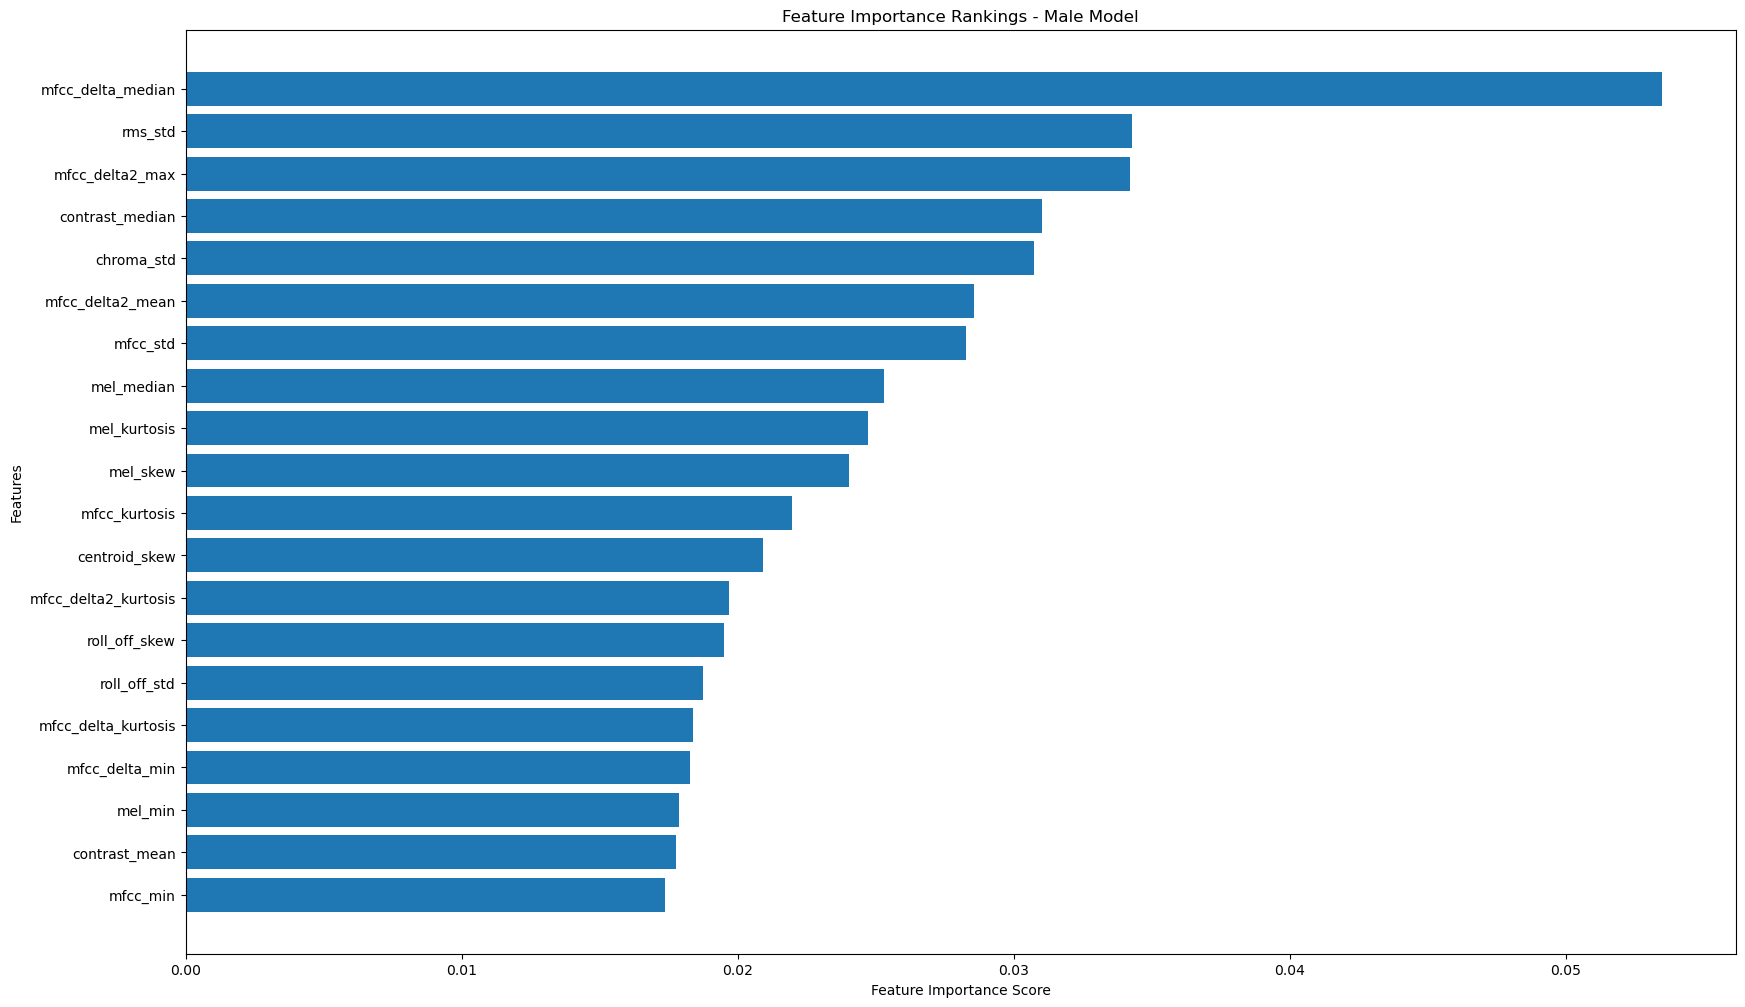

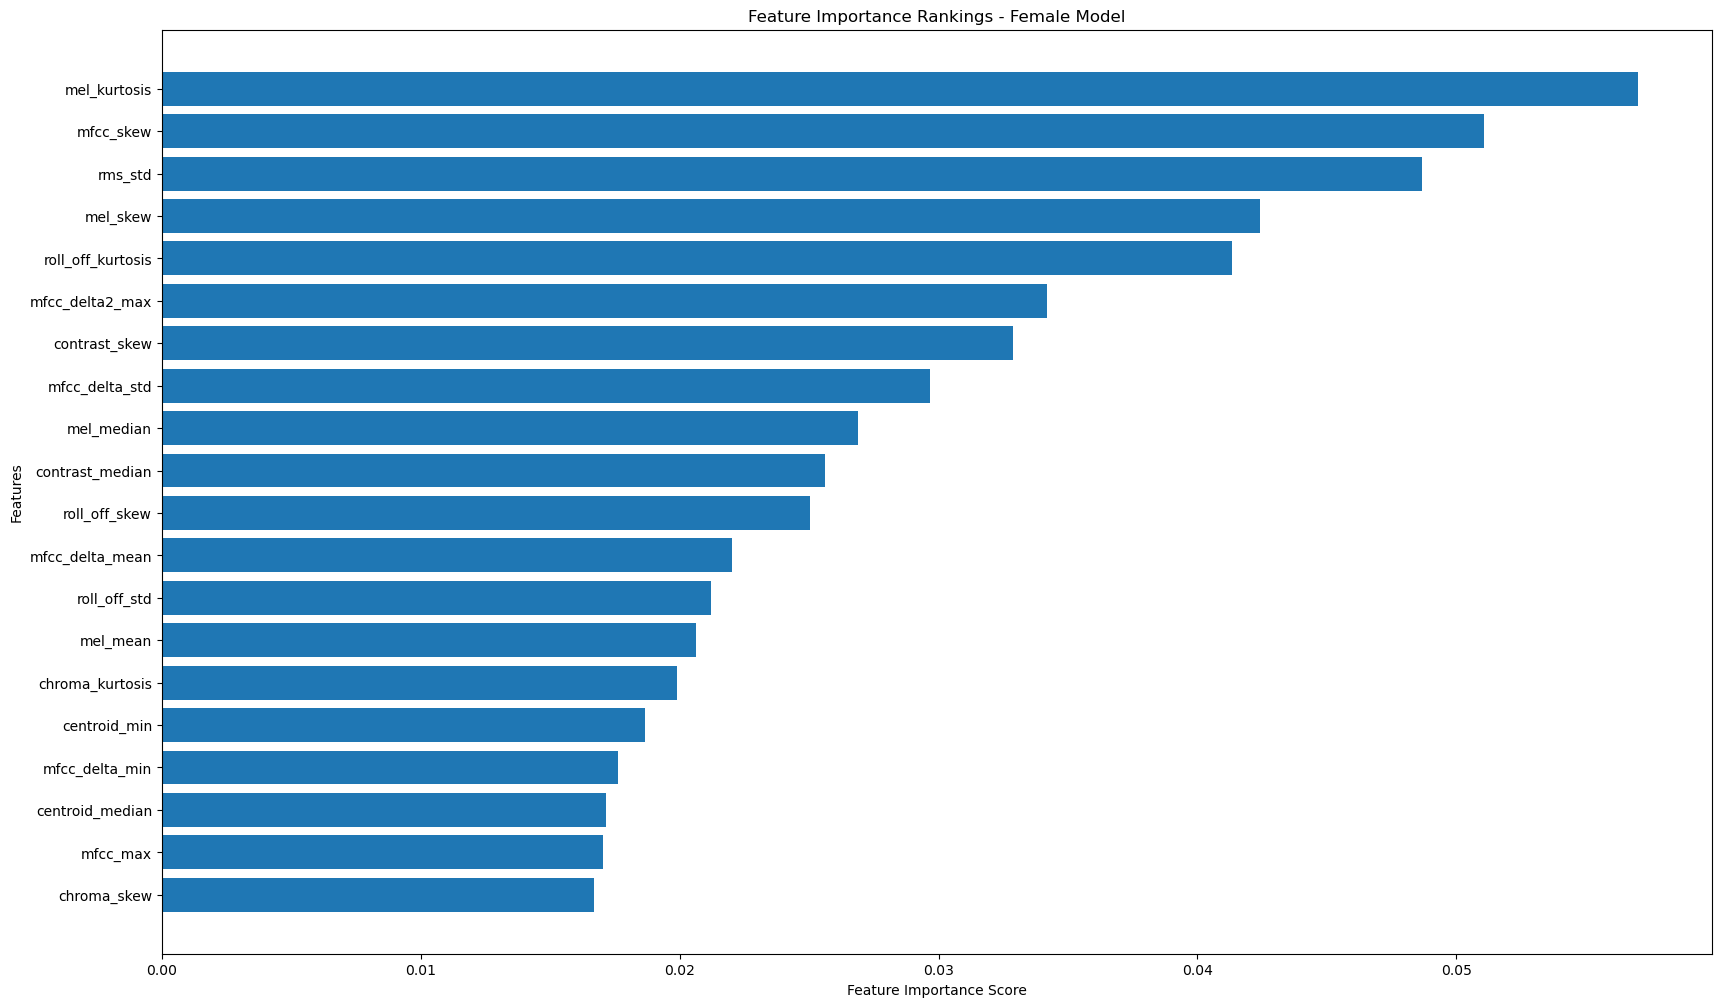

In [9]:
# 'model_male' and 'model_female' are the trained Random Forest models
gb_feature_importances_male = gb_clf_male.feature_importances_
gb_feature_importances_female = gb_clf_female.feature_importances_

# Update this list to match the features used in your current model
gb_feature_names = feature_list

# Creating dictionaries to map feature names to their importances for each model
gb_importances_male = dict(zip(gb_feature_names, gb_feature_importances_male))
gb_importances_female = dict(zip(gb_feature_names, gb_feature_importances_female))

# Function to plot feature importances and return top 20 features
def plot_gb_feature_importances_and_get_top_20(importances, title):
    # Sort features by importance
    gb_sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

    # Extract feature names and scores
    gb_sorted_features = [x[0] for x in gb_sorted_importances]
    gb_sorted_scores = [x[1] for x in gb_sorted_importances]

    # Plot
    plt.figure(figsize=(20, 12))
    plt.barh(gb_sorted_features[:20], gb_sorted_scores[:20])  # Plot only top 20 features
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

    # Return top 20 features
    return gb_sorted_features[:20]

# Get and plot top 20 features for male model
gb_top_20_features_male = plot_gb_feature_importances_and_get_top_20(gb_importances_male, 'Feature Importance Rankings - Male Model')

# Get and plot top 20 features for female model
gb_top_20_features_female = plot_gb_feature_importances_and_get_top_20(gb_importances_female, 'Feature Importance Rankings - Female Model')


In [10]:
# Predict on the test set
y_pred_male = gb_clf_male.predict(X_test_m_sc)
y_pred_female = gb_clf_female.predict(X_test_f_sc)

In [11]:
# Evaluate the models
accuracy_male = accuracy_score(y_test_male, y_pred_male)
accuracy_female = accuracy_score(y_test_female, y_pred_female)
print("\nConfusion Matrix for Male Model:")
print(confusion_matrix(y_test_male, gb_clf_male.predict(X_test_m_sc)))
print(classification_report(y_test_male, y_pred_male))
print(f"Accuracy for Male Model: {accuracy_male}")
print()
print()
print("\nConfusion Matrix for Female Model:")
print(confusion_matrix(y_test_female, gb_clf_female.predict(X_test_f_sc)))
print(classification_report(y_test_female, y_pred_female))
print(f"Accuracy for Female Model: {accuracy_female}")


Confusion Matrix for Male Model:
[[19  1  0  2  1  0  1]
 [ 0 22  0  0  1  1  0]
 [ 0  0 20  0  0  2  2]
 [ 2  0  2 17  0  1  2]
 [ 4  1  0  3 10  2  4]
 [ 0  1  1  0  5 17  0]
 [ 0  0  2  2  3  2 15]]
              precision    recall  f1-score   support

       angry       0.76      0.79      0.78        24
        calm       0.88      0.92      0.90        24
     disgust       0.80      0.83      0.82        24
     fearful       0.71      0.71      0.71        24
       happy       0.50      0.42      0.45        24
         sad       0.68      0.71      0.69        24
   surprised       0.62      0.62      0.62        24

    accuracy                           0.71       168
   macro avg       0.71      0.71      0.71       168
weighted avg       0.71      0.71      0.71       168

Accuracy for Male Model: 0.7142857142857143



Confusion Matrix for Female Model:
[[19  0  3  0  0  1  1]
 [ 0 22  0  1  0  1  0]
 [ 1  0 15  2  1  2  3]
 [ 1  2  1 14  3  2  1]
 [ 4  1  1  5  9  0  4

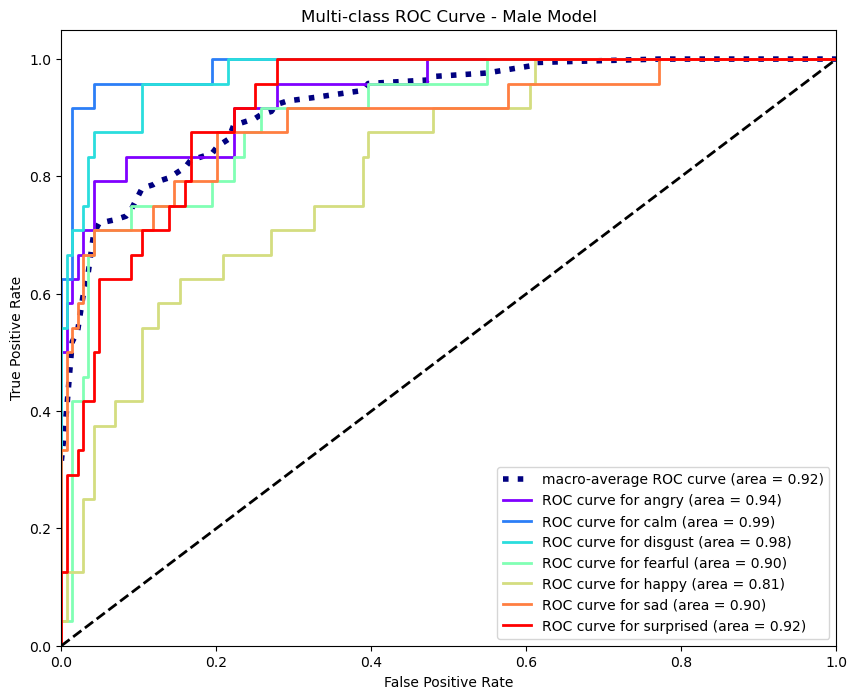

In [12]:
# Define the emotion classes
emotion_classes = gb_clf_male.classes_

# Binarize the labels for the male dataset
y_test_male_binarized = label_binarize(y_test_male, classes=emotion_classes)
n_classes_male = y_test_male_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr_male = dict()
tpr_male = dict()
roc_auc_male = dict()

y_prob = gb_clf_male.predict_proba(X_test_m_sc)

for i in range(n_classes_male):
    fpr_male[i], tpr_male[i], _ = roc_curve(y_test_male_binarized[:, i], y_prob[:, i])
    roc_auc_male[i] = auc(fpr_male[i], tpr_male[i])

# Compute micro-average ROC curve and ROC area
fpr_male["micro"], tpr_male["micro"], _ = roc_curve(y_test_male_binarized.ravel(), y_prob.ravel())
roc_auc_male["micro"] = auc(fpr_male["micro"], tpr_male["micro"])

# Aggregate all false positive rates
all_fpr_male = np.unique(np.concatenate([fpr_male[i] for i in range(n_classes_male)]))

# Interpolate all ROC curves at these points
mean_tpr_male = np.zeros_like(all_fpr_male)
for i in range(n_classes_male):
    mean_tpr_male += np.interp(all_fpr_male, fpr_male[i], tpr_male[i])

# Average it and compute AUC
mean_tpr_male /= n_classes_male

fpr_male["macro"] = all_fpr_male
tpr_male["macro"] = mean_tpr_male
roc_auc_male["macro"] = auc(fpr_male["macro"], tpr_male["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot macro-average ROC curve
plt.plot(fpr_male["macro"], tpr_male["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_male["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes_male)))
for i, color in zip(range(n_classes_male), colors):
    plt.plot(fpr_male[i], tpr_male[i], color=color, lw=2,
             label='ROC curve for {0} (area = {1:0.2f})'.format(emotion_classes[i], roc_auc_male[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Male Model')
plt.legend(loc="lower right")
plt.show()

In [28]:
# Assuming y_test_male and y_pred_male are your true and predicted labels
cm = confusion_matrix(y_test_male, y_pred_male)

# Create a DataFrame from the confusion matrix array
cm_df = pd.DataFrame(cm,
                     index=['Actual: Angry', 'Actual: Calm', 'Actual: Disgust', 'Actual: Fearful', 'Actual: Happy', 'Actual: Sad', 'Actual: Surprised'],
                     columns=['Predicted: Angry', 'Predicted: Calm', 'Predicted: Disgust', 'Predicted: Fearful', 'Predicted: Happy', 'Predicted: Sad', 'Predicted: Surprised'])

# Print the DataFrame
print(cm_df)

                   Predicted: Angry  Predicted: Calm  Predicted: Disgust  \
Actual: Angry                    18                1                   0   
Actual: Calm                      0               23                   0   
Actual: Disgust                   0                0                  19   
Actual: Fearful                   2                0                   2   
Actual: Happy                     4                1                   0   
Actual: Sad                       0                2                   2   
Actual: Surprised                 0                0                   1   

                   Predicted: Fearful  Predicted: Happy  Predicted: Sad  \
Actual: Angry                       2                 2               0   
Actual: Calm                        0                 1               0   
Actual: Disgust                     0                 1               2   
Actual: Fearful                    16                 0               2   
Actual: Happy   

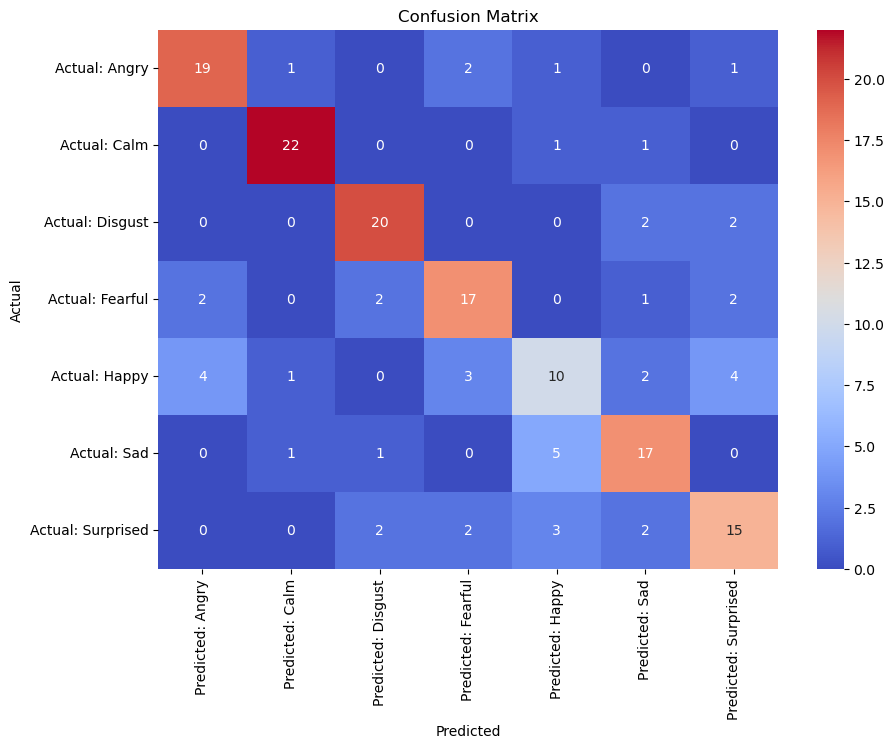

In [15]:
# Assuming y_test_male and y_pred_male are your true and predicted labels
cm = confusion_matrix(y_test_male, y_pred_male)

# Create a DataFrame from the confusion matrix array
cm_df = pd.DataFrame(cm,
                     index=['Actual: Angry', 'Actual: Calm', 'Actual: Disgust', 'Actual: Fearful', 'Actual: Happy', 'Actual: Sad', 'Actual: Surprised'],
                     columns=['Predicted: Angry', 'Predicted: Calm', 'Predicted: Disgust', 'Predicted: Fearful', 'Predicted: Happy', 'Predicted: Sad', 'Predicted: Surprised'])

# Plotting the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

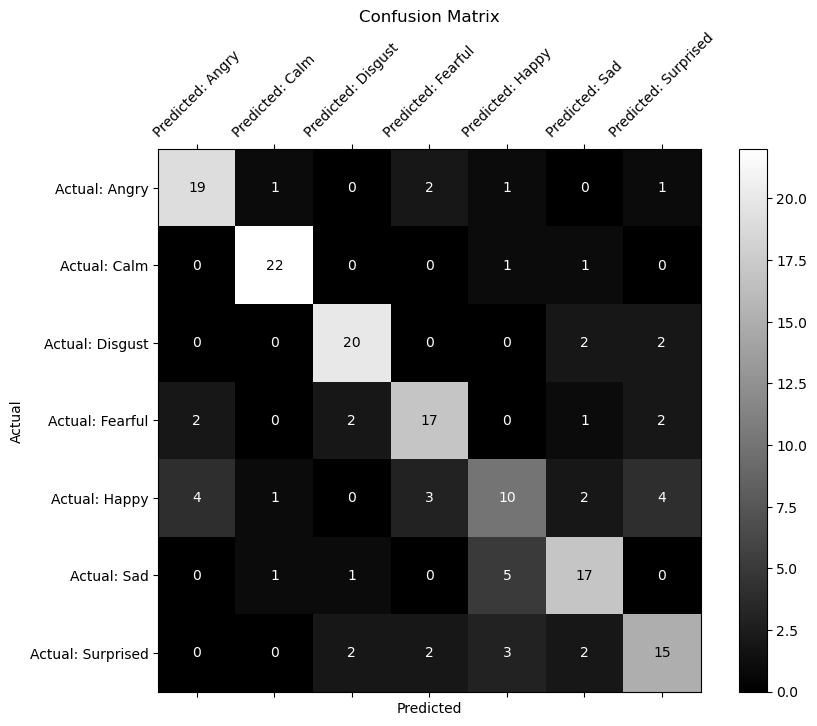

In [19]:
# Assuming y_test_male and y_pred_male are your true and predicted labels
cm = confusion_matrix(y_test_male, y_pred_male)

# Create a DataFrame from the confusion matrix array
cm_df = pd.DataFrame(cm,
                     index=['Actual: Angry', 'Actual: Calm', 'Actual: Disgust', 'Actual: Fearful', 'Actual: Happy', 'Actual: Sad', 'Actual: Surprised'],
                     columns=['Predicted: Angry', 'Predicted: Calm', 'Predicted: Disgust', 'Predicted: Fearful', 'Predicted: Happy', 'Predicted: Sad', 'Predicted: Surprised'])

# Plotting the matrix plot
plt.figure(figsize=(10, 7))
plt.matshow(cm, cmap='gray', fignum=1)
plt.colorbar()
plt.xticks(ticks=range(len(cm_df.columns)), labels=cm_df.columns, rotation=45)
plt.yticks(ticks=range(len(cm_df.index)), labels=cm_df.index)

# Adding annotations with dynamic color
threshold = cm.max() / 2  # Threshold for changing text color
for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black' if cm[i, j] > threshold else 'white'
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color=color)

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [29]:
pd.unique(df_male['emotion'])

array(['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'],
      dtype=object)

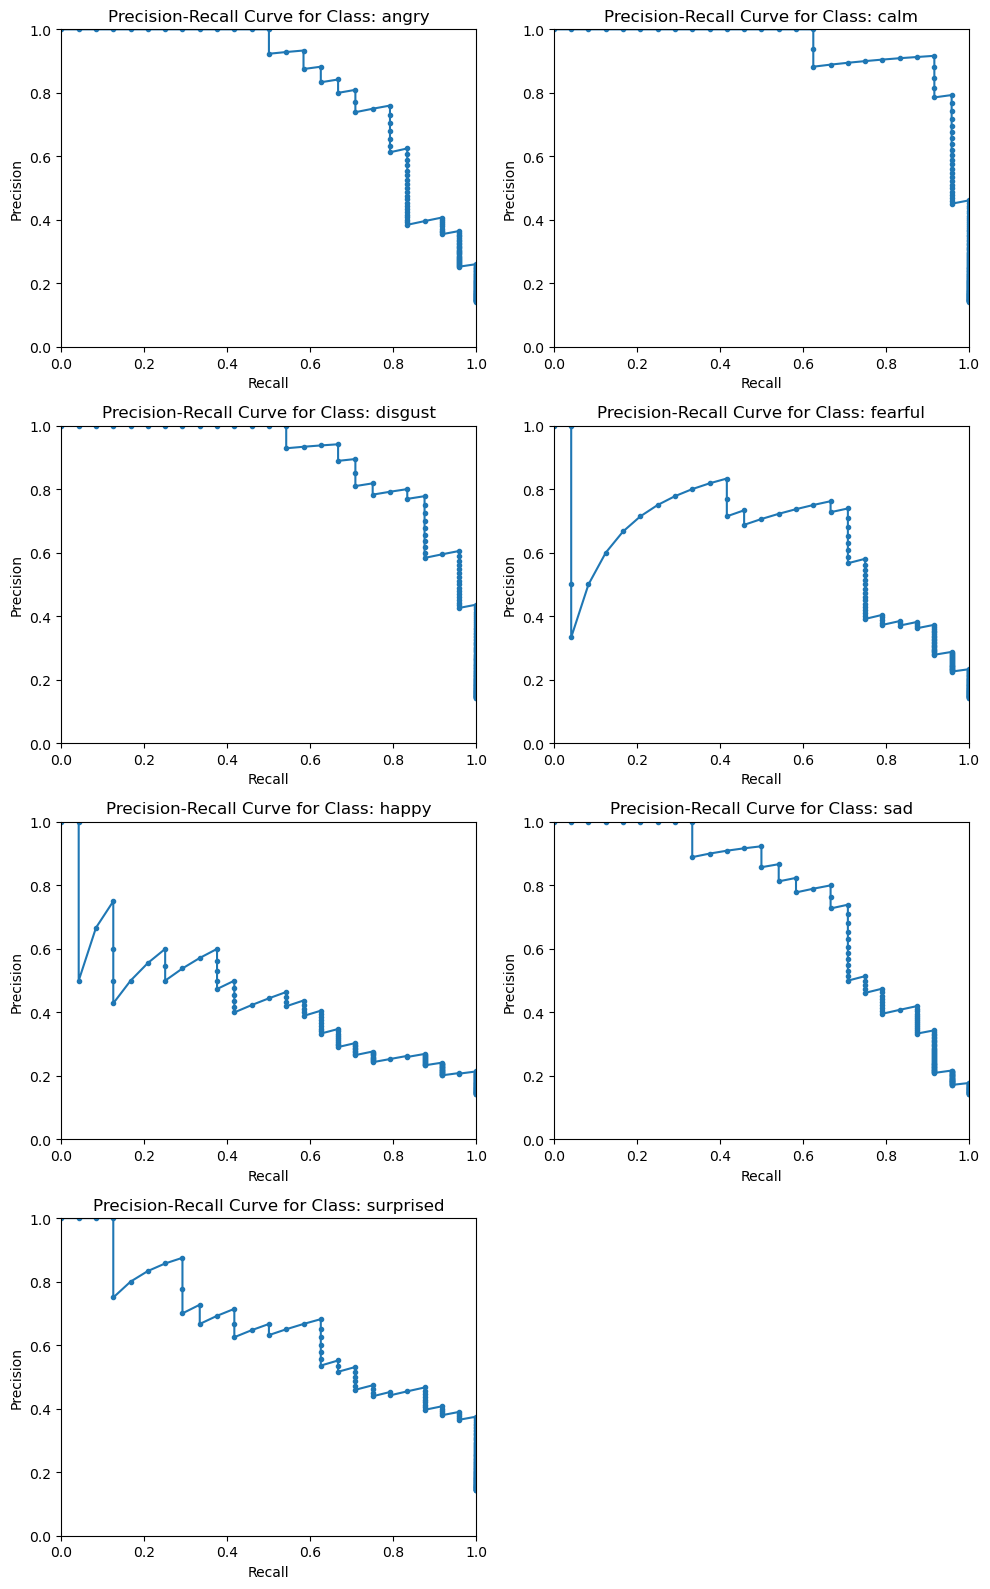

In [35]:
# Assuming 'y_test' is your true labels and 'model' is your trained model
# 'n_classes' is the number of emotion classes
emotion_classes = gb_clf_male.classes_
n_classes = len(emotion_classes)
y_score_m = gb_clf_male.predict_proba(X_test_m_sc)

rows = n_classes // 2 if n_classes % 2 == 0 else (n_classes // 2) + 1

fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10, rows * 4))
axes = axes.ravel()

# Hide unused subplots if the number of classes is odd
if n_classes % 2 != 0:
    axes[-1].set_visible(False)

for i in range(n_classes):
    # Convert y_test_male to binary format for the current class
    y_test_binary = np.where(y_test_male == emotion_classes[i], 1, 0)
    
    # Compute precision and recall for each class
    precision, recall, _ = precision_recall_curve(y_test_binary, y_score_m[:, i])
    
    # Plot the precision-recall curve for the class
    axes[i].plot(recall, precision, marker='.')
    axes[i].set_title(f'Precision-Recall Curve for Class: {emotion_classes[i]}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1])

plt.tight_layout()
plt.show()


# Feature importance<a id='Feature_importance'></a>

# Conclusion

### KNN

In [34]:
data1 = pd.read_csv('voice_data_dw.csv')    # RAVDESS data, dw = data wrangling
data2 = pd.read_csv('voice_data_dw_c.csv')     # CREMA-D data
df = pd.DataFrame(data1)
df_c = pd.DataFrame(data2)
pd.set_option('display.max_columns', None)
df.head()

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,-13.750966,208.77170,-651.9564,-5.260116,82.799590,-0.140461,-0.240087,2.491733,33.705196,-17.369028,0.262886,8.115748,1.653565,2.387000,-3.528996,13.174137,-39.414215,-0.135289,10.488796,-2.105011,2.833700,0.395015,0.010886,0.312053,0.300928,0.685030,-0.547113,0.009552,2.615224,4.031165e-18,0.000064,0.065616,3.980199,17.590267,25.992423,75.029004,6.442893,19.913183,16.481322,-0.583810,1.214911,1431.463197,3747.965221,581.068512,1153.185402,752.927915,1.652513,1.915730,2639.395255,5961.914062,999.023438,2325.683594,1357.013887,0.948544,-0.035782,0.005870,0.012585,0.001015,0.005574,0.002752,0.523488,-0.223807,0.071506,0.208984,0.023438,0.046875,0.049214,1.349598,0.792986
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,-14.013200,203.44556,-647.6516,-5.660081,83.142610,-0.055090,-0.332986,2.484158,33.476566,-16.323960,0.169552,8.183585,1.682235,2.384677,-3.587220,12.778202,-41.543182,-0.156874,10.659009,-2.112810,2.841899,0.372111,0.007602,0.275195,0.309303,0.783203,-0.390124,0.010960,2.218609,3.065071e-18,0.000057,0.074393,3.737703,14.996470,26.730421,75.095133,5.744724,21.058785,16.718861,-0.121057,2.233361,1428.133969,3787.006232,598.127794,1266.335723,719.014344,1.745676,2.597192,2754.882812,5918.945312,1020.507812,2578.125000,1289.368157,0.814459,0.048691,0.006225,0.013047,0.001003,0.005672,0.003002,0.472005,-0.447499,0.063912,0.183105,0.019531,0.048340,0.042300,1.347601,0.843776
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,-13.286643,212.63199,-603.8165,-5.457789,80.696570,-0.069167,-0.244607,2.352925,30.742325,-17.451830,0.207793,7.844898,1.603152,2.356841,-3.394885,11.864449,-39.883760,-0.110547,10.175233,-2.084090,2.802068,0.365138,0.006354,0.270417,0.299614,0.818134,-0.119496,0.015128,2.815824,4.134282e-18,0.000086,0.100440,3.830205,16.569090,26.321257,79.730935,4.494108,20.461424,16.544478,-0.328206,1.317845,1573.538319,4867.721737,537.361416,1173.576030,1054.731555,1.894945,2.580431,2852.647569,6262.695312,945.312500,2529.785156,1511.726106,0.877642,-0.247283,0.007237,0.017973,0.001440,0.006281,0.003825,1.126351,0.754771,0.086652,0.424316,0.014648,0.048340,0.091483,2.158822,4.017514
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,-13.380160,214.31924,-625.3130,-5.920652,81.306900,-0.068310,-0.379298,2.378634,32.634373,-17.722158,0.145714,7.996109,1.636472,2.379754,-3.510836,13.831413,-42.689724,-0.203858,10.426331,-2.097874,2.825182,0.399993,0.012884,0.301367,0.299288,0.811549,-0.325152,0.014019,3.281666,4.709254e-18,0.000072,0.097377,3.622848,14.702682,26.110333,78.056904,4.348983,20.056309,16.610803,-0.369971,1.573650,1564.442378,4695.050625,657.966547,1252.034920,1035.142571,1.732141,1.991167,2855.356070,6241.210938,923.828125,2567.382812,1535.589595,0.797591,-0.433007,0.006781,0.018386,0.001300,0.005872,0.004013,1.583204,1.841371,0.088229,0.406250,0.013184,0.047852,0.093873,1.803562,2.245144
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,-14.227764,217.13522,-693.7061,-4.584452,90.910904,-0.134584,-0

### Testing KNN on CREMA-D

In [28]:
df_c.columns

Index(['filename', 'statement', 'emotion', 'sex', 'voice_intensity',
       'mfcc_mean', 'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std',
       'mfcc_skew', 'mfcc_kurtosis', 'mfcc_delta_mean', 'mfcc_delta_max',
       'mfcc_delta_min', 'mfcc_delta_median', 'mfcc_delta_std',
       'mfcc_delta_skew', 'mfcc_delta_kurtosis', 'mfcc_delta2_mean',
       'mfcc_delta2_max', 'mfcc_delta2_min', 'mfcc_delta2_median',
       'mfcc_delta2_std', 'mfcc_delta2_skew', 'mfcc_delta2_kurtosis',
       'chroma_mean', 'chroma_min', 'chroma_median', 'chroma_std',
       'chroma_skew', 'chroma_kurtosis', 'mel_mean', 'mel_max', 'mel_min',
       'mel_median', 'mel_std', 'mel_skew', 'mel_kurtosis', 'contrast_mean',
       'contrast_max', 'contrast_min', 'contrast_median', 'contrast_std',
       'contrast_skew', 'contrast_kurtosis', 'centroid_mean', 'centroid_max',
       'centroid_min', 'centroid_median', 'centroid_std', 'centroid_skew',
       'centroid_kurtosis', 'roll_off_mean', 'roll_off_max', 'roll_off

In [3]:
# Dividing dataset into genders
df_male = df_c[df_c['sex'] == 'male']
df_female = df_c[df_c['sex'] == 'female']

# Features and labels for male dataset
X_male = df_male[['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta_median', 'mfcc_delta2_mean', 'mfcc_delta2_min', 
                  'chroma_mean', 'mel_mean', 'mel_median', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 
                  'rms_mean', 'zero_cr_mean']].values
# X_male = df_male[['rms_max', 'rms_std', 'mel_std', 'mel_max', 'mfcc_std', 'mel_mean', 'mel_skew']].values  # old test features
y_male = df_male['emotion'].values

# Features and labels for female dataset
X_female = df_female[['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 'mel_median', 
                      'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
                      'rms_mean', 'zero_cr_mean']].values
# X_female = df_female[['rms_max', 'rms_std', 'mel_std', 'mel_max', 'mfcc_std', 'mel_mean', 'mel_skew']].values  # old test features
y_female = df_female['emotion'].values

# Splitting the male dataset
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(
    X_male, y_male, test_size=0.25, random_state=42, shuffle=True, stratify=y_male)

# Splitting the female dataset
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(
    X_female, y_female, test_size=0.25, random_state=42, shuffle=True, stratify=y_female)

# Initialize scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_m_sc = scaler_male.fit_transform(X_train_male)
X_test_m_sc = scaler_male.transform(X_test_male)

# Scale the female datasets
X_train_f_sc = scaler_female.fit_transform(X_train_female)
X_test_f_sc = scaler_female.transform(X_test_female)

print("Scaled Male Dataset:", X_train_m_sc.shape, X_test_m_sc.shape, y_train_male.shape, y_test_male.shape)
print("Scaled Female Dataset:", X_train_f_sc.shape, X_test_f_sc.shape, y_train_female.shape, y_test_female.shape)

Scaled Male Dataset: (2947, 13) (983, 13) (2947,) (983,)
Scaled Female Dataset: (2634, 14) (878, 14) (2634,) (878,)


### Male testing CREMA-D

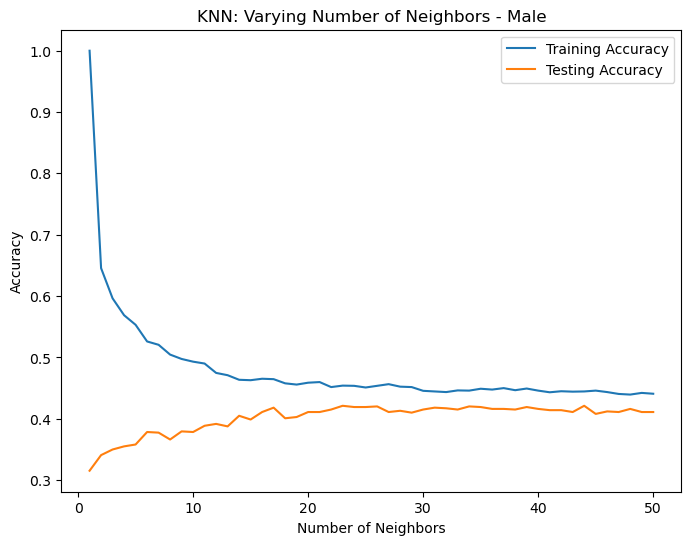

In [4]:
# Creating a plot to test n_neighbors
train_accuracies_cm = {}
test_accuracies_cm = {}
neighbors_cm = np.arange(1, 51)
for neighbor in neighbors_cm:
    knn_cm = KNeighborsClassifier(n_neighbors=neighbor)
    knn_cm.fit(X_train_m_sc, y_train_male)
    train_accuracies_cm[neighbor] = knn_cm.score(X_train_m_sc, y_train_male)
    test_accuracies_cm[neighbor] = knn_cm.score(X_test_m_sc, y_test_male)
    
plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors - Male")
plt.plot(neighbors_cm, train_accuracies_cm.values(), label="Training Accuracy")
plt.plot(neighbors_cm, test_accuracies_cm.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [9]:
knn_cm = KNeighborsClassifier(n_neighbors=22)
knn_cm.fit(X_train_m_sc, y_train_male)

KNeighborsClassifier(n_neighbors=22)

In [10]:
# Predict on the test set
y_pred_cm = knn_cm.predict(X_test_m_sc)

# Evaluate the models
accuracy_cm = accuracy_score(y_test_male, y_pred_cm)

print("\nConfusion Matrix for Male Model:")
print(confusion_matrix(y_test_male, knn_cm.predict(X_test_m_sc)))
print(classification_report(y_test_male, y_pred_cm))
print(f"Accuracy for Male Model: {accuracy_cm}")


Confusion Matrix for Male Model:
[[123   7  12   2  22   2]
 [  5  72  16   8  17  25]
 [ 17  46  48   7  22  28]
 [ 29  38  22  13  17  49]
 [ 41  36  12   7  60  12]
 [  2  41  20  12   1  92]]
              precision    recall  f1-score   support

       anger       0.57      0.73      0.64       168
        calm       0.30      0.50      0.38       143
     disgust       0.37      0.29      0.32       168
     fearful       0.27      0.08      0.12       168
       happy       0.43      0.36      0.39       168
         sad       0.44      0.55      0.49       168

    accuracy                           0.42       983
   macro avg       0.40      0.42      0.39       983
weighted avg       0.40      0.42      0.39       983

Accuracy for Male Model: 0.4150559511698881


### Female testing CREMA-D

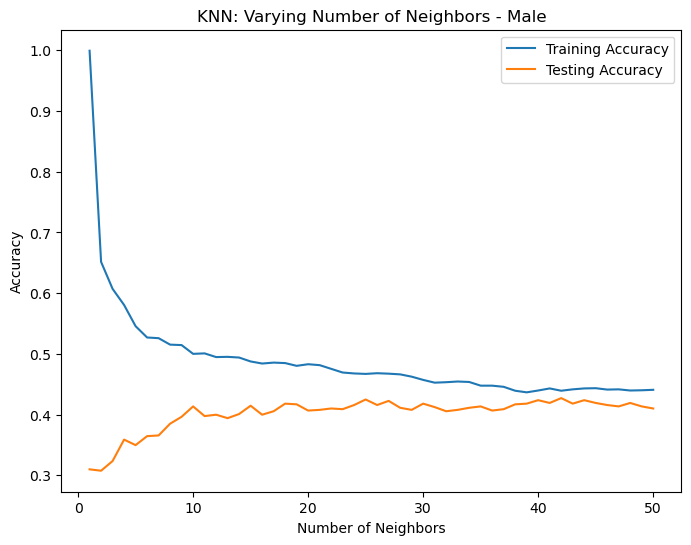

In [11]:
# Creating a plot to test n_neighbors
train_accuracies_cf = {}
test_accuracies_cf = {}
neighbors_cf = np.arange(1, 51)
for neighbor in neighbors_cf:
    knn_cf = KNeighborsClassifier(n_neighbors=neighbor)
    knn_cf.fit(X_train_f_sc, y_train_female)
    train_accuracies_cf[neighbor] = knn_cf.score(X_train_f_sc, y_train_female)
    test_accuracies_cf[neighbor] = knn_cf.score(X_test_f_sc, y_test_female)
    
plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors - Male")
plt.plot(neighbors_cf, train_accuracies_cf.values(), label="Training Accuracy")
plt.plot(neighbors_cf, test_accuracies_cf.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [12]:
knn_cf = KNeighborsClassifier(n_neighbors=42)
knn_cf.fit(X_train_f_sc, y_train_female)

KNeighborsClassifier(n_neighbors=42)

In [13]:
# Predict on the test set
y_pred_cf = knn_cf.predict(X_test_f_sc)

# Evaluate the models
accuracy_cf = accuracy_score(y_test_female, y_pred_cf)

print("\nConfusion Matrix for Female Model:")
print(confusion_matrix(y_test_female, knn_cf.predict(X_test_f_sc)))
print(classification_report(y_test_female, y_pred_cf))
print(f"Accuracy for female Model: {accuracy_cf}")


Confusion Matrix for Female Model:
[[110   4   9   2  25   0]
 [  0  69  14   3  12  30]
 [ 24  43  32   3  15  33]
 [ 37  27  10  15  24  37]
 [ 37  23  16   8  60   6]
 [  2  31  16   8   4  89]]
              precision    recall  f1-score   support

       anger       0.52      0.73      0.61       150
        calm       0.35      0.54      0.42       128
     disgust       0.33      0.21      0.26       150
     fearful       0.38      0.10      0.16       150
       happy       0.43      0.40      0.41       150
         sad       0.46      0.59      0.52       150

    accuracy                           0.43       878
   macro avg       0.41      0.43      0.40       878
weighted avg       0.41      0.43      0.40       878

Accuracy for female Model: 0.4271070615034169


### Testing KNN on RAVDESS

In [4]:
df.columns

Index(['filename', 'modality', 'vocal_channel', 'emotion', 'voice_intensity',
       'statement', 'statement_repetition', 'actor_gender', 'mfcc_mean',
       'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std', 'mfcc_skew',
       'mfcc_kurtosis', 'mfcc_delta_mean', 'mfcc_delta_max', 'mfcc_delta_min',
       'mfcc_delta_median', 'mfcc_delta_std', 'mfcc_delta_skew',
       'mfcc_delta_kurtosis', 'mfcc_delta2_mean', 'mfcc_delta2_max',
       'mfcc_delta2_min', 'mfcc_delta2_median', 'mfcc_delta2_std',
       'mfcc_delta2_skew', 'mfcc_delta2_kurtosis', 'chroma_mean', 'chroma_min',
       'chroma_median', 'chroma_std', 'chroma_skew', 'chroma_kurtosis',
       'mel_mean', 'mel_max', 'mel_min', 'mel_median', 'mel_std', 'mel_skew',
       'mel_kurtosis', 'contrast_mean', 'contrast_max', 'contrast_min',
       'contrast_median', 'contrast_std', 'contrast_skew', 'contrast_kurtosis',
       'centroid_mean', 'centroid_max', 'centroid_min', 'centroid_median',
       'centroid_std', 'centroid_skew', '

In [35]:
def emotion_to_string(e):
    if e % 8 == 1:
        return 'neutral'
    elif e % 8 == 2:
        return 'calm'
    elif e % 8 == 3:
        return 'happy'
    elif e % 8 == 4:
        return 'sad'
    elif e % 8 == 5:
        return 'angry'
    elif e % 8 == 6:
        return 'fearful'
    elif e % 8 == 7:
        return 'disgust'
    else:
        return 'surprised'

# Applying the function to the 'emotion' column
df['emotion'] = df['emotion'].apply(emotion_to_string)

In [62]:
# Dividing dataset into genders
df_male = df[df['actor_gender'] == 1]
df_female = df[df['actor_gender'] == 2]

# Removing 'neutral' category due to imbalance and similarity to calm
df_male = df_male[df_male['emotion'] != 'neutral']
df_female = df_female[df_female['emotion'] != 'neutral']

features_m = df_male.columns[8:].values

features_f = df_female.columns[8:].values

# features_m = df_male[['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta_median', 'mfcc_delta2_mean', 'mfcc_delta2_min', 
#                'chroma_mean', 'mel_mean', 'mel_median', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 
#                'rms_mean', 'zero_cr_mean']].values

# features_f = df_female[['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta_median', 'mfcc_delta2_mean', 'mfcc_delta2_min', 
#                'chroma_mean', 'mel_mean', 'mel_median', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 
#                'rms_mean', 'zero_cr_mean']].values

# features = df[df['rms_max', 'rms_std', 'mel_std', 'mel_max', 'mfcc_std', 'mel_mean', 'mel_skew']]

In [63]:
# Features and labels for male dataset
X_male = features_m
y_male = df_male['emotion'].values

# Features and labels for female dataset
X_female = features_f
y_female = df_female['emotion'].values

# Splitting the male dataset
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(
    X_male, y_male, test_size=0.25, random_state=42, shuffle=True, stratify=y_male)

# Splitting the female dataset
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(
    X_female, y_female, test_size=0.25, random_state=42, shuffle=True, stratify=y_female)

# Initialize scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_m_sc = scaler_male.fit_transform(X_train_male)
X_test_m_sc = scaler_male.transform(X_test_male)

# Scale the female datasets
X_train_f_sc = scaler_female.fit_transform(X_train_female)
X_test_f_sc = scaler_female.transform(X_test_female)

print("Scaled Male Dataset:", X_train_m_sc.shape, X_test_m_sc.shape, y_train_male.shape, y_test_male.shape)
print("Scaled Female Dataset:", X_train_f_sc.shape, X_test_f_sc.shape, y_train_female.shape, y_test_female.shape)

ValueError: Found input variables with inconsistent numbers of samples: [69, 672]

### Male testing

In [61]:
# Creating a plot to test n_neighbors
train_accuracies_m = {}
test_accuracies_m = {}
neighbors_m = np.arange(1, 26)
for neighbor in neighbors_m:
    knn_m = KNeighborsClassifier(n_neighbors=neighbor)
    knn_m.fit(X_train_m_sc, y_train_male)
    train_accuracies_m[neighbor] = knn_m.score(X_train_m_sc, y_train_male)
    test_accuracies_m[neighbor] = knn_m.score(X_test_m_sc, y_test_male)
    
plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors - Male")
plt.plot(neighbors_m, train_accuracies_m.values(), label="Training Accuracy")
plt.plot(neighbors_m, test_accuracies_m.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

AttributeError: 'NoneType' object has no attribute 'split'

In [22]:
knn_m = KNeighborsClassifier(n_neighbors=5)
knn_m.fit(X_train_m_sc, y_train_male)

KNeighborsClassifier()

In [23]:
# Predict on the test set
y_pred_m = knn_m.predict(X_test_m_sc)

# Evaluate the models
accuracy_m = accuracy_score(y_test_male, y_pred_m)

print("\nConfusion Matrix for Male Model:")
print(confusion_matrix(y_test_male, knn_m.predict(X_test_m_sc)))
print(classification_report(y_test_male, y_pred_m))
print(f"Accuracy for Male Model: {accuracy_m}")


Confusion Matrix for Male Model:
[[20  1  0  0  2  0  1]
 [ 1 23  0  0  0  0  0]
 [ 1  5 16  1  0  1  0]
 [ 2  0  3 10  4  1  4]
 [ 3  3  0  2 11  2  3]
 [ 0  5  4  2  1 10  2]
 [ 1  3  5  4  0  1 10]]
              precision    recall  f1-score   support

       angry       0.71      0.83      0.77        24
        calm       0.57      0.96      0.72        24
     disgust       0.57      0.67      0.62        24
     fearful       0.53      0.42      0.47        24
       happy       0.61      0.46      0.52        24
         sad       0.67      0.42      0.51        24
   surprised       0.50      0.42      0.45        24

    accuracy                           0.60       168
   macro avg       0.59      0.60      0.58       168
weighted avg       0.59      0.60      0.58       168

Accuracy for Male Model: 0.5952380952380952


In [ ]:
# Best scaled male accuracy: 0.5952380952380952       with 5 neighbors
# features = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta_median', 'mfcc_delta2_mean', 'mfcc_delta2_min', 
# 'chroma_mean', 'mel_mean', 'mel_median', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'rms_mean', 'zero_cr_mean']

### Female testing

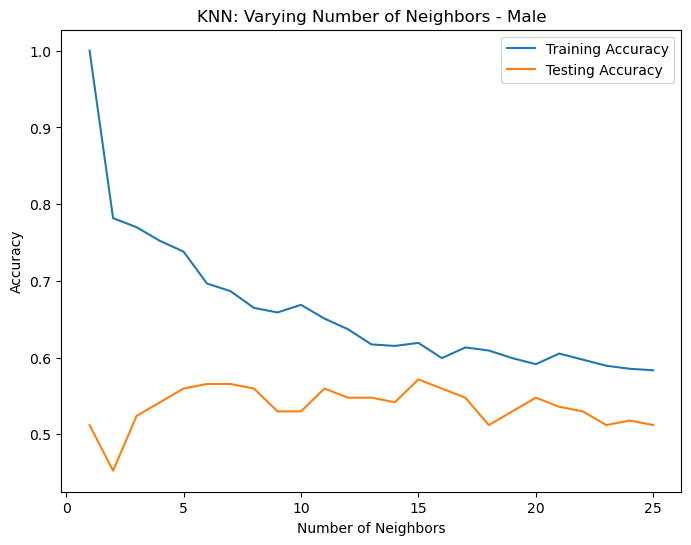

In [103]:
# Creating a plot to test n_neighbors
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 26)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train_f_sc, y_train_female)
    train_accuracies[neighbor] = knn.score(X_train_f_sc, y_train_female)
    test_accuracies[neighbor] = knn.score(X_test_f_sc, y_test_female)
    
plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors - Male")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [104]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_f_sc, y_train_female)

KNeighborsClassifier(n_neighbors=15)

In [105]:
print(f'Scaled Female accuracy:  {knn.score(X_test_f_sc, y_test_female)}')

Scaled Female accuracy:  0.5714285714285714


In [ ]:
# Best scaled female accuracy: 0.5714285714285714       with 15 neighbors
# features = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 'mel_median', 
# 'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 'rms_mean', 'zero_cr_mean']

## Linear Regression

In [113]:
# data = pd.read_csv('voice_data_dw.csv')    # normal data, dw = data wrangling
data = pd.read_csv('voice_data_no_trim.csv')     # test data
df = pd.DataFrame(data)
df.head()

,filename,modality,vocal_channel,emotion,voice_intensity,statement,statement_repetition,actor_gender,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_max,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1,-13.750966,208.77170,-651.9564,-5.260116,82.799590,-0.140461,-0.240087,2.491733,33.705196,-17.369028,0.262886,8.115748,1.653565,2.387000,-3.528996,13.174137,-39.414215,-0.135289,10.488796,-2.105011,2.833700,0.395015,0.010886,1.0,0.312053,0.300928,0.685030,-0.547113,0.009552,2.615224,4.031165e-18,0.000064,0.065616,3.980199,17.590267,25.992423,75.029004,6.442893,19.913183,16.481322,-0.583810,1.214911,1431.463197,3747.965221,581.068512,1153.185402,752.927915,1.652513,1.915730,2639.395255,5961.914062,999.023438,2325.683594,1357.013887,0.948544,-0.035782,0.005870,0.012585,0.001015,0.005574,0.002752,0.523488,-0.223807,0.071506,0.208984,0.023438,0.046875,0.049214,1.349598,0.792986
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1,-14.013200,203.44556,-647.6516,-5.660081,83.142610,-0.055090,-0.332986,2.484158,33.476566,-16.323960,0.169552,8.183585,1.682235,2.384677,-3.587220,12.778202,-41.543182,-0.156874,10.659009,-2.112810,2.841899,0.372111,0.007602,1.0,0.275195,0.309303,0.783203,-0.390124,0.010960,2.218609,3.065071e-18,0.000057,0.074393,3.737703,14.996470,26.730421,75.095133,5.744724,21.058785,16.718861,-0.121057,2.233361,1428.133969,3787.006232,598.127794,1266.335723,719.014344,1.745676,2.597192,2754.882812,5918.945312,1020.507812,2578.125000,1289.368157,0.814459,0.048691,0.006225,0.013047,0.001003,0.005672,0.003002,0.472005,-0.447499,0.063912,0.183105,0.019531,0.048340,0.042300,1.347601,0.843776
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1,-13.286643,212.63199,-603.8165,-5.457789,80.696570,-0.069167,-0.244607,2.352925,30.742325,-17.451830,0.207793,7.844898,1.603152,2.356841,-3.394885,11.864449,-39.883760,-0.110547,10.175233,-2.084090,2.802068,0.365138,0.006354,1.0,0.270417,0.299614,0.818134,-0.119496,0.015128,2.815824,4.134282e-18,0.000086,0.100440,3.830205,16.569090,26.321257,79.730935,4.494108,20.461424,16.544478,-0.328206,1.317845,1573.538319,4867.721737,537.361416,1173.576030,1054.731555,1.894945,2.580431,2852.647569,6262.695312,945.312500,2529.785156,1511.726106,0.877642,-0.247283,0.007237,0.017973,0.001440,0.006281,0.003825,1.126351,0.754771,0.086652,0.424316,0.014648,0.048340,0.091483,2.158822,4.017514
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1,-13.380160,214.31924,-625.3130,-5.920652,81.306900,-0.068310,-0.379298,2.378634,32.634373,-17.722158,0.145714,7.996109,1.636472,2.379754,-3.510836,13.831413,-42.689724,-0.203858,10.426331,-2.097874,2.825182,0.399993,0.012884,1.0,0.301367,0.299288,0.811549,-0.325152,0.014019,3.281666,4.709254e-18,0.000072,0.097377,3.622848,14.702682,26.110333,78.056904,4.348983,20.056309,16.610803,-0.369971,1.573650,1564.442378,4695.050625,657.966547,1252.034920,1035.142571,1.732141,1.991167,2855.356070,6241.210938,923.828125,2567.382812,1535.589595,0.797591,-0.433007,0.006781,0.018386,0.001300,0.005872,0.004013,1.583204,1.841371,0.088229,0.406250,0.013184,0.047852,0.093873,1.803562,2.245144
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1,-14.227764,217.13522,-693.7061,-4.58

In [63]:
df.columns

Index(['filename', 'emotion', 'voice_intensity', 'statement',
       'statement_repetition', 'actor_gender', 'mfcc_mean', 'mfcc_median',
       'mfcc_std', 'mfcc_skew', 'mfcc_kurtosis', 'mfcc_delta_mean',
       'mfcc_delta_median', 'mfcc_delta_std', 'mfcc_delta_skew',
       'mfcc_delta_kurtosis', 'mfcc_delta2_mean', 'mfcc_delta2_median',
       'mfcc_delta2_std', 'mfcc_delta2_skew', 'mfcc_delta2_kurtosis',
       'chroma_mean', 'chroma_median', 'chroma_std', 'chroma_skew',
       'chroma_kurtosis', 'mel_mean', 'mel_max', 'mel_min', 'mel_median',
       'mel_std', 'mel_skew', 'centroid_mean', 'centroid_max', 'centroid_min',
       'centroid_median', 'centroid_std', 'centroid_skew', 'centroid_kurtosis',
       'roll_off_mean', 'roll_off_max', 'roll_off_min', 'roll_off_median',
       'roll_off_std', 'roll_off_skew', 'roll_off_kurtosis', 'rms_mean',
       'rms_max', 'rms_min', 'rms_median', 'rms_std', 'rms_skew',
       'rms_kurtosis'],
      dtype='object')

In [114]:
from sklearn.preprocessing import StandardScaler

# Dividing dataset into genders
df_male = df[df['actor_gender'] == 1]
df_female = df[df['actor_gender'] == 2]

# Removing 'neutral' category
df_male = df_male[df_male['emotion'] != 1]
df_female = df_female[df_female['emotion'] != 1]

# Features and labels for male and female datasets
# X_male = df_male[['rms_max', 'rms_std', 'mel_std', 'mel_max', 'mfcc_std', 'mel_mean', 'mel_skew']].values 
X_male = df_male[['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta_median', 'mfcc_delta2_mean', 'mfcc_delta2_min', 
                  'chroma_mean', 'mel_mean', 'mel_median', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 
                  'rms_mean', 'zero_cr_mean']].values 
y_male = df_male['emotion'].values

# Features and labels for female dataset
# X_female = df_female[['rms_max', 'rms_std', 'mel_std', 'mel_max', 'mfcc_std', 'mel_mean', 'mel_skew']].values
X_female = df_female[['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 'mel_median', 
                      'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
                      'rms_mean', 'zero_cr_mean']].values
y_female = df_female['emotion'].values

# Splitting the male dataset
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(
    X_male, y_male, test_size=0.3, random_state=42, shuffle=True, stratify=y_male)

# Splitting the female dataset
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(
    X_female, y_female, test_size=0.3, random_state=42, shuffle=True, stratify=y_female)

# Initialize scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_m_sc = scaler_male.fit_transform(X_train_male)
X_test_m_sc = scaler_male.transform(X_test_male)

# Scale the female datasets
X_train_f_sc = scaler_female.fit_transform(X_train_female)
X_test_f_sc = scaler_female.transform(X_test_female)

print("Male Dataset:", X_train_m_sc.shape, X_test_m_sc.shape, y_train_male.shape, y_test_male.shape)
print("Female Dataset:", X_train_f_sc.shape, X_test_f_sc.shape, y_train_female.shape, y_test_female.shape)

Male Dataset: (470, 13) (202, 13) (470,) (202,)
Female Dataset: (470, 14) (202, 14) (470,) (202,)


In [115]:
df_female['actor_gender'].sum()

1344

In [116]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [117]:
model.fit(X_train_m_sc, y_train_male)

LinearRegression()

In [118]:
r_sq = model.score(X_test_m_sc, y_test_male)
print(f"coefficient of determination for male actors: {r_sq}")

coefficient of determination for male actors: 0.3558131057435292


In [119]:
model.fit(X_train_f_sc, y_train_female)

LinearRegression()

In [120]:
r_sq = model.score(X_test_f_sc, y_test_female)
print(f"coefficient of determination for male actors: {r_sq}")

coefficient of determination for male actors: 0.4152934463847324


## AdaBoosting

In [58]:
# data = pd.read_csv('voice_data_dw.csv')    # RAVDESS data, dw = data wrangling
data = pd.read_csv('voice_data_dw_c.csv')     # CREMA-D data
df = pd.DataFrame(data)
pd.set_option('display.max_columns', None)
df.head()

,filename,statement,emotion,voice_intensity,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,1001_DFA_ANG_XX.wav,DFA,anger,XX,-7.432612,174.84760,-376.76526,-5.320008,44.835827,0.078759,-0.135262,0.431405,14.325659,-14.404216,0.081626,3.380435,-0.371813,4.681387,-1.217407,12.880376,-25.787530,-0.109359,5.054519,-0.682310,3.987382,0.370062,0.013317,0.285921,0.298837,0.779155,-0.265940,1.802765,341.034850,4.291813e-16,0.017892,10.614741,3.151779,11.198245,25.925944,78.077610,6.084921,20.149438,17.473064,-0.155067,1.352212,1804.713467,3877.246542,850.701392,1722.115296,653.022369,1.413663,2.314508,3408.182780,6724.609375,1160.156250,3147.460938,1371.601695,0.863480,0.212954,0.078334,0.191608,0.016036,0.073865,0.048450,0.566373,-0.510565,0.105326,0.266113,0.041504,0.098877,0.046664,1.461352,2.607774
1,1001_DFA_DIS_XX.wav,DFA,disgust,XX,-7.576970,188.41974,-442.81302,-3.740663,53.531773,0.002014,-0.244549,1.024989,23.331991,-13.811496,0.180861,4.465023,0.414863,3.232379,-1.812531,11.552841,-28.425322,-0.009999,6.279553,-1.673368,2.504315,0.433403,0.023846,0.360919,0.285881,0.629154,-0.226957,0.225125,32.968315,1.108487e-16,0.005129,1.285617,3.313690,12.543914,24.269469,79.748514,6.605879,18.260069,18.370283,-0.165593,1.154600,1875.720250,4003.910997,1056.060231,1772.574762,639.612037,1.674937,3.033505,3489.342731,6746.093750,1965.820312,2905.761719,1246.843031,1.244088,0.541582,0.028362,0.069885,0.004940,0.023955,0.015989,0.909930,0.185061,0.108738,0.271973,0.043945,0.106201,0.051661,1.394082,2.008864
2,1001_DFA_FEA_XX.wav,DFA,fearful,XX,-6.539266,164.17966,-314.37363,-5.058465,39.502186,0.123554,-0.337549,0.445084,13.653070,-11.622889,0.185306,2.913034,-0.471180,3.054125,-0.923070,11.620729,-18.870539,-0.208313,3.878811,-0.359375,2.769273,0.324290,0.008209,0.219413,0.301901,1.002098,0.433895,3.340253,600.194030,1.289492e-15,0.046582,22.754826,2.837395,8.699330,25.808410,80.622277,5.405875,20.167323,17.429797,-0.196237,0.161098,1866.926157,4197.814433,1377.150233,1701.325130,596.453272,2.441903,5.900998,3356.166295,7036.132812,1858.398438,2846.679688,1296.296467,1.565273,1.892657,0.110559,0.224669,0.014313,0.112171,0.058515,0.059786,-1.035065,0.103251,0.235840,0.040039,0.089355,0.046278,1.585550,1.822081
3,1001_DFA_HAP_XX.wav,DFA,happy,XX,-7.077594,170.77046,-370.62564,-4.762581,42.701206,0.033941,-0.280180,0.596354,16.302065,-13.986929,0.419784,3.142268,-0.695585,4.149343,-1.065666,11.471300,-22.991669,-0.111598,4.501121,-0.624069,3.914729,0.379158,0.013199,0.298662,0.304692,0.812888,-0.220736,1.932823,391.752200,1.039006e-15,0.027489,12.211181,3.110390,10.279093,25.667103,81.606248,8.258755,20.079600,17.450165,-0.319095,0.505786,1790.915540,3874.020804,1096.031698,1666.797815,557.538019,2.421424,6.498064,3374.208193,6767.578125,2019.531250,2964.843750,1107.913697,1.519381,2.082263,0.083394,0.189180,0.012610,0.077070,0.044943,0.600728,-0.537000,0.094951,0.221680,0.034668,0.086914,0.042843,1.538277,2.198416
4,1001_DFA_NEU_XX.wav,DFA,calm,XX,-7.398680,177.08044,-423.85733,-3.932490,51.536090,-0.030257,-0.224572,0.941487,21.345900,-15.971029,0.201776,4.230939,0.085539,3.837635,-1.82

### CREMA-D

In [59]:
feature_list = df.columns[4:]

In [60]:
# Features and labels for male dataset
X = df[feature_list].values
y = df['emotion'].values

# Splitting the male dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)

# Initialize scalers for male and female datasets
scaler = StandardScaler()

# Scale the male datasets
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

print("Dataset shape:", X_train_sc.shape, X_test_sc.shape, y_train.shape, y_test.shape)

Dataset shape: (5581, 69) (1861, 69) (5581,) (1861,)


In [61]:
# Base male estimator
c_estimator = DecisionTreeClassifier(max_depth=7)

# AdaBoost classifier, using scaled for now
ada_clf_sc = AdaBoostClassifier(base_estimator=c_estimator, n_estimators=300, random_state=42)

# Training AdaBoost classifier
ada_clf_sc.fit(X_train_sc, y_train)

C:\Users\where\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),
                   n_estimators=300, random_state=42)

In [62]:
# Predict on the test set
y_pred_c = ada_clf_sc.predict(X_test_sc)

In [63]:
# Evaluate the models
accuracy_c = accuracy_score(y_test, y_pred_c)
print(f"Accuracy for Male Model: {accuracy_c}")
print(classification_report(y_test, y_pred_c))

Accuracy for Male Model: 0.46372917786136486
              precision    recall  f1-score   support

       anger       0.58      0.71      0.63       318
        calm       0.42      0.53      0.47       271
     disgust       0.40      0.31      0.35       318
     fearful       0.51      0.19      0.28       318
       happy       0.40      0.42      0.41       318
         sad       0.47      0.64      0.55       318

    accuracy                           0.46      1861
   macro avg       0.46      0.47      0.45      1861
weighted avg       0.46      0.46      0.45      1861



### RAVDESS

In [46]:
def emotion_to_string(e):
    if e % 8 == 1:
        return 'neutral'
    elif e % 8 == 2:
        return 'calm'
    elif e % 8 == 3:
        return 'happy'
    elif e % 8 == 4:
        return 'sad'
    elif e % 8 == 5:
        return 'angry'
    elif e % 8 == 6:
        return 'fearful'
    elif e % 8 == 7:
        return 'disgust'
    else:
        return 'surprised'

# Applying the function to the 'emotion' column
df['emotion'] = df['emotion'].apply(emotion_to_string)

In [47]:
feature_list = df.columns[8:]

In [48]:
# Dividing dataset into genders
df_male = df[df['actor_gender'] == 1]
df_female = df[df['actor_gender'] == 2]

# Removing 'neutral' category
df_male = df_male[df_male['emotion'] != 'neutral']
df_female = df_female[df_female['emotion'] != 'neutral']

# Features and labels for male dataset
X_male = df_male[feature_list].values
y_male = df_male['emotion'].values

# Features and labels for female dataset
X_female = df_female[feature_list].values
y_female = df_female['emotion'].values

# Splitting the male dataset
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(
    X_male, y_male, test_size=0.25, random_state=42, shuffle=True, stratify=y_male)

# Splitting the female dataset
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(
    X_female, y_female, test_size=0.25, random_state=42, shuffle=True, stratify=y_female)

# Initialize scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_m_sc = scaler_male.fit_transform(X_train_male)
X_test_m_sc = scaler_male.transform(X_test_male)

# Scale the female datasets
X_train_f_sc = scaler_female.fit_transform(X_train_female)
X_test_f_sc = scaler_female.transform(X_test_female)

print("Male Dataset:", X_train_m_sc.shape, X_test_m_sc.shape, y_train_male.shape, y_test_male.shape)
print("Female Dataset:", X_train_f_sc.shape, X_test_f_sc.shape, y_train_female.shape, y_test_female.shape)

Male Dataset: (504, 70) (168, 70) (504,) (168,)
Female Dataset: (504, 70) (168, 70) (504,) (168,)


In [57]:
# Base male estimator
male_estimator = DecisionTreeClassifier(max_depth=7)

# AdaBoost classifier, using scaled for now
ada_clf_m_sc = AdaBoostClassifier(base_estimator=male_estimator, n_estimators=300, random_state=42)

# Training AdaBoost classifier
ada_clf_m_sc.fit(X_train_m_sc, y_train_male)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),
                   n_estimators=300, random_state=42)

In [58]:
# Base female estimator
female_estimator = DecisionTreeClassifier(max_depth=7)

# AdaBoost classifier, using scaled for now
ada_clf_f_sc = AdaBoostClassifier(base_estimator=female_estimator, n_estimators=300, random_state=42)

# Training AdaBoost classifier
ada_clf_f_sc.fit(X_train_f_sc, y_train_female)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),
                   n_estimators=300, random_state=42)

In [59]:
# Predict on the test set
y_pred_male = ada_clf_m_sc.predict(X_test_m_sc)
y_pred_female = ada_clf_f_sc.predict(X_test_f_sc)

In [60]:
# Evaluate the models
accuracy_male = accuracy_score(y_test_male, y_pred_male)
accuracy_female = accuracy_score(y_test_female, y_pred_female)
print(f"Accuracy for Male Model: {accuracy_male}")
print(classification_report(y_test_male, y_pred_male))
print(f"Accuracy for Female Model: {accuracy_female}")
print(classification_report(y_test_female, y_pred_female))

Accuracy for Male Model: 0.6726190476190477
              precision    recall  f1-score   support

       angry       0.73      0.79      0.76        24
        calm       0.79      0.96      0.87        24
     disgust       0.86      0.79      0.83        24
     fearful       0.67      0.58      0.62        24
       happy       0.50      0.46      0.48        24
         sad       0.54      0.62      0.58        24
   surprised       0.60      0.50      0.55        24

    accuracy                           0.67       168
   macro avg       0.67      0.67      0.67       168
weighted avg       0.67      0.67      0.67       168

Accuracy for Female Model: 0.6130952380952381
              precision    recall  f1-score   support

       angry       0.59      0.71      0.64        24
        calm       0.71      0.83      0.77        24
     disgust       0.59      0.67      0.63        24
     fearful       0.58      0.62      0.60        24
       happy       0.57      0.50      0.5

## Support Vector Machine

## Multi Layer Perception Classifier - new method

In [2]:
data1 = pd.read_csv('voice_data_dw.csv')    # RAVDESS data, dw = data wrangling
data2 = pd.read_csv('voice_data_dw_c.csv')     # CREMA-D data
df = pd.DataFrame(data1)
df_c = pd.DataFrame(data2)
pd.set_option('display.max_columns', None)
df_c.head()

,filename,statement,emotion,sex,voice_intensity,mfcc_mean,mfcc_max,mfcc_min,mfcc_median,mfcc_std,mfcc_skew,mfcc_kurtosis,mfcc_delta_mean,mfcc_delta_max,mfcc_delta_min,mfcc_delta_median,mfcc_delta_std,mfcc_delta_skew,mfcc_delta_kurtosis,mfcc_delta2_mean,mfcc_delta2_max,mfcc_delta2_min,mfcc_delta2_median,mfcc_delta2_std,mfcc_delta2_skew,mfcc_delta2_kurtosis,chroma_mean,chroma_min,chroma_median,chroma_std,chroma_skew,chroma_kurtosis,mel_mean,mel_max,mel_min,mel_median,mel_std,mel_skew,mel_kurtosis,contrast_mean,contrast_max,contrast_min,contrast_median,contrast_std,contrast_skew,contrast_kurtosis,centroid_mean,centroid_max,centroid_min,centroid_median,centroid_std,centroid_skew,centroid_kurtosis,roll_off_mean,roll_off_max,roll_off_min,roll_off_median,roll_off_std,roll_off_skew,roll_off_kurtosis,rms_mean,rms_max,rms_min,rms_median,rms_std,rms_skew,rms_kurtosis,zero_cr_mean,zero_cr_max,zero_cr_min,zero_cr_median,zero_cr_std,zero_cr_skew,zero_cr_kurtosis
0,1001_DFA_ANG_XX.wav,DFA,anger,male,XX,-7.432612,174.84760,-376.76526,-5.320008,44.835827,0.078759,-0.135262,0.431405,14.325659,-14.404216,0.081626,3.380435,-0.371813,4.681387,-1.217407,12.880376,-25.787530,-0.109359,5.054519,-0.682310,3.987382,0.370062,0.013317,0.285921,0.298837,0.779155,-0.265940,1.802765,341.034850,4.290000e-16,0.017892,10.614741,3.151779,11.198245,25.925944,78.077610,6.084921,20.149438,17.473064,-0.155067,1.352212,1804.713467,3877.246542,850.701392,1722.115296,653.022369,1.413663,2.314508,3408.182780,6724.609375,1160.156250,3147.460938,1371.601695,0.863480,0.212954,0.078334,0.191608,0.016036,0.073865,0.048450,0.566373,-0.510565,0.105326,0.266113,0.041504,0.098877,0.046664,1.461352,2.607774
1,1001_DFA_DIS_XX.wav,DFA,disgust,male,XX,-7.576970,188.41974,-442.81302,-3.740663,53.531773,0.002014,-0.244549,1.024989,23.331991,-13.811496,0.180861,4.465023,0.414863,3.232379,-1.812531,11.552841,-28.425322,-0.009999,6.279553,-1.673368,2.504315,0.433403,0.023846,0.360919,0.285881,0.629154,-0.226957,0.225125,32.968315,1.110000e-16,0.005129,1.285617,3.313690,12.543914,24.269469,79.748514,6.605879,18.260069,18.370283,-0.165593,1.154600,1875.720250,4003.910997,1056.060231,1772.574762,639.612037,1.674937,3.033505,3489.342731,6746.093750,1965.820313,2905.761719,1246.843031,1.244088,0.541582,0.028362,0.069885,0.004940,0.023955,0.015989,0.909930,0.185061,0.108738,0.271973,0.043945,0.106201,0.051661,1.394082,2.008864
2,1001_DFA_FEA_XX.wav,DFA,fearful,male,XX,-6.539266,164.17966,-314.37363,-5.058465,39.502186,0.123554,-0.337549,0.445084,13.653070,-11.622889,0.185306,2.913034,-0.471180,3.054125,-0.923070,11.620729,-18.870539,-0.208313,3.878811,-0.359375,2.769273,0.324290,0.008209,0.219413,0.301901,1.002098,0.433895,3.340253,600.194030,1.290000e-15,0.046582,22.754826,2.837395,8.699330,25.808410,80.622277,5.405875,20.167323,17.429797,-0.196237,0.161098,1866.926157,4197.814433,1377.150233,1701.325130,596.453272,2.441903,5.900998,3356.166295,7036.132813,1858.398438,2846.679688,1296.296467,1.565273,1.892657,0.110559,0.224669,0.014313,0.112171,0.058515,0.059786,-1.035065,0.103251,0.235840,0.040039,0.089355,0.046278,1.585550,1.822081
3,1001_DFA_HAP_XX.wav,DFA,happy,male,XX,-7.077594,170.77046,-370.62564,-4.762581,42.701206,0.033941,-0.280180,0.596354,16.302065,-13.986929,0.419784,3.142268,-0.695585,4.149343,-1.065666,11.471300,-22.991669,-0.111598,4.501121,-0.624069,3.914729,0.379158,0.013199,0.298662,0.304692,0.812888,-0.220736,1.932823,391.752200,1.040000e-15,0.027489,12.211181,3.110390,10.279093,25.667103,81.606248,8.258755,20.079600,17.450165,-0.319095,0.505786,1790.915540,3874.020804,1096.031698,1666.797815,557.538019,2.421424,6.498064,3374.208193,6767.578125,2019.531250,2964.843750,1107.913697,1.519381,2.082263,0.083394,0.189180,0.012610,0.077070,0.044943,0.600728,-0.537000,0.094951,0.221680,0.034668,0.086914,0.042843,1.538277,2.198416
4,1001_DFA_NEU_XX.wav,DFA,calm,male,XX,-7.398680,177.08044,-423.85733,-3.932490,51.536090,-0.030257,-0.224572,0.941487,21.345900,-15.971029,0.201776,4.2

### MLPC CREMA-D

In [95]:
# defining feature list
feature_list_c = df_c.columns[5:]

# Dividing dataset into genders
df_male_c = df_c[df_c['sex'] == 'male']
df_female_c = df_c[df_c['sex'] == 'female']

# Features and labels for male dataset
X_cm = df_male_c[feature_list_c].values
y_cm = df_male_c['emotion'].values

# Features and labels for female dataset
X_cf = df_female_c[feature_list_c].values
y_cf = df_female_c['emotion'].values

# Splitting the male dataset
X_train_cm, X_test_cm, y_train_cm, y_test_cm = train_test_split(X_cm, y_cm, test_size=0.25)

# Splitting the female dataset
X_train_cf, X_test_cf, y_train_cf, y_test_cf = train_test_split(X_cf, y_cf, test_size=0.25)

# Initialize scalers for male and female datasets
scaler_cm = StandardScaler()
scaler_cf = StandardScaler()

# Scale the male datasets
X_train_cm_sc = scaler_cm.fit_transform(X_train_cm)
X_test_cm_sc = scaler_cm.transform(X_test_cm)

# Scale the female datasets
X_train_cf_sc = scaler_cf.fit_transform(X_train_cf)
X_test_cf_sc = scaler_cf.transform(X_test_cf)

print("Male Dataset:", X_train_cm_sc.shape, X_test_cm_sc.shape, y_train_cm.shape, y_test_cm.shape)
print("Female Dataset:", X_train_cf_sc.shape, X_test_cf_sc.shape, y_train_cf.shape, y_test_cf.shape)

Male Dataset: (2947, 69) (983, 69) (2947,) (983,)
Female Dataset: (2634, 69) (878, 69) (2634,) (878,)


In [96]:
# Training male dataset
# Best Accuracy: 0.5096642929806714
# alpha=0.385, activation='relu', solver='adam', learning_rate_init=0.0006, 
#                        batch_size=163, hidden_layer_sizes=(300, ), max_iter=2000

mlp_cm = MLPClassifier(alpha=0.385, activation='relu', solver='adam', learning_rate_init=0.0006, 
                       batch_size=163, hidden_layer_sizes=(300, ), max_iter=2000)

# Fitting male dataset
mlp_cm.fit(X_train_cm_sc, y_train_cm)

MLPClassifier(alpha=0.385, batch_size=163, hidden_layer_sizes=(300,),
              learning_rate_init=0.0006, max_iter=2000)

In [97]:
# Training female dataset
# Best Accuracy: 0.5353075170842825
# alpha=0.385, activation='relu', solver='adam', learning_rate_init=0.0006, 
#                        batch_size=163, hidden_layer_sizes=(300, ), max_iter=2000

mlp_cf = MLPClassifier(alpha=0.385, activation='relu', solver='adam', learning_rate_init=0.0006, 
                       batch_size=163, hidden_layer_sizes=(300, ), max_iter=2000)

# Fitting female dataset
mlp_cf.fit(X_train_cf_sc, y_train_cf)

MLPClassifier(alpha=0.385, batch_size=163, hidden_layer_sizes=(300,),
              learning_rate_init=0.0006, max_iter=2000)

In [98]:
# Predict on the test sets
y_pred_cm = mlp_cm.predict(X_test_cm_sc)
y_pred_cf = mlp_cf.predict(X_test_cf_sc)

# Evaluate the male model
accuracy_cm = accuracy_score(y_test_cm, y_pred_cm)
accuracy_cf = accuracy_score(y_test_cf, y_pred_cf)

# Evaluate the model for male subset
y_pred_cm = mlp_cm.predict(X_test_cm_sc)
print(confusion_matrix(y_test_cm, y_pred_cm))
print(classification_report(y_test_cm, y_pred_cm))
accuracy_cm = accuracy_score(y_test_cm, y_pred_cm)
print("Accuracy:", accuracy_cm)
print()
print()
# Evaluate the model for female subset
y_pred_cf = mlp_cf.predict(X_test_cf_sc)
print(confusion_matrix(y_test_cf, y_pred_cf))
print(classification_report(y_test_cf, y_pred_cf))
accuracy_cf = accuracy_score(y_test_cf, y_pred_cf)
print("Accuracy:", accuracy_cf)

[[108   6  15   8  28   1]
 [  3  71  21   9  18  24]
 [  7  31  77  11  28  14]
 [ 16  28  20  66  24  22]
 [ 23  11  21  18  80   3]
 [  5  27  26  25   7  81]]
              precision    recall  f1-score   support

       anger       0.67      0.65      0.66       166
        calm       0.41      0.49      0.44       146
     disgust       0.43      0.46      0.44       168
     fearful       0.48      0.38      0.42       176
       happy       0.43      0.51      0.47       156
         sad       0.56      0.47      0.51       171

    accuracy                           0.49       983
   macro avg       0.50      0.49      0.49       983
weighted avg       0.50      0.49      0.49       983

Accuracy: 0.491353001017294


[[100   5   7  12  15   0]
 [  1  67  23   9  16  21]
 [ 17  26  58   9  18  20]
 [ 15  13  15  76  20  34]
 [ 18  11  13  14  76   5]
 [  0  17  20  24   8  75]]
              precision    recall  f1-score   support

       anger       0.66      0.72      0.69   

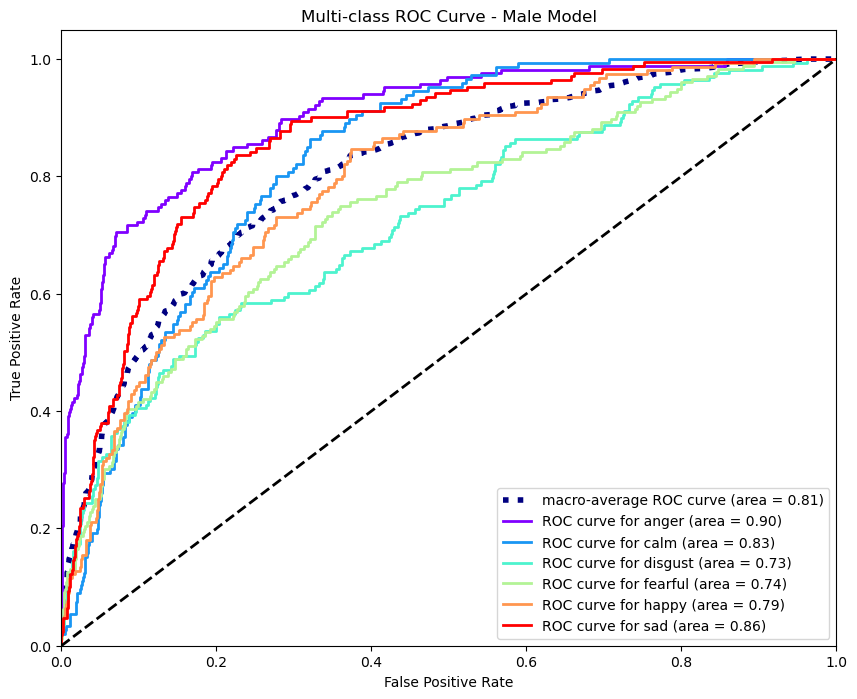

In [99]:
# Define the emotion classes
emotion_classes_cm = mlp_cm.classes_

# Binarize the labels for the male dataset
y_test_cm_binarized = label_binarize(y_test_cm, classes=emotion_classes_cm)
n_classes_cm = y_test_cm_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr_cm = dict()
tpr_cm = dict()
roc_auc_cm = dict()

y_prob_cm = mlp_cm.predict_proba(X_test_cm_sc)

for i in range(n_classes_cm):
    fpr_cm[i], tpr_cm[i], _ = roc_curve(y_test_cm_binarized[:, i], y_prob_cm[:, i])
    roc_auc_cm[i] = auc(fpr_cm[i], tpr_cm[i])

# Compute micro-average ROC curve and ROC area
fpr_cm["micro"], tpr_cm["micro"], _ = roc_curve(y_test_cm_binarized.ravel(), y_prob_cm.ravel())
roc_auc_cm["micro"] = auc(fpr_cm["micro"], tpr_cm["micro"])

# Aggregate all false positive rates
all_fpr_cm = np.unique(np.concatenate([fpr_cm[i] for i in range(n_classes_cm)]))

# Interpolate all ROC curves at these points
mean_tpr_cm = np.zeros_like(all_fpr_cm)
for i in range(n_classes_cm):
    mean_tpr_cm += np.interp(all_fpr_cm, fpr_cm[i], tpr_cm[i])

# Average it and compute AUC
mean_tpr_cm /= n_classes_cm

fpr_cm["macro"] = all_fpr_cm
tpr_cm["macro"] = mean_tpr_cm
roc_auc_cm["macro"] = auc(fpr_cm["macro"], tpr_cm["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot macro-average ROC curve
plt.plot(fpr_cm["macro"], tpr_cm["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_cm["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes_cm)))
for i, color in zip(range(n_classes_cm), colors):
    plt.plot(fpr_cm[i], tpr_cm[i], color=color, lw=2,
             label='ROC curve for {0} (area = {1:0.2f})'.format(emotion_classes_cm[i], roc_auc_cm[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Male Model')
plt.legend(loc="lower right")
plt.show()

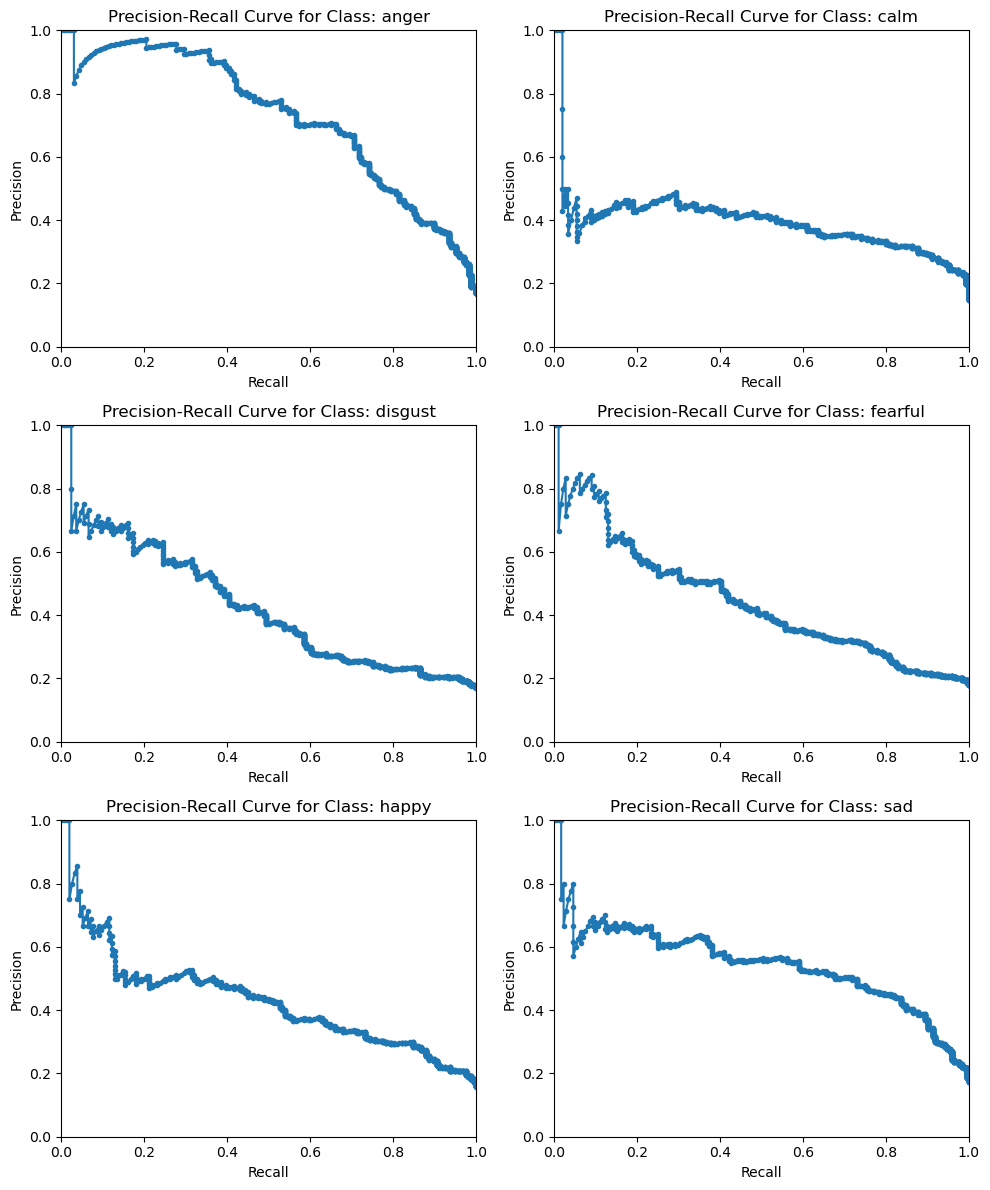

In [100]:
# Assuming 'y_test' is your true labels and 'model' is your trained model
# 'n_classes' is the number of emotion classes
emotion_classes_cm = mlp_cm.classes_
n_classes_cm = len(emotion_classes_cm)
y_score_cm = mlp_cm.predict_proba(X_test_cm_sc)

rows = n_classes_cm // 2 if n_classes_cm % 2 == 0 else (n_classes_cm // 2) + 1

fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10, rows * 4))
axes = axes.ravel()

# Hide unused subplots if the number of classes is odd
if n_classes_cm % 2 != 0:
    axes[-1].set_visible(False)

for i in range(n_classes_cm):
    # Convert y_test_male to binary format for the current class
    y_test_cm_binary = np.where(y_test_cm == emotion_classes_cm[i], 1, 0)
    
    # Compute precision and recall for each class
    precision, recall, _ = precision_recall_curve(y_test_cm_binary, y_score_cm[:, i])
    
    # Plot the precision-recall curve for the class
    axes[i].plot(recall, precision, marker='.')
    axes[i].set_title(f'Precision-Recall Curve for Class: {emotion_classes_cm[i]}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1])

plt.tight_layout()
plt.show()

### MLPC RAVDESS

In [31]:
df.columns

Index(['mfcc_mean', 'mfcc_max', 'mfcc_min', 'mfcc_median', 'mfcc_std',
       'mfcc_skew', 'mfcc_kurtosis', 'mfcc_delta_mean', 'mfcc_delta_max',
       'mfcc_delta_min', 'mfcc_delta_median', 'mfcc_delta_std',
       'mfcc_delta_skew', 'mfcc_delta_kurtosis', 'mfcc_delta2_mean',
       'mfcc_delta2_max', 'mfcc_delta2_min', 'mfcc_delta2_median',
       'mfcc_delta2_std', 'mfcc_delta2_skew', 'mfcc_delta2_kurtosis',
       'chroma_mean', 'chroma_min', 'chroma_max', 'chroma_median',
       'chroma_std', 'chroma_skew', 'chroma_kurtosis', 'mel_mean', 'mel_max',
       'mel_min', 'mel_median', 'mel_std', 'mel_skew', 'mel_kurtosis',
       'contrast_mean', 'contrast_max', 'contrast_min', 'contrast_median',
       'contrast_std', 'contrast_skew', 'contrast_kurtosis', 'centroid_mean',
       'centroid_max', 'centroid_min', 'centroid_median', 'centroid_std',
       'centroid_skew', 'centroid_kurtosis', 'roll_off_mean', 'roll_off_max',
       'roll_off_min', 'roll_off_median', 'roll_off_std', 'roll_

In [10]:
def emotion_to_string(e):
    if e % 8 == 1:
        return 'neutral'
    elif e % 8 == 2:
        return 'calm'
    elif e % 8 == 3:
        return 'happy'
    elif e % 8 == 4:
        return 'sad'
    elif e % 8 == 5:
        return 'angry'
    elif e % 8 == 6:
        return 'fearful'
    elif e % 8 == 7:
        return 'disgust'
    else:
        return 'surprised'

# Applying the function to the 'emotion' column
df['emotion'] = df['emotion'].apply(emotion_to_string)

In [11]:
# Encoding categorical features (if they are not already encoded)
df['actor_gender'] = df['actor_gender'].map({1: 0, 2: 1})

df_male = df[df['actor_gender'] == 0]
df_female = df[df['actor_gender'] == 1]

In [12]:
# Removing 'neutral' category
df_male = df_male[df_male['emotion'] != 'neutral']
df_female = df_female[df_female['emotion'] != 'neutral']

In [13]:
# feature_male = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 
#                 'mel_median', 'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
#                 'rms_mean', 'zero_cr_mean']
# feature_female = ['mfcc_mean', 'mfcc_delta_mean', 'mfcc_delta2_mean', 'mfcc_delta2_max', 'chroma_mean', 'mel_mean', 
#                   'mel_median', 'mel_skew', 'contrast_mean', 'centroid_mean', 'roll_off_mean', 'roll_off_kurtosis', 
#                   'rms_mean', 'zero_cr_mean']
feature_male = df.columns[8:]
feature_female = df.columns[8:]

In [14]:
print("Number of samples in male subset:", df_male.shape[0])
print("Number of samples in female subset:", df_female.shape[0])

Number of samples in male subset: 672
Number of samples in female subset: 672


In [15]:
# Creating a pipeline that first applies the StandardScaler and then fits the MLPClassifier
# Best accuracy: 0.6555555555555556
# alpha=0.385, activation='relu', solver='adam', learning_rate_init=0.0006, 
#                           batch_size=163, epsilon=1e-08, hidden_layer_sizes=(300, ), 
#                           learning_rate='constant', max_iter=2000

# 2nd best
# alpha=0.34, activation='relu', solver='adam', learning_rate_init=0.006, 
#                           batch_size=163, epsilon=1e-08, hidden_layer_sizes=(300, ), 
#                           learning_rate='constant', max_iter=1000

pipeline_m = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(alpha=0.385, activation='relu', solver='adam', learning_rate_init=0.0006, 
                          batch_size=163, epsilon=1e-08, hidden_layer_sizes=(300, ), 
                          learning_rate='constant', max_iter=2000))
])

# Features to training and testing
feature_list = feature_male

# Define features and target for male subset
X_male = df_male[feature_list]
y_male = df_male['emotion']

# Splitting the male dataset
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(X_male, y_male, test_size=0.25)

# Fit the pipeline to the male data
pipeline_m.fit(X_train_male, y_train_male)

# Evaluate the model for male subset
y_pred_m = pipeline_m.predict(X_test_male)
print(confusion_matrix(y_test_male, y_pred_m))
print(classification_report(y_test_male, y_pred_m))
accuracy_m = accuracy_score(y_test_male, y_pred_m)
print("Accuracy:", accuracy_m)

[[24  0  0  0  4  1  2]
 [ 0 16  1  0  0  0  1]
 [ 1  0 20  0  2  0  2]
 [ 1  0  1 13  3  6  3]
 [ 0  2  0  0 10  1  1]
 [ 0  1  5  4  3 11  2]
 [ 0  0  3  2  5  1 16]]
              precision    recall  f1-score   support

       angry       0.92      0.77      0.84        31
        calm       0.84      0.89      0.86        18
     disgust       0.67      0.80      0.73        25
     fearful       0.68      0.48      0.57        27
       happy       0.37      0.71      0.49        14
         sad       0.55      0.42      0.48        26
   surprised       0.59      0.59      0.59        27

    accuracy                           0.65       168
   macro avg       0.66      0.67      0.65       168
weighted avg       0.68      0.65      0.66       168

Accuracy: 0.6547619047619048


In [16]:
# Creating a pipeline that first applies the StandardScaler and then fits the MLPClassifier
# Best accuracy: 0.7738095238095238
# alpha=0.385, activation='relu', solver='adam', learning_rate_init=0.0006, 
#                           batch_size=163, epsilon=1e-08, hidden_layer_sizes=(300, ), 
#                           learning_rate='constant', max_iter=2000

# 2nd best
# alpha=0.34, activation='relu', solver='adam', learning_rate_init=0.006, 
#                           batch_size=163, epsilon=1e-08, hidden_layer_sizes=(300, ), 
#                           learning_rate='constant', max_iter=1000

pipeline_f = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(alpha=0.385, activation='relu', solver='adam', learning_rate_init=0.0006, 
                          batch_size=163, epsilon=1e-08, hidden_layer_sizes=(300, ), 
                          learning_rate='constant', max_iter=2000))
])

# Features to training and testing
feature_list = feature_female

# Define features and target for male subset
X_female = df_female[feature_list]
y_female = df_female['emotion']

# Splitting the male dataset
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(X_female, y_female, test_size=0.25)

# Fit the pipeline to the male data
pipeline_f.fit(X_train_female, y_train_female)

# Evaluate the model for male subset
y_pred_f = pipeline_f.predict(X_test_female)
print(confusion_matrix(y_test_female, y_pred_f))
print(classification_report(y_test_female, y_pred_f))
accuracy_f = accuracy_score(y_test_female, y_pred_f)
print("Accuracy:", accuracy_f)

[[14  0  4  1  1  0  1]
 [ 0 21  0  0  0  6  0]
 [ 1  0 21  0  1  2  0]
 [ 2  0  0 13  3  3  2]
 [ 1  1  1  1 14  2  3]
 [ 1  4  3  1  0 15  0]
 [ 1  0  1  2  0  0 21]]
              precision    recall  f1-score   support

       angry       0.70      0.67      0.68        21
        calm       0.81      0.78      0.79        27
     disgust       0.70      0.84      0.76        25
     fearful       0.72      0.57      0.63        23
       happy       0.74      0.61      0.67        23
         sad       0.54      0.62      0.58        24
   surprised       0.78      0.84      0.81        25

    accuracy                           0.71       168
   macro avg       0.71      0.70      0.70       168
weighted avg       0.71      0.71      0.71       168

Accuracy: 0.7083333333333334


In [17]:
# Perform 10-fold cross-validation
cv_scores_m_pip = cross_val_score(pipeline_m, X_train_male, y_train_male, cv=10, n_jobs=-1)

# Output the average score from cross-validation
print(f'Average CV Score for scaled male: {np.mean(cv_scores_m_pip)}')

Average CV Score for scaled male: 0.6389411764705881


In [18]:
# Perform 10-fold cross-validation
cv_scores_f_pip = cross_val_score(pipeline_f, X_train_female, y_train_female, cv=10, n_jobs=-1)

# Output the average score from cross-validation
print(f'Average CV Score for scaled female: {np.mean(cv_scores_f_pip)}')

Average CV Score for scaled female: 0.6905882352941177


## GridSearchCV

In [80]:
# from sklearn.model_selection import GridSearchCV   # Took too long, stopped to change parameters and reduce CPU load

# # Define the parameter grid
# param_grid = {
#     'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 100), (100, 50)],
#     'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
#     'mlp__solver': ['lbfgs', 'sgd', 'adam'],
#     'mlp__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.3849486],
#     'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
# }

# # Create GridSearchCV object
# grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=5, scoring='accuracy')

# # Fit grid_search to the data
# grid_search.fit(X_train_male, y_train_male)

# # Get the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

# # Evaluate the best model on the test set
# best_model = grid_search.best_estimator_
# y_pred_male = best_model.predict(X_test_male)
# print(confusion_matrix(y_test_male, y_pred_male))
# print(classification_report(y_test_male, y_pred_male))


In [81]:
# from sklearn.model_selection import GridSearchCV   # Took too long, stopped to change parameters and reduce CPU load

# # Define the parameter grid
# param_grid = {
#     'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 100), (100, 50)],
#     'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
#     'mlp__solver': ['lbfgs', 'sgd', 'adam'],
#     'mlp__alpha': [0.0001, 0.001, 0.01, 0.1],
#     'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
#     'mlp__batch_size': [32, 64, 128, 256],
#     'mlp__max_iter': [200, 400, 800, 1600]
# }

# # Create GridSearchCV object
# grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=5, scoring='accuracy')

# # Fit grid_search to the data
# grid_search.fit(X_train_male, y_train_male)

# # Output the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

# # Evaluate the best model
# best_model = grid_search.best_estimator_
# y_pred_male = best_model.predict(X_test_male)
# print(confusion_matrix(y_test_male, y_pred_male))
# print(classification_report(y_test_male, y_pred_male))


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(300, )],  # (300, ) was the best (vs. (50, ) through (500, 750))
    'mlp__activation': ['relu'],  # Using 'relu' yielded best results (vs. 'identity', 'logistic', 'tanh')
    'mlp__solver': ['sgd', 'adam'],  # Using 'sgd' yielded best results (vs. 'lbfgs', 'adam')
    'mlp__alpha': [0.3],  # 0.6 was the best from multiple similar tests
    'mlp__learning_rate_init': [0.0006],  # 0.0212 was best
    'mlp__batch_size': [163],  # 163, was best
    'mlp__max_iter': [1000]  # 1000 best for max_iter
}

# Creating a pipeline that first applies the StandardScaler and then fits the MLPClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(alpha=0.3, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=1000))
])

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=3, scoring='accuracy')

# Fit grid_search to the data
grid_search.fit(X_train_male, y_train_male)

# Output the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_male = best_model.predict(X_test_male)
print(confusion_matrix(y_test_male, y_pred_male))
print(classification_report(y_test_male, y_pred_male))

# adjust to best params, vary then test again

### RandomizedSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Expanded parameter grid  # Best Score: 0.5277777777777778 with below settings in comments
param_distributions = {
    'mlp__hidden_layer_sizes': [(300,), (500, 100), (300, 50)],  # best is (300, ) ((300,), (500, 100), (300, 50))
    'mlp__activation': ['identity', 'relu'],  # best is 'relu' ('identity', 'relu')
    'mlp__solver': ['adam', 'lbfgs'],  # best is 'adam' ('adam', 'lbfgs')
    'mlp__alpha': np.linspace(0.001, 1.5, 5),    # best is 0.33411111111111114 (0.001, 1.5, 10)
    'mlp__learning_rate_init': np.linspace(0.0005, 0.8, 5),    # best is 0.0005 (0.0005, 0.8, 10)
    'mlp__batch_size': [50, 163, 182],    # best is 163 (25, 50, 163)
    'mlp__max_iter': [1000]    # best is 2500 (1000, 2000, 2500)
}

# Creating a pipeline that first applies the StandardScaler and then fits the MLPClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(alpha=0.3, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=1000))
])

# Create GridSearchCV object
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=20, n_jobs=-1, cv=3, scoring='accuracy', random_state=21)

# Fit grid_search to the data
random_search.fit(X_train_male, y_train_male)

# Output the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Evaluate the best model
best_model = random_search.best_estimator_
y_pred_male = best_model.predict(X_test_male)
print(confusion_matrix(y_test_male, y_pred_male))
print(classification_report(y_test_male, y_pred_male))

## Multi Layer Perception Classifier - old method adapted

### MLPC CREMA-D old

In [2]:
# Extended feature extraction function
def extract_feature_c(signal, sample_rate, mfcc, chroma, mel, contrast, centroid, roll_off, bandwidth, energy, rms, 
                    delta_mfccs, delta2_mfccs):
    X = signal
    if chroma or centroid or roll_off or bandwidth:
        stft = np.abs(librosa.stft(X))
    
    result = np.array([])

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))

        if delta_mfccs:
            if mfccs.shape[0] > 1:  # Check if there are enough frames
                delta_mfccs = np.mean(librosa.feature.delta(mfccs).T, axis=0)
                result = np.hstack((result, delta_mfccs)) 
            else:
                # Handle the case where there are not enough frames
                # For example, append zeros or handle it as required
                pass

        if delta2_mfccs:
            if mfccs.shape[0] > 1:  # Check if there are enough frames
                delta2_mfccs = np.mean(librosa.feature.delta(mfccs, order=2).T, axis=0)
                result = np.hstack((result, delta2_mfccs)) 
            else:
                # Handle the case where there are not enough frames
                # For example, append zeros or handle it as required
                pass
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, contrast))
    if centroid:
        centroid = np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, centroid))
    if roll_off:
        roll_off = np.mean(librosa.feature.spectral_rolloff(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, roll_off))
    if bandwidth:
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, bandwidth))
    if energy:
        energy = np.array([np.sum(np.square(X))])
        result = np.hstack((result, energy))
    if rms:
        rms = np.mean(librosa.feature.rms(y=X).T, axis=0)
        result = np.hstack((result, rms))

    return result

In [3]:
# Emotions in the CREMA-D dataset

# Emotions to observe
observed_emotions=['anger', 'calm', 'disgust', 'fearful', 'happy', 'sad']

In [20]:
# load, segment and process data
# Best results: Accuracy of male scaled: 71.11%, Accuracy of female scaled: 78.33%
# with test_size=0.2, mfcc=True, delta_mfccs=True, delta2_mfccs=True, chroma=True, mel=True, contrast=False, 
#      centroid=False, roll_off=False, bandwidth=False, energy=False, rms=True

# Define new mappings for sentences and emotions
emotion = {
    'ANG': 'anger',
    'NEU': 'calm',
    'DIS': 'disgust',
    'FEA': 'fearful',
    'HAP': 'happy',
    'SAD': 'sad',
}

# Using a text file named 'gender_mapping.txt' with ActorID and Sex columns
gender_mapping = {}
with open('gender_mapping.txt', 'r') as file:
    for line in file:
        parts = line.strip().split()  # This splits the line by whitespace; adjust if necessary
        if len(parts) == 2:
            actor_id, sex = parts
            gender_mapping[actor_id] = sex.lower()  # Use lower to standardize the comparison later

def load_data_c(test_size=0.2, mfcc=True, delta_mfccs=True, delta2_mfccs=True, chroma=True, mel=True, contrast=False, 
                centroid=False, roll_off=False, bandwidth=False, energy=False, rms=True):
    X_male, y_male = [], []
    X_female, y_female = [], []

    for file in glob.glob(f'{sound_path}/CREMA-D/*.wav'):
        file_name = os.path.basename(file)
        
        # Parse the new filename format
        parts = file_name.split('_')
        emotion_code = parts[2]
        actor_id = file_name.split('_')[0]
        
        # Determine the gender using the mapping
        sex = gender_mapping.get(actor_id, None)
        if sex is None:
            print(f"ActorID {actor_id} not found in gender mapping.")
            continue

        if emotions[emotion_code] not in observed_emotions:
            continue
            
        # Load the audio file
        signal, sample_rate = librosa.load(file, sr=None)

        # Remove silent parts
        non_silent_intervals = librosa.effects.split(signal, top_db=30)  # top_db can be adjusted
        non_silent_signal = np.concatenate([signal[start:end] for start, end in non_silent_intervals])

        # Extract features from the entire non-silent signal
        feature = extract_feature_c(non_silent_signal, sample_rate, mfcc=mfcc, chroma=chroma, mel=mel, contrast=contrast, 
                                  centroid=centroid, roll_off=roll_off, bandwidth=bandwidth, energy=energy, rms=rms, 
                                  delta_mfccs=delta_mfccs, delta2_mfccs=delta2_mfccs)

        # Extract the emotion label using the emotion code from the filename
        emotion_label = emotions.get(emotion_code, None)
        if emotion_label is None:
            print(f"Emotion code {emotion_code} not found in emotions dictionary.")
            continue
        
        # Append features to the corresponding gender list
        if sex == 'female':
            X_female.append(feature)
            y_female.append(emotion_label)  # Append the string label, not the dictionary
        elif sex == 'male':
            X_male.append(feature)
            y_male.append(emotion_label)  # Append the string label, not the dictionary

    print(f"Total male samples: {len(X_male)}, Total female samples: {len(X_female)}")
            
    # Splitting the datasets into train and test sets
    if X_male:
        X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(np.array(X_male), y_male, test_size=test_size)
    else:
        print("No male samples to split.")
    if X_female:
        X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(np.array(X_female), y_female, test_size=test_size)
    else:
        print("No female samples to split.")

    return (X_train_male, X_test_male, y_train_male, y_test_male), (X_train_female, X_test_female, y_train_female, y_test_female)


In [21]:
# Split the datasets into male and female parts
(X_train_male, X_test_male, y_train_male, y_test_male), (X_train_female, X_test_female, y_train_female, y_test_female) = load_data_c(test_size=0.25)

# Initialize separate scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_male_scaled = scaler_male.fit_transform(X_train_male)
X_test_male_scaled = scaler_male.transform(X_test_male)

# Scale the female datasets
X_train_female_scaled = scaler_female.fit_transform(X_train_female)
X_test_female_scaled = scaler_female.transform(X_test_female)

C:\Users\where\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Total male samples: 3930, Total female samples: 3512


In [22]:
# Initialize the Multi Layer Perceptron Classifier  
# Best results: Accuracy of male: 68.89%, Accuracy of female: 68.33%
#               Accuracy of male scaled: 71.11%, Accuracy of female scaled: 78.33%
# alpha=0.385, activation='relu', solver='adam', 
#                                  learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
#                                  hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=4000
model_male=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)
model_female=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)
model_male_scaled=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)
model_female_scaled=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)

In [23]:
# Train the model      # performance suffered with PCA, removed
model_male.fit(X_train_male, y_train_male)
model_female.fit(X_train_female, y_train_female)
model_male_scaled.fit(X_train_male_scaled, y_train_male)
model_female_scaled.fit(X_train_female_scaled, y_train_female)

MLPClassifier(alpha=0.385, batch_size=163, hidden_layer_sizes=(300,),
              learning_rate_init=0.0006, max_iter=2000)

In [24]:
# Predict for the test set      # performance suffered with PCA, removed
y_pred_m = model_male.predict(X_test_male)
y_pred_f = model_female.predict(X_test_female)
y_pred_m_sc = model_male_scaled.predict(X_test_male_scaled)
y_pred_f_sc = model_female_scaled.predict(X_test_female_scaled)

In [25]:
# Calculate the accuracy of our model      # performance suffered with PCA, removed
accuracy_m = accuracy_score(y_true = y_test_male, y_pred = y_pred_m)
accuracy_f = accuracy_score(y_true = y_test_female, y_pred = y_pred_f)
accuracy_m_sc = accuracy_score(y_true = y_test_male, y_pred = y_pred_m_sc)
accuracy_f_sc = accuracy_score(y_true = y_test_female, y_pred = y_pred_f_sc)

# Print the results
print("\nExample Classification Report for male:")
print(classification_report(y_test_male, model_male.predict(X_test_male)))
print("\nExample Confusion Matrix for male:")
print(confusion_matrix(y_test_male, model_male.predict(X_test_male)))
print()
print("Accuracy of male: {:.2f}%".format(accuracy_m*100))
print()
print()
print("\nExample Classification Report for female:")
print(classification_report(y_test_female, model_female.predict(X_test_female)))
print("\nExample Confusion Matrix for female:")
print(confusion_matrix(y_test_female, model_female.predict(X_test_female)))
print()
print("Accuracy of female: {:.2f}%".format(accuracy_f*100))
print()
print()
print("\nExample Classification Report for male scaled:")
print(classification_report(y_test_male, model_male_scaled.predict(X_test_male_scaled)))
print("\nExample Confusion Matrix for male scaled:")
print(confusion_matrix(y_test_male, model_male_scaled.predict(X_test_male_scaled)))
print()
print("Accuracy of male scaled: {:.2f}%".format(accuracy_m_sc*100))
print()
print()
print("\nExample Classification Report for female scaled:")
print(classification_report(y_test_female, model_female_scaled.predict(X_test_female_scaled)))
print("\nExample Confusion Matrix for female scaled:")
print(confusion_matrix(y_test_female, model_female_scaled.predict(X_test_female_scaled)))
print()
print("Accuracy of female scaled: {:.2f}%".format(accuracy_f_sc*100))


Example Classification Report for male:
              precision    recall  f1-score   support

       anger       0.58      0.59      0.59       165
        calm       0.35      0.60      0.44       125
     disgust       0.42      0.19      0.26       164
     fearful       0.39      0.34      0.36       185
       happy       0.40      0.56      0.46       180
         sad       0.60      0.41      0.49       164

    accuracy                           0.44       983
   macro avg       0.45      0.45      0.43       983
weighted avg       0.46      0.44      0.43       983


Example Confusion Matrix for male:
[[ 98   8  12  17  30   0]
 [  1  75   7   8  29   5]
 [ 21  39  31  22  43   8]
 [ 19  30   8  62  36  30]
 [ 29  24   7  18 100   2]
 [  1  41   9  32  14  67]]

Accuracy of male: 44.05%



Example Classification Report for female:
              precision    recall  f1-score   support

       anger       0.62      0.66      0.64       134
        calm       0.58      0.18    

In [2]:
# Extended feature extraction function
def extract_feature(signal, sample_rate, mfcc, chroma, mel, contrast, centroid, roll_off, bandwidth, energy, rms, delta_mfccs, delta2_mfccs):
    X = signal
    if chroma or centroid or roll_off or bandwidth:
        stft = np.abs(librosa.stft(X))
    
    result = np.array([])

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))

        if delta_mfccs:
            if mfccs.shape[0] > 1:  # Check if there are enough frames
                delta_mfccs = np.mean(librosa.feature.delta(mfccs).T, axis=0)
                result = np.hstack((result, delta_mfccs)) 
            else:
                # Handle the case where there are not enough frames
                # For example, append zeros or handle it as required
                pass

        if delta2_mfccs:
            if mfccs.shape[0] > 1:  # Check if there are enough frames
                delta2_mfccs = np.mean(librosa.feature.delta(mfccs, order=2).T, axis=0)
                result = np.hstack((result, delta2_mfccs)) 
            else:
                # Handle the case where there are not enough frames
                # For example, append zeros or handle it as required
                pass
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, contrast))
    if centroid:
        centroid = np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, centroid))
    if roll_off:
        roll_off = np.mean(librosa.feature.spectral_rolloff(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, roll_off))
    if bandwidth:
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, bandwidth))
    if energy:
        energy = np.array([np.sum(np.square(X))])
        result = np.hstack((result, energy))
    if rms:
        rms = np.mean(librosa.feature.rms(y=X).T, axis=0)
        result = np.hstack((result, rms))

    return result

In [24]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to observe
# observed_emotions=['calm', 'happy', 'angry', 'disgust']
# observed_emotions=['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust']
observed_emotions=['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
# observed_emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

In [17]:
# # load, segment and process data
# def load_data(test_size=0.2, mfcc=True, delta_mfccs=True, delta2_mfccs=True, chroma=True, mel=True, contrast=False, centroid=False, roll_off=False, bandwidth=False, energy=False, rms=True):
#     X_male, y_male = [], []
#     X_female, y_female = [], []
#     for file in glob.glob(f'{sound_path}/ravdess-data/Actor_*/*.wav'):
#         file_name = os.path.basename(file)
#         emotion = emotions[file_name.split("-")[2]]
#         actor_number = int(file_name.split("-")[-1].split(".")[0])  # Extract actor number from filename

#         if emotion not in observed_emotions:
#             continue

#         # Load the audio file
#         signal, sample_rate = librosa.load(file, sr=None)

#         # Remove silent parts
#         non_silent_intervals = librosa.effects.split(signal, top_db=30)  # top_db can be adjusted
#         non_silent_signal = np.concatenate([signal[start:end] for start, end in non_silent_intervals])

#         # Split the signal into 3 segments
#         segments = np.array_split(non_silent_signal, 2)

#         for segment in segments:
#             # Extract features from each segment
#             feature = extract_feature(segment, sample_rate, mfcc=mfcc, chroma=chroma, mel=mel, contrast=contrast, centroid=centroid, roll_off=roll_off, bandwidth=bandwidth, energy=energy, rms=rms, delta_mfccs=delta_mfccs, delta2_mfccs=delta2_mfccs)
#             if actor_number % 2 == 0:  # Female actors have even numbers
#                 X_female.append(feature)
#                 y_female.append(emotion)
#             else:  # Male actors have odd numbers
#                 X_male.append(feature)
#                 y_male.append(emotion)

#     # Splitting the datasets into train and test sets
#     X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(np.array(X_male), y_male, test_size=test_size, random_state=42)
#     X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(np.array(X_female), y_female, test_size=test_size, random_state=42)

#     return (X_train_male, X_test_male, y_train_male, y_test_male), (X_train_female, X_test_female, y_train_female, y_test_female)


In [35]:
# load, segment and process data
# Best results: Accuracy of male scaled: 71.11%, Accuracy of female scaled: 78.33%
# with test_size=0.2, mfcc=True, delta_mfccs=True, delta2_mfccs=True, chroma=True, mel=True, contrast=False, 
#      centroid=False, roll_off=False, bandwidth=False, energy=False, rms=True
def load_data(test_size=0.2, mfcc=True, delta_mfccs=True, delta2_mfccs=True, chroma=True, mel=True, contrast=False, 
              centroid=False, roll_off=False, bandwidth=False, energy=False, rms=True):
    X_male, y_male = [], []
    X_female, y_female = [], []
    for file in glob.glob(f'{sound_path}/ravdess-data/Actor_*/*.wav'):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        actor_number = int(file_name.split("-")[-1].split(".")[0])  # Extract actor number from filename

        if emotion not in observed_emotions:
            continue

        # Load the audio file
        signal, sample_rate = librosa.load(file, sr=None)

        # Remove silent parts
        non_silent_intervals = librosa.effects.split(signal, top_db=30)  # top_db can be adjusted
        non_silent_signal = np.concatenate([signal[start:end] for start, end in non_silent_intervals])

        # Extract features from the entire non-silent signal
        feature = extract_feature(non_silent_signal, sample_rate, mfcc=mfcc, chroma=chroma, mel=mel, contrast=contrast, centroid=centroid, roll_off=roll_off, bandwidth=bandwidth, energy=energy, rms=rms, delta_mfccs=delta_mfccs, delta2_mfccs=delta2_mfccs)
        if actor_number % 2 == 0:  # Female actors have even numbers
            X_female.append(feature)
            y_female.append(emotion)
        else:  # Male actors have odd numbers
            X_male.append(feature)
            y_male.append(emotion)

    # Splitting the datasets into train and test sets
    X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(np.array(X_male), y_male, test_size=test_size)
    X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(np.array(X_female), y_female, test_size=test_size)

    return (X_train_male, X_test_male, y_train_male, y_test_male), (X_train_female, X_test_female, y_train_female, y_test_female)


In [36]:
# from sklearn.decomposition import PCA      # performance suffered with PCA, removed

# Split the datasets into male and female parts
(X_train_male, X_test_male, y_train_male, y_test_male), (X_train_female, X_test_female, y_train_female, y_test_female) = load_data(test_size=0.25)

# Initialize separate scalers for male and female datasets
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale the male datasets
X_train_male_scaled = scaler_male.fit_transform(X_train_male)
X_test_male_scaled = scaler_male.transform(X_test_male)

# Scale the female datasets
X_train_female_scaled = scaler_female.fit_transform(X_train_female)
X_test_female_scaled = scaler_female.transform(X_test_female)

In [6]:
# Get the shape of the regular training and testing datasets
print((X_train_male.shape[0], X_test_male.shape[0]))
print((X_train_female.shape[0], X_test_female.shape[0]))

(504, 168)
(504, 168)


In [7]:
# Get the shape of the Scaled training and testing datasets
print((X_train_male_scaled.shape[0], X_test_male.shape[0]))
print((X_train_female_scaled.shape[0], X_test_female.shape[0]))

(504, 168)
(504, 168)


In [8]:
# Get the number of regular features extracted
print(f'Features extracted: {X_train_male.shape[1]}')
print(f'Features extracted: {X_train_female.shape[1]}')

Features extracted: 183
Features extracted: 183


In [9]:
# Get the number of Scaled features extracted
print(f'Features extracted: {X_train_male_scaled.shape[1]}')
print(f'Features extracted: {X_train_female_scaled.shape[1]}')

Features extracted: 183
Features extracted: 183


#### Modeling, fitting and predicting male, female, male scaled, and female scaled

In [10]:
# # Initialize the Multi Layer Perceptron Classifier      # old parameters
# model_male=MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), learning_rate = 'adaptive', max_iter = 500)
# model_female=MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), learning_rate = 'adaptive', max_iter = 500)
# model_male_scaled=MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), learning_rate = 'adaptive', max_iter = 500)
# model_female_scaled=MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), learning_rate = 'adaptive', max_iter = 500)

In [37]:
# Initialize the Multi Layer Perceptron Classifier  
# Best results: Accuracy of male: 68.89%, Accuracy of female: 68.33%
#               Accuracy of male scaled: 71.11%, Accuracy of female scaled: 78.33%
# alpha=0.385, activation='relu', solver='adam', 
#                                  learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
#                                  hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=4000
model_male=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)
model_female=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)
model_male_scaled=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)
model_female_scaled=MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000)

In [38]:
# Train the model      # performance suffered with PCA, removed
model_male.fit(X_train_male, y_train_male)
model_female.fit(X_train_female, y_train_female)
model_male_scaled.fit(X_train_male_scaled, y_train_male)
model_female_scaled.fit(X_train_female_scaled, y_train_female)

MLPClassifier(alpha=0.385, batch_size=163, hidden_layer_sizes=(300,),
              learning_rate_init=0.0006, max_iter=2000)

In [39]:
# Predict for the test set      # performance suffered with PCA, removed
y_pred_m = model_male.predict(X_test_male)
y_pred_f = model_female.predict(X_test_female)
y_pred_m_sc = model_male_scaled.predict(X_test_male_scaled)
y_pred_f_sc = model_female_scaled.predict(X_test_female_scaled)

In [40]:
# Calculate the accuracy of our model      # performance suffered with PCA, removed
accuracy_m = accuracy_score(y_true = y_test_male, y_pred = y_pred_m)
accuracy_f = accuracy_score(y_true = y_test_female, y_pred = y_pred_f)
accuracy_m_sc = accuracy_score(y_true = y_test_male, y_pred = y_pred_m_sc)
accuracy_f_sc = accuracy_score(y_true = y_test_female, y_pred = y_pred_f_sc)

# Print the results
print("\nExample Classification Report for male:")
print(classification_report(y_test_male, model_male.predict(X_test_male)))
print("\nExample Confusion Matrix for male:")
print(confusion_matrix(y_test_male, model_male.predict(X_test_male)))
print()
print("Accuracy of male: {:.2f}%".format(accuracy_m*100))
print()
print()
print("\nExample Classification Report for female:")
print(classification_report(y_test_female, model_female.predict(X_test_female)))
print("\nExample Confusion Matrix for female:")
print(confusion_matrix(y_test_female, model_female.predict(X_test_female)))
print()
print("Accuracy of female: {:.2f}%".format(accuracy_f*100))
print()
print()
print("\nExample Classification Report for male scaled:")
print(classification_report(y_test_male, model_male_scaled.predict(X_test_male_scaled)))
print("\nExample Confusion Matrix for male scaled:")
print(confusion_matrix(y_test_male, model_male_scaled.predict(X_test_male_scaled)))
print()
print("Accuracy of male scaled: {:.2f}%".format(accuracy_m_sc*100))
print()
print()
print("\nExample Classification Report for female scaled:")
print(classification_report(y_test_female, model_female_scaled.predict(X_test_female_scaled)))
print("\nExample Confusion Matrix for female scaled:")
print(confusion_matrix(y_test_female, model_female_scaled.predict(X_test_female_scaled)))
print()
print("Accuracy of female scaled: {:.2f}%".format(accuracy_f_sc*100))


Example Classification Report for male:
              precision    recall  f1-score   support

       angry       0.88      0.62      0.73        37
        calm       0.75      0.71      0.73        21
     disgust       0.52      0.71      0.60        24
     fearful       0.39      0.63      0.48        19
       happy       0.57      0.67      0.62        18
         sad       0.48      0.46      0.47        24
   surprised       0.93      0.52      0.67        25

    accuracy                           0.61       168
   macro avg       0.65      0.62      0.61       168
weighted avg       0.67      0.61      0.62       168


Example Confusion Matrix for male:
[[23  2  5  4  0  2  1]
 [ 0 15  2  1  0  3  0]
 [ 2  0 17  3  1  1  0]
 [ 0  0  3 12  3  1  0]
 [ 0  0  1  3 12  2  0]
 [ 1  3  2  4  3 11  0]
 [ 0  0  3  4  2  3 13]]

Accuracy of male: 61.31%



Example Classification Report for female:
              precision    recall  f1-score   support

       angry       0.64      0.

#### Cross-Validation

In [41]:
# Perform 10-fold cross-validation
cv_scores_m = cross_val_score(model_male, X_train_male, y_train_male, cv=10, n_jobs=-1)

# Output the average score from cross-validation
print(f'Average CV Score for male: {np.mean(cv_scores_m)}')

Average CV Score for male: 0.6106666666666667


In [42]:
# Perform 10-fold cross-validation
cv_scores_f = cross_val_score(model_female, X_train_female, y_train_female, cv=10, n_jobs=-1)

# Output the average score from cross-validation
print(f'Average CV Score for female: {np.mean(cv_scores_f)}')

Average CV Score for female: 0.6843529411764705


In [43]:
# Perform 10-fold cross-validation
cv_scores_m_sc = cross_val_score(model_male_scaled, X_train_male_scaled, y_train_male, cv=10, n_jobs=-1)

# Output the average score from cross-validation
print(f'Average CV Score for scaled male: {np.mean(cv_scores_m_sc)}')

Average CV Score for scaled male: 0.7123137254901961


In [44]:
# Perform 10-fold cross-validation
cv_scores_f_sc = cross_val_score(model_female_scaled, X_train_female_scaled, y_train_female, cv=10, n_jobs=-1)

# Output the average score from cross-validation
print(f'Average CV Score for scaled female: {np.mean(cv_scores_f_sc)}')

Average CV Score for scaled female: 0.7616470588235293


### Bootstrapping

#### Just split male

Average Accuracy for males: 59.14%

Example Classification Report:
              precision    recall  f1-score   support

       angry       0.82      0.58      0.68        24
        calm       0.65      0.75      0.70        32
     disgust       0.40      0.44      0.42        18
     fearful       0.44      0.33      0.38        21
       happy       0.56      0.56      0.56        25
     neutral       0.41      0.70      0.52        10
         sad       0.28      0.30      0.29        23
   surprised       0.65      0.56      0.60        27

    accuracy                           0.53       180
   macro avg       0.53      0.53      0.52       180
weighted avg       0.55      0.53      0.53       180


Example Confusion Matrix:
[[14  0  4  2  2  1  1  0]
 [ 0 24  0  0  0  2  6  0]
 [ 0  3  8  2  2  0  1  2]
 [ 2  1  3  7  2  0  5  1]
 [ 1  1  1  2 14  4  0  2]
 [ 0  0  0  0  0  7  3  0]
 [ 0  7  1  2  1  2  7  3]
 [ 0  1  3  1  4  1  2 15]]


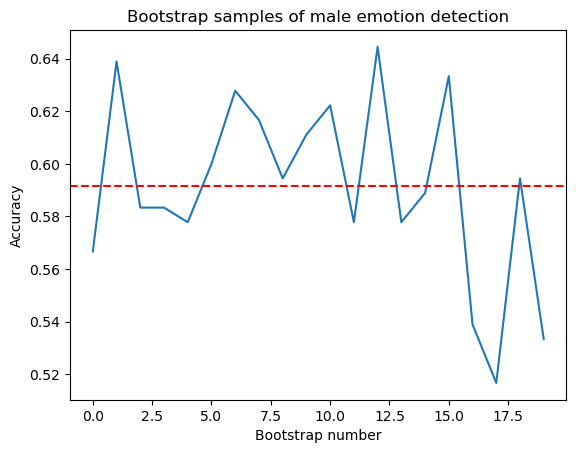

In [174]:
# Number of bootstrap samples
n_iterations = 20

# Array to store scores
classification_reports_m = []
confusion_matrices_m = []

# Define the pipeline   # Best average: 65.00%   alpha=0.3849486, activation='relu', solver='lbfgs', batch_size=163,
#                                                hidden_layer_sizes=(1283,),learning_rate='constant', max_iter=2000
                                                 
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000, random_state=42))
])

for i in range(n_iterations):
    # Prepare bootstrap sample
    X_train_boot_m, y_train_boot_m = resample(X_train_male, y_train_male)

    # Fit the pipeline on the bootstrap sample
    pipeline.fit(X_train_boot_m, y_train_boot_m)

    # Evaluate the model on the original test set
    y_pred_m = pipeline.predict(X_test_male)
    report_m = classification_report(y_test_male, y_pred_m, output_dict=True)
    matrix_m = confusion_matrix(y_test_male, y_pred_m)

    classification_reports_m.append(report_m)
    confusion_matrices_m.append(matrix_m)

# Calculate average performance from classification reports
average_performance_m = np.mean([report_m['accuracy'] for report_m in classification_reports_m])
print(f'Average Accuracy for males: {average_performance_m * 100:.2f}%')

# Print out an example classification report and confusion matrix
print("\nExample Classification Report:")
print(classification_report(y_test_male, pipeline.predict(X_test_male)))

print("\nExample Confusion Matrix:")
print(confusion_matrix(y_test_male, pipeline.predict(X_test_male)))

# Plot results
plt.plot([report_m['accuracy'] for report_m in classification_reports_m])
plt.axhline(y=average_performance_m, color='r', linestyle='--')
plt.xlabel('Bootstrap number')
plt.ylabel('Accuracy')
plt.title('Bootstrap samples of male emotion detection')
plt.show()

#### Just split female

Average Accuracy for females: 65.67%

Example Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.71      0.74        24
        calm       0.63      0.68      0.65        25
     disgust       0.60      0.54      0.57        28
     fearful       0.50      0.74      0.60        19
       happy       0.92      0.44      0.60        27
     neutral       0.29      0.36      0.32        11
         sad       0.56      0.56      0.56        27
   surprised       0.54      0.68      0.60        19

    accuracy                           0.59       180
   macro avg       0.60      0.59      0.58       180
weighted avg       0.63      0.59      0.60       180


Example Confusion Matrix:
[[17  1  2  0  0  2  0  2]
 [ 0 17  0  1  0  1  6  0]
 [ 3  2 15  1  0  2  3  2]
 [ 1  0  1 14  0  0  2  1]
 [ 0  1  1  6 12  2  0  5]
 [ 0  6  0  0  0  4  1  0]
 [ 0  0  3  5  0  3 15  1]
 [ 1  0  3  1  1  0  0 13]]


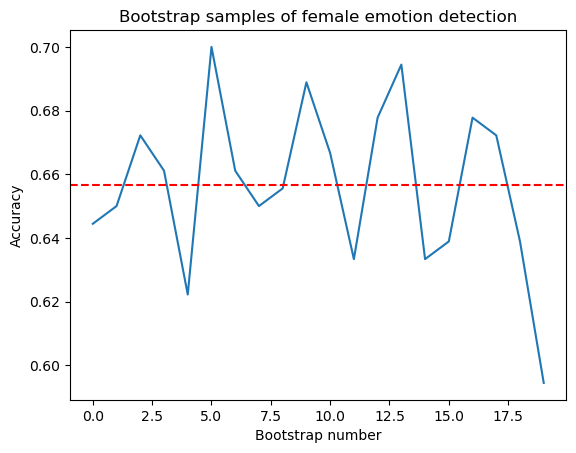

In [173]:
# Number of bootstrap samples
n_iterations = 10

# Array to store scores
classification_reports_f = []
confusion_matrices_f = []

# Define the pipeline   # Best average: 65.00%   alpha=0.3849486, activation='relu', solver='lbfgs', batch_size=163,
#                                                hidden_layer_sizes=(1283,),learning_rate='constant', max_iter=2000
                                                 
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(alpha=0.385, activation='relu', solver='adam', 
                                 learning_rate_init=0.0006, batch_size=163, epsilon=1e-08,
                                 hidden_layer_sizes=(300, ), learning_rate='constant', max_iter=2000, random_state=42))
])

for i in range(n_iterations):
    # Prepare bootstrap sample
    X_train_boot_f, y_train_boot_f = resample(X_train_female, y_train_female)

    # Fit the pipeline on the bootstrap sample
    pipeline.fit(X_train_boot_f, y_train_boot_f)

    # Evaluate the model on the original test set
    y_pred_f = pipeline.predict(X_test_female)
    report_f = classification_report(y_test_female, y_pred_f, output_dict=True)
    matrix_f = confusion_matrix(y_test_female, y_pred_f)

    classification_reports_f.append(report_f)
    confusion_matrices_f.append(matrix_f)

# Calculate average performance from classification reports
average_performance_f = np.mean([report_f['accuracy'] for report_f in classification_reports_f])
print(f'Average Accuracy for females: {average_performance_f * 100:.2f}%')

# Print out an example classification report and confusion matrix
print("\nExample Classification Report:")
print(classification_report(y_test_female, pipeline.predict(X_test_female)))

print("\nExample Confusion Matrix:")
print(confusion_matrix(y_test_female, pipeline.predict(X_test_female)))

# Plot results
plt.plot([report_f['accuracy'] for report_f in classification_reports_f])
plt.axhline(y=average_performance_f, color='r', linestyle='--')
plt.xlabel('Bootstrap number')
plt.ylabel('Accuracy')
plt.title('Bootstrap samples of female emotion detection')
plt.show()

#### RandomSearch split male

In [38]:
# Number of samples
n_iterations = 10

# Array to store scores
scores_m = []

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier())
])

# Define the parameter space for RandomizedSearchCV
param_distributions = {
    'mlp__solver': ['adam', 'lbfgs'],
    'mlp__alpha': [0.3, 0.385],  # [0.34, 0.385] next
    'mlp__batch_size': [163],
    'mlp__hidden_layer_sizes': [(300,)],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.0006],
    'mlp__epsilon': [1e-08],
    'mlp__max_iter': [1000]
}

# Initialize RandomizedSearchCV with n_jobs=-1 to use all processors
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=3, random_state=42, n_jobs=-1)

for i in range(n_iterations):
    # Prepare bootstrap sample
    X_train_boot, y_train_boot = resample(X_train_male, y_train_male)

    # Use RandomizedSearchCV on the bootstrap sample
    random_search.fit(X_train_boot, y_train_boot)

    # Get the best model
    best_model = random_search.best_estimator_

    # Evaluate the best model on the original test set
    y_pred_m = best_model.predict(X_test_male)
    score_m = accuracy_score(y_test_male, y_pred_m)
    scores_m.append(score_m)

# Calculate average performance
average_performance_m = np.mean(scores_m)
print(f'Average Accuracy for males: {average_performance_m * 100:.2f}%')

# Plot results
plt.plot(scores_m)
plt.axhline(y=average_performance_m, color='r', linestyle='--')
plt.xlabel('Iteration number')
plt.ylabel('Score')
plt.title('Samples of male emotion detection with RandomizedSearchCV')
plt.show()

KeyboardInterrupt: 

In [22]:
# pip install -y tensorflow==2.12


In [1]:
import sys
# import tensorflow.keras
import tensorflow as tf
import numpy as np

print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.13.1

Python 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
GPU is NOT AVAILABLE


In [16]:
# Exporting to CSV file
df.to_csv('voice_data_eda.csv', index=False)